<a href="https://colab.research.google.com/github/Caterina1996/SFEW_dataset/blob/master/FACES_SFEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Cuaderno 2: modelo con el FACES ya explorado, entrenado y guardadoç
#Evaluamos 2 de las mejores opciones una sin EarlyStopping y otra con Earlystopping entrenada durante algunas epochs menos
#Evaluamos el modelo para el test de set del FACES y comparamos con el test de set del SFEW

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
#Cargamos el SFEW:
!rm -rf SFEW
!git clone https://github.com/Caterina1996/SFEW_dataset

Cloning into 'SFEW_dataset'...
remote: Enumerating objects: 1348, done.
remote: Counting objects: 100% (1348/1348), done.
remote: Compressing objects: 100% (1335/1335), done.
remote: Total 1348 (delta 20), reused 1326 (delta 13), pack-reused 0
Receiving objects: 100% (1348/1348), 41.16 MiB | 19.92 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [ ]:
%%capture
#Cargamos el FACES:
!rm -rf FACES_ordenat.zip
!unzip /content/gdrive/MyDrive/FACES_ordenat.zip

In [ ]:
import operator
import numpy as np
from matplotlib import pyplot as plt
import itertools
import glob
import ntpath as nt
import os
from PIL import Image

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, BatchNormalization, MaxPooling2D
from keras import applications
from keras.models import load_model
from keras.callbacks import ModelCheckpoint,CSVLogger
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from tensorflow.keras.layers import *

import sklearn.metrics as sk_metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model



In [ ]:
#set random seed
from numpy.random import seed
seed(42)

from tensorflow import random
random.set_seed(42)

In [ ]:
#Initialize params
img_width, img_height =128, 128
WIDTH,HEIGHT=128, 128
LR = 0.00001
epochs = 55
batch_size = 2
num_classes=6 #number of output clases
dropout = 0.25
dataugmentation=False
FACES_train_dir='/content/FACES_ordenat/Train2'
FACES_test_dir='/content/FACES_ordenat/Test2'

SFEW_train_dir='/content/SFEW_dataset/Train'
SFEW_test_dir='/content/SFEW_dataset/Val'


In [ ]:
def plot_conf_matrix(test_set,modelo,path,title,standard_format=True,percentages=True,save_plot=True):
  y_true=test_set.labels
  print(len(y_true))
  labels=[key for key in test_set.class_indices.keys()]
  predictions=modelo.predict(test_set)
  ypred=[round(list(i).index(max(i))) for i in predictions]
  print(confusion_matrix(test_set.classes, ypred)[:,:])
  print("")
  f1=f1_score(y_true, ypred,average=None)
  f1_w=f1_score(y_true, ypred,average='weighted')
  ac=accuracy_score(y_true, ypred)
  print("accuracy: ",ac)
  print("f1 score:",f1)
  print("f1 score weighted:",f1_w)
  print("---------------------------------------------------------")
  print(title)
  if standard_format:

    cm = confusion_matrix(y_true, ypred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues,xticks_rotation='vertical',values_format='d')
    if save_plot:
      plt.savefig(path+".png")
    plt.show()
  print("")
  if standard_format:

    cm = confusion_matrix(y_true, ypred,normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues,xticks_rotation='vertical',values_format='.2f')
    plt.show()
    if save_plot:
      plt.savefig(path+"_perctg.png")
    plt.show()
  print("")

In [ ]:
def create_sets(dataugmentation,train_data_dir,validation_data_dir,batch_size,classes,color_mode="grayscale"):

  if dataugmentation==True:
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   brightness_range=[0.5,1.0],
                                   zoom_range=0.1,
                                   shear_range=0.2,
                                  #  height_shift_range=0.1,
                                   horizontal_flip=True)
  else:

    train_datagen = ImageDataGenerator(rescale=1. / 255)

  test_datagen= ImageDataGenerator(rescale=1. / 255)

  train_set = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(WIDTH, HEIGHT),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode=color_mode,
    classes=classes,
    shuffle=True)
  
  test_set = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(WIDTH, HEIGHT),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode=color_mode,
    classes=classes,
    shuffle=False)
  
  return train_set,test_set

In [ ]:
#Solo hay 5 emociones comunes así que son las que hay que usar para comparar
!ls SFEW_dataset/Train
!ls /content/FACES_ordenat/Train2

classes_sfew=os.listdir("SFEW_dataset/Train")
# classes_faces=os.listdir("/content/FACES_ordenat/Train2")
print("")
print(classes_sfew)
# print(classes_faces) 
#Si no estan en el mismo orden las predicciones no significaran lo mismo y no podremos evaluar un modelo entrenado con un dataset con el otro

classes_sfew=["Angry" , "Disgust","Fear" ,"Happy","Neutral" ,"Sad"]
classes_faces=["Anger", "Disgust", "Fear", "Happiness", "Neutrality", "Sadness"]

print("")
print(classes_sfew)
# print(classes_faces)

Angry  Disgust	Fear  Happy  Neutral  Sad  Surprise
ls: cannot access '/content/FACES_ordenat/Train2': No such file or directory

['Sad', 'Surprise', 'Fear', 'Happy', 'Disgust', 'Neutral', 'Angry']

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']


In [ ]:
FACES_train_set,FACES_test_set=create_sets(dataugmentation,FACES_train_dir,FACES_test_dir,batch_size,classes_faces)

SFEW_train_set,SFEW_test_set=create_sets(dataugmentation,SFEW_train_dir,SFEW_test_dir,batch_size,classes_sfew)

#Check:
# print(SFEW_train_set.class_indices)
# print(SFEW_test_set.class_indices)
# print(FACES_train_set.class_indices)
# print(FACES_test_set.class_indices)

Found 0 images belonging to 6 classes.
Found 0 images belonging to 6 classes.
Found 766 images belonging to 6 classes.
Found 356 images belonging to 6 classes.


In [ ]:
#Cargamos el modelo entrenado con el FACES y lo evaluamos con el set de test del FACES y del SFEW:
model0_FACES=keras.models.load_model('/content/gdrive/MyDrive/saved_models/modelo_base_FACES.h5')
model0_FACES_ES=keras.models.load_model('/content/gdrive/MyDrive/saved_models/modelo_base_FACES_ES.h5') # modelo entrenado utilizando EarlyStopping

1026
[[132   4   0   0  26   9]
 [ 14 102   2   0  41  12]
 [  1   1 133   1  34   1]
 [  3   0   4 132  31   1]
 [  0   0   0   0 171   0]
 [ 15   3   4   1  78  70]]

accuracy:  0.7212475633528265
f1 score: [0.78571429 0.72597865 0.84713376 0.86557377 0.61956522 0.53030303]
f1 score weighted: 0.7290447849248399
---------------------------------------------------------
modelo_0 50 epochs entrenado con el FACES evaluado con el test set del FACES


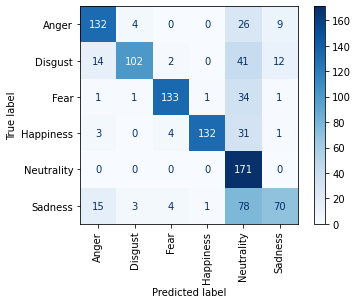

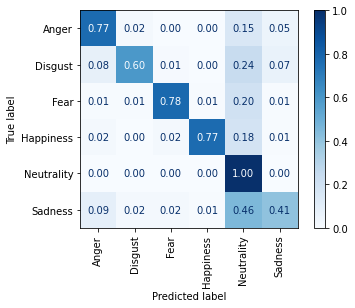

<Figure size 432x288 with 0 Axes>


1026
[[129   4   3   1  21  13]
 [ 33  59  18   5  22  34]
 [  2   1 137   5  20   6]
 [  0   0   6 156   7   2]
 [ 10   1   7   0 150   3]
 [ 23   3  29   4  49  63]]

accuracy:  0.6764132553606238
f1 score: [0.70108696 0.49372385 0.73854447 0.9122807  0.68181818 0.43150685]
f1 score weighted: 0.6598268355292153
---------------------------------------------------------
modelo_0 ES entrenado con el FACES evaluado con el test set del FACES


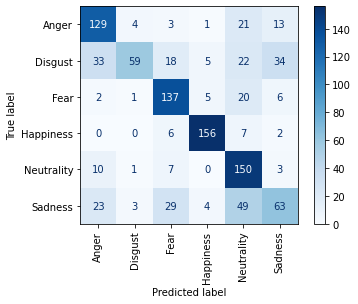

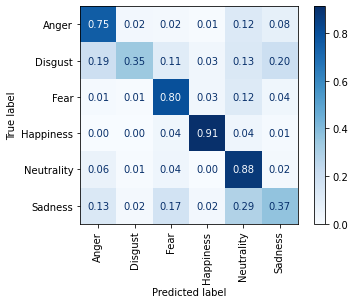

<Figure size 432x288 with 0 Axes>

In [ ]:
#Evaluamos los modelos con el FACES:
path='/content/gdrive/MyDrive/figures/modelo0'
title="modelo_0 50 epochs entrenado con el FACES evaluado con el test set del FACES"
plot_conf_matrix(FACES_test_set,model0_FACES,path,title,standard_format=True,percentages=True,save_plot=True)

path='/content/gdrive/MyDrive/figures/modelo0_ES'
title="modelo_0 ES entrenado con el FACES evaluado con el test set del FACES"
plot_conf_matrix(FACES_test_set,model0_FACES_ES,path,title,standard_format=True,percentages=True,save_plot=True)

356
[[ 7  4  2 59  3  1]
 [ 4  2  0 14  1  2]
 [ 8  6  0 20  3  8]
 [ 7 10  2 34  6  3]
 [15 13  0 33  8 13]
 [ 8  7  3 43  5  2]]

accuracy:  0.14887640449438203
f1 score: [0.112      0.06153846 0.         0.25660377 0.14814815 0.04123711]
f1 score weighted: 0.11457609673353124
---------------------------------------------------------
modelo_0 50 epochs entrenado con el FACES evaluado con el test set del FACES


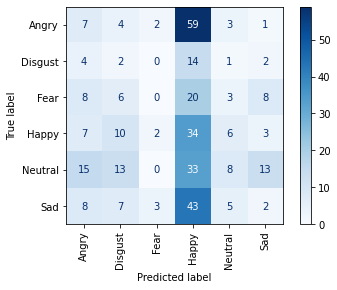

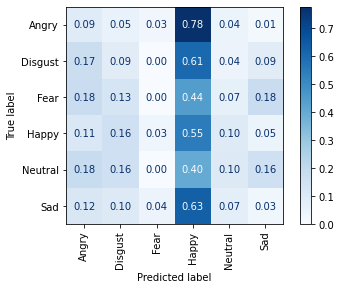

<Figure size 432x288 with 0 Axes>


356
[[19  0 32 25  0  0]
 [ 3  0  6 10  2  2]
 [ 8  0  9 23  3  2]
 [12  0 13 32  1  4]
 [ 8  0 33 32  3  6]
 [13  0 30 16  5  4]]

accuracy:  0.18820224719101122
f1 score: [0.27338129 0.         0.10714286 0.32       0.0625     0.09302326]
f1 score weighted: 0.15980052916866175
---------------------------------------------------------
modelo_0 ES entrenado con el FACES evaluado con el test set del FACES


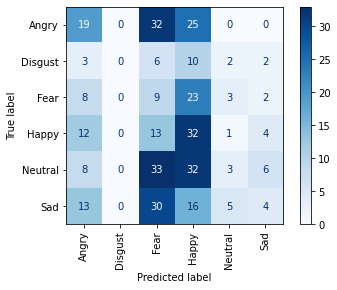

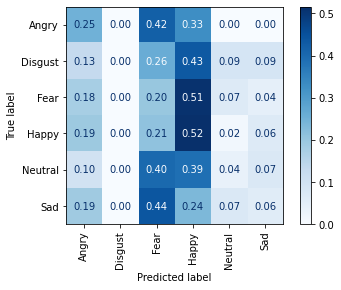

<Figure size 432x288 with 0 Axes>

In [ ]:
#Evaluamos los mismos modelos con el SFEW:

path='/content/gdrive/MyDrive/figures/modelo0'
title="modelo_0 50 epochs entrenado con el FACES evaluado con el test set del FACES"
plot_conf_matrix(SFEW_test_set,model0_FACES,path,title,standard_format=True,percentages=True,save_plot=True)

path='/content/gdrive/MyDrive/figures/modelo0_ES'
title="modelo_0 ES entrenado con el FACES evaluado con el test set del FACES"
plot_conf_matrix(SFEW_test_set,model0_FACES_ES,path,title,standard_format=True,percentages=True,save_plot=True)

In [ ]:
def compile_train_model(learning_rate,epochs,filepath,batch_size,model):
  optimizer = tf.keras.optimizers.SGD(lr=LR)

  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy', metrics=['accuracy','categorical_accuracy'])
  
  train_steps=int(len(train_set.labels)/batch_size)
  print(train_steps)
  test_steps=int(len(test_set.labels)/batch_size)
  print(test_steps)
  filepath=filepath+"2:{epoch:02d}-validation:{val_accuracy:.3f}-val_cat_acc:{val_categorical_accuracy:.3f}.hdf5"
  
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  Earlystopping=keras.callbacks.EarlyStopping(patience=20, monitor="val_accuracy",min_delta=0,verbose=0,mode="auto",baseline=None,restore_best_weights=True)

  # Wandb = WandbCallback()
  # tensorboard = keras.callbacks.TensorBoard(log_dir='./logs')
  # tf.keras.callbacks.TensorBoard(
  #     log_dir="logs",
  #     histogram_freq=5,
  #     write_graph=True,
  #     write_images=False,
  #     update_freq="epoch",
  #     profile_batch=2,
  #     embeddings_freq=0,
  #     embeddings_metadata=None)

  csv_logger = CSVLogger(filepath+'training.log')
  # callbacks_list = [checkpoint,csv_logger,Earlystopping]
  callbacks_list = [Earlystopping]

  hist=model.fit_generator(train_set,
                          steps_per_epoch =train_steps,
                          epochs = epochs,
                          validation_data = test_set,
                          validation_steps =test_steps,
                          callbacks=callbacks_list)
  print(hist)
  return hist,model

In [ ]:
def plot_model(history,title):
  plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  # plt.plot(history.history['val_categorical_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

  plt.title("model train and val accuracy "+title)
  # plt.show()
  
  plt.figure()
  plt.plot(history.history['val_accuracy'])
  plt.title("Validation accuracy " + title)

  plt.figure()
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title("Validation categorical accuracy"+title)
  # print(history.history.keys())

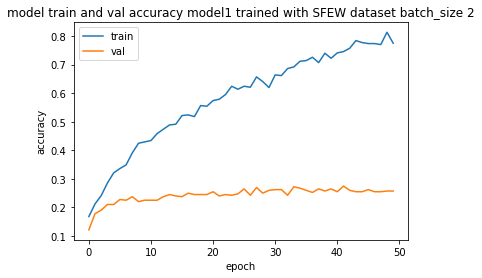

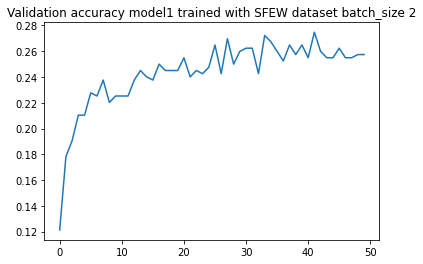

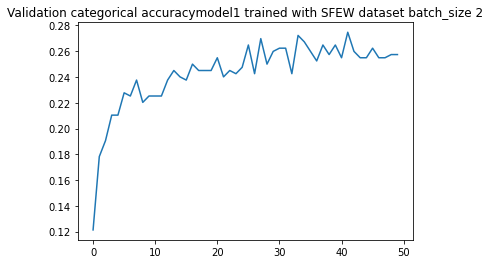

In [ ]:
plot_model(hist,"model1 trained with SFEW dataset batch_size 2")

In [ ]:
#Reentrenamos el modelo con el SFEW:

#1) Sin dataugmentation
HEIGHT,WIDTH=128,128  #143 x 181

train_data_dir = SFEW_train_dir
validation_data_dir = SFEW_test_dir
num_classes=6
dropout = 0.25
LR = 0.00001
epochs = 50
batch_size = 1
N_OUTPUT_LABELS=6
CHANNELS=1
dataugmentation=False
train_set=SFEW_train_set
test_set=SFEW_test_set

batch_size=2

for batch_size in batch_sz_list:
  # train_set,test_set=create_sets(dataugmentation,SFEW_train_dir,SFEW_test_dir,batch_size,classes_sfew[0:6])
  dir=""

  history_0=compile_train_model(LR, epochs ,dir, batch_size,model_0_ES)
  title="Arquitectura base entrenada con el SFEW "+str(batch_size)
  plot_model(history_0,title)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


766
356


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
766/766 [==============================] - 12s 13ms/step - loss: 2.8468 - accuracy: 0.2311 - categorical_accuracy: 0.2311 - val_loss: 2.2298 - val_accuracy: 0.2247 - val_categorical_accuracy: 0.2247
Epoch 2/50
766/766 [==============================] - 10s 13ms/step - loss: 1.9811 - accuracy: 0.3264 - categorical_accuracy: 0.3264 - val_loss: 2.0853 - val_accuracy: 0.2331 - val_categorical_accuracy: 0.2331
Epoch 3/50
766/766 [==============================] - 10s 13ms/step - loss: 1.7195 - accuracy: 0.3721 - categorical_accuracy: 0.3721 - val_loss: 2.0561 - val_accuracy: 0.2360 - val_categorical_accuracy: 0.2360
Epoch 4/50
766/766 [==============================] - 10s 13ms/step - loss: 1.5031 - accuracy: 0.4399 - categorical_accuracy: 0.4399 - val_loss: 2.0227 - val_accuracy: 0.2640 - val_categorical_accuracy: 0.2640
Epoch 5/50
766/766 [==============================] - 10s 13ms/step - loss: 1.4079 - accuracy: 0.4713 - categorical_accuracy: 0.4713 - val_loss: 2.0453 - val_ac

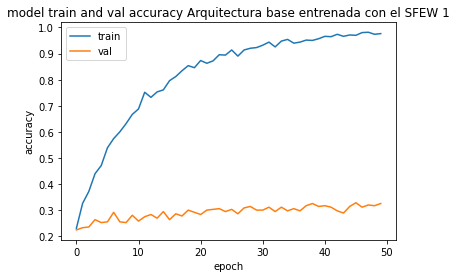

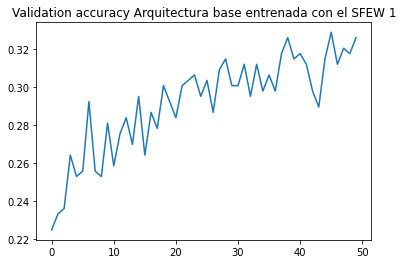

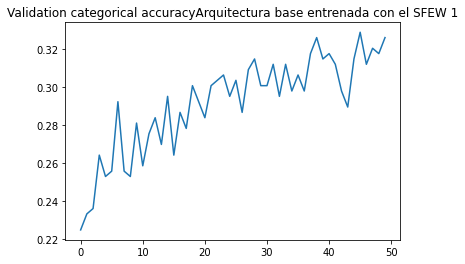

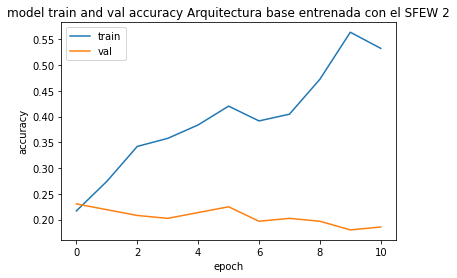

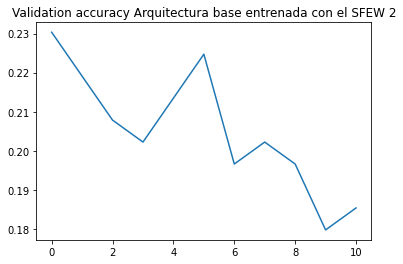

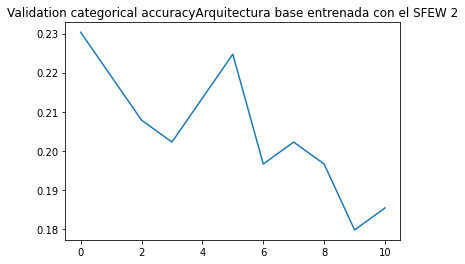

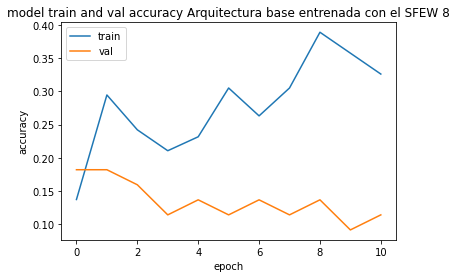

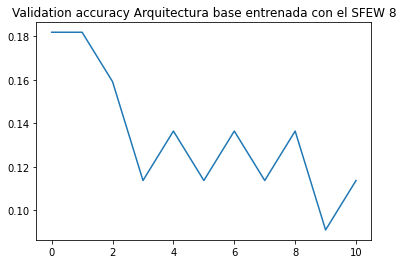

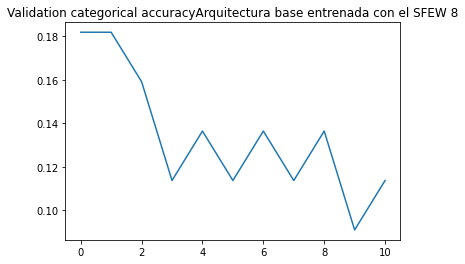

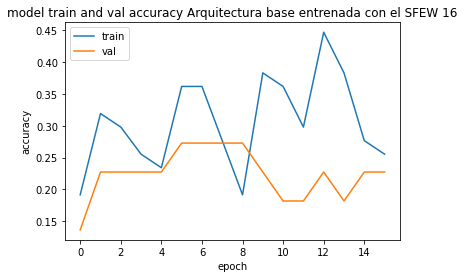

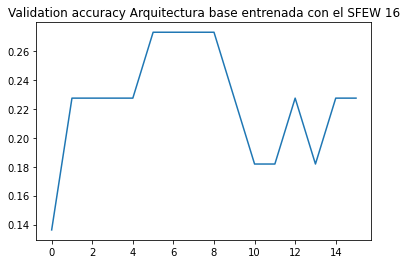

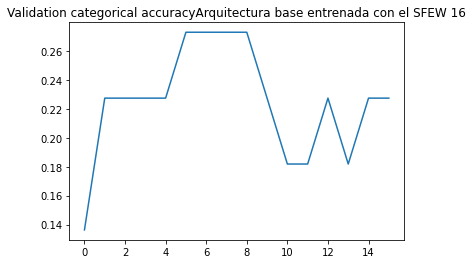

In [ ]:
#Reentrenamos el modelo con el SFEW:

#1) Sin dataugmentation
HEIGHT,WIDTH=128,128  #143 x 181

train_data_dir = SFEW_train_dir
validation_data_dir = SFEW_test_dir
num_classes=6
dropout = 0.25
LR = 0.00001
epochs = 50
batch_size = 1
N_OUTPUT_LABELS=6
CHANNELS=1
dataugmentation=False
train_set=SFEW_train_set
test_set=SFEW_test_set

batch_sz_list=[1,2,8,16]
for batch_size in batch_sz_list:
  # train_set,test_set=create_sets(dataugmentation,SFEW_train_dir,SFEW_test_dir,batch_size,classes_sfew[0:6])
  dir="/content/gdrive/MyDrive/TFM_MUSIcorrected_test/"
  model_0_ES=keras.models.load_model('/content/gdrive/MyDrive/saved_models/modelo_base_FACES_ES.h5') # modelo entrenado utilizando EarlyStopping
  history_0=compile_train_model(LR, epochs ,dir, batch_size,model_0_ES)
  title="Arquitectura base entrenada con el SFEW "+str(batch_size)
  plot_model(history_0,title)

# model_0_ES.save("/content/gdrive/MyDrive/saved_models/modelo_base0_SFEW_post_FACES.h5")




Found 766 images belonging to 6 classes.
Found 356 images belonging to 6 classes.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


766
356


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
766/766 [==============================] - 10s 13ms/step - loss: 2.7291 - accuracy: 0.2637 - categorical_accuracy: 0.2637 - val_loss: 2.0654 - val_accuracy: 0.2388 - val_categorical_accuracy: 0.2388
Epoch 2/50
766/766 [==============================] - 10s 13ms/step - loss: 2.2469 - accuracy: 0.2794 - categorical_accuracy: 0.2794 - val_loss: 2.0216 - val_accuracy: 0.2444 - val_categorical_accuracy: 0.2444
Epoch 3/50
766/766 [==============================] - 10s 13ms/step - loss: 1.9757 - accuracy: 0.3211 - categorical_accuracy: 0.3211 - val_loss: 2.0297 - val_accuracy: 0.2163 - val_categorical_accuracy: 0.2163
Epoch 4/50
766/766 [==============================] - 10s 13ms/step - loss: 1.8044 - accuracy: 0.3616 - categorical_accuracy: 0.3616 - val_loss: 1.9876 - val_accuracy: 0.2472 - val_categorical_accuracy: 0.2472
Epoch 5/50
766/766 [==============================] - 10s 13ms/step - loss: 1.7651 - accuracy: 0.3721 - categorical_accuracy: 0.3721 - val_loss: 1.9554 - val_ac

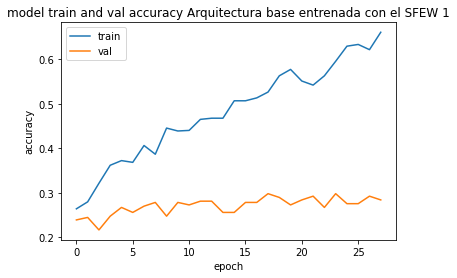

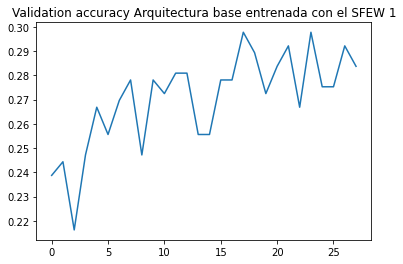

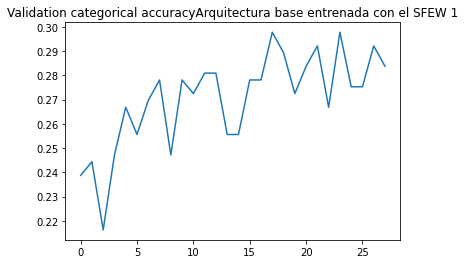

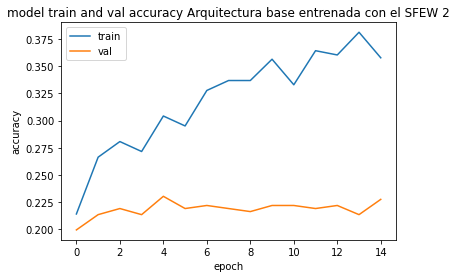

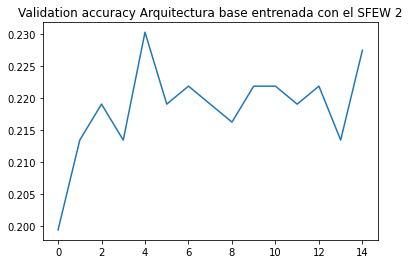

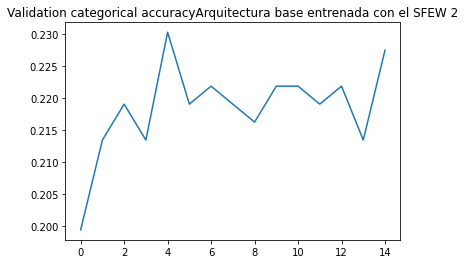

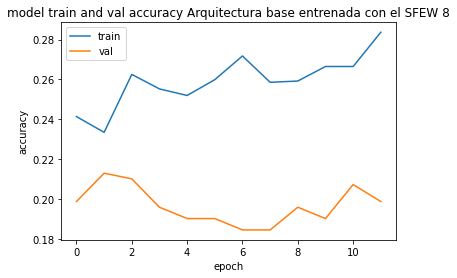

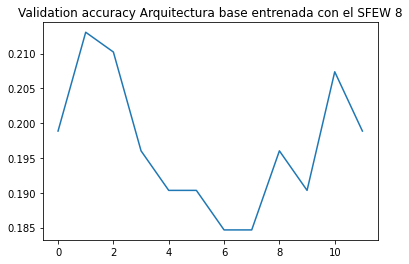

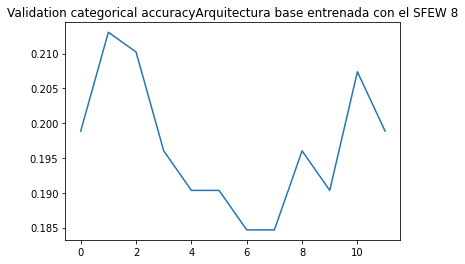

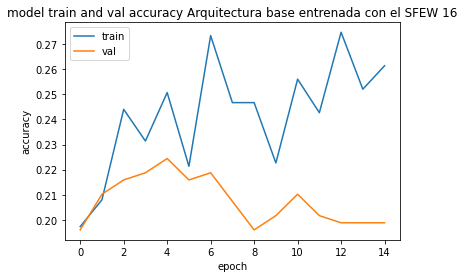

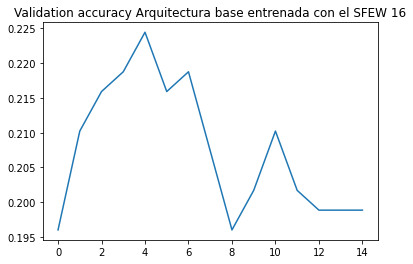

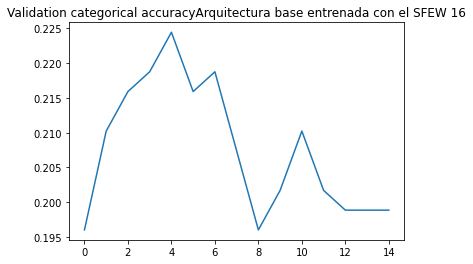

In [ ]:
#2) Con dataugmentation

dataugmentation=True
batch_size=1
train_set,test_set=create_sets(dataugmentation,SFEW_train_dir,SFEW_test_dir,batch_size,classes_sfew[0:6])

dir="/content/gdrive/MyDrive/TFM_MUSIcorrected_test/"
model_0_ES=keras.models.load_model('/content/gdrive/MyDrive/saved_models/modelo_base_FACES_ES.h5') # modelo entrenado utilizando EarlyStopping
history_0=compile_train_model(LR, epochs ,dir, batch_size,model_0_ES)
title="Arquitectura base entrenada con el SFEW "+str(batch_size)
plot_model(history_0,title)


dataugmentation=True
batch_size=2
train_set,test_set=create_sets(dataugmentation,SFEW_train_dir,SFEW_test_dir,batch_size,classes_sfew[0:6])

dir="/content/gdrive/MyDrive/TFM_MUSIcorrected_test/"
model_0_ES=keras.models.load_model('/content/gdrive/MyDrive/saved_models/modelo_base_FACES_ES.h5') # modelo entrenado utilizando EarlyStopping
history_0=compile_train_model(LR, epochs ,dir, batch_size,model_0_ES)
title="Arquitectura base entrenada con el SFEW "+str(batch_size)
plot_model(history_0,title)


dataugmentation=True
batch_size=8
train_set,test_set=create_sets(dataugmentation,SFEW_train_dir,SFEW_test_dir,batch_size,classes_sfew[0:6])

dir="/content/gdrive/MyDrive/TFM_MUSIcorrected_test/"
model_0_ES=keras.models.load_model('/content/gdrive/MyDrive/saved_models/modelo_base_FACES_ES.h5') # modelo entrenado utilizando EarlyStopping
history_0=compile_train_model(LR, epochs ,dir, batch_size,model_0_ES)
title="Arquitectura base entrenada con el SFEW "+str(batch_size)
plot_model(history_0,title)

dataugmentation=True
batch_size=16
train_set,test_set=create_sets(dataugmentation,SFEW_train_dir,SFEW_test_dir,batch_size,classes_sfew[0:6])

dir="/content/gdrive/MyDrive/TFM_MUSIcorrected_test/"
model_0_ES=keras.models.load_model('/content/gdrive/MyDrive/saved_models/modelo_base_FACES_ES.h5') # modelo entrenado utilizando EarlyStopping
history_0=compile_train_model(LR, epochs ,dir, batch_size,model_0_ES)
title="Arquitectura base entrenada con el SFEW "+str(batch_size)
plot_model(history_0,title)

In [ ]:
-----------------------

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
859/859 [==============================] - 13s 13ms/step - loss: 3.0744 - accuracy: 0.2130 - categorical_accuracy: 0.2130 - val_loss: 2.2541 - val_accuracy: 0.1506 - val_categorical_accuracy: 0.1506
Epoch 2/50
859/859 [==============================] - 11s 12ms/step - loss: 2.3444 - accuracy: 0.2969 - categorical_accuracy: 0.2969 - val_loss: 2.1837 - val_accuracy: 0.1827 - val_categorical_accuracy: 0.1827
Epoch 3/50
859/859 [==============================] - 11s 12ms/step - loss: 2.0230 - accuracy: 0.3551 - categorical_accuracy: 0.3551 - val_loss: 2.1780 - val_accuracy: 0.1877 - val_categorical_accuracy: 0.1877
Epoch 4/50
859/859 [==============================] - 11s 12ms/step - loss: 1.7597 - accuracy: 0.4133 - categorical_accuracy: 0.4133 - val_loss: 2.1932 - val_accuracy: 0.1802 - val_categorical_accuracy: 0.1802
Epoch 5/50
859/859 [==============================] - 11s 13ms/step - loss: 1.5325 - accuracy: 0.4692 - categorical_accuracy: 0.4692 - val_loss: 2.1388 - val_ac

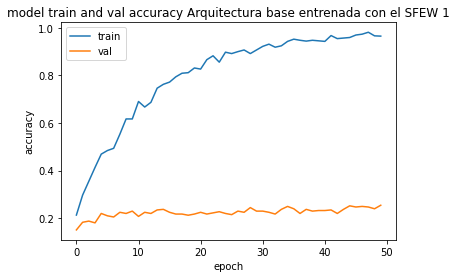

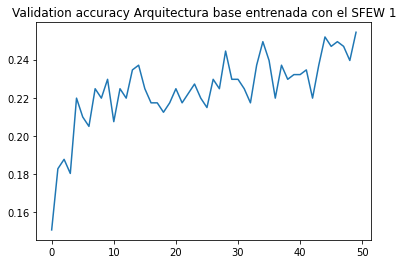

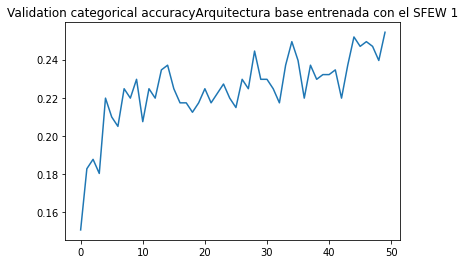

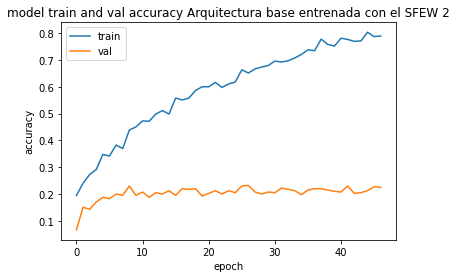

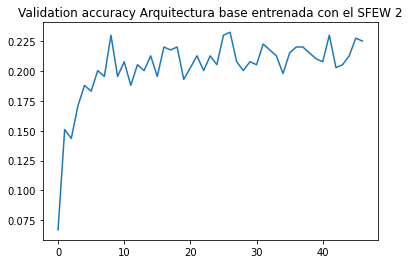

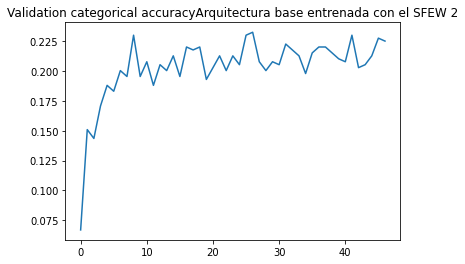

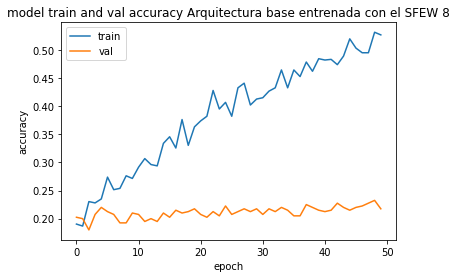

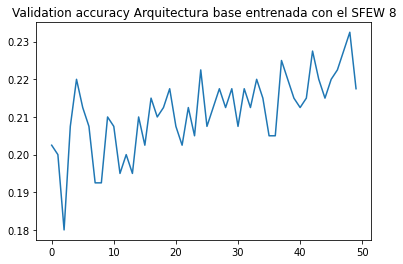

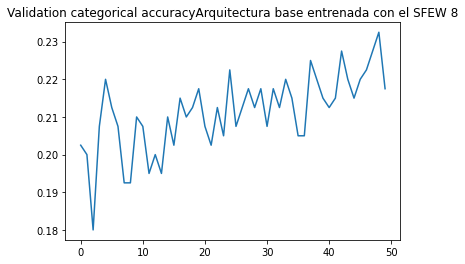

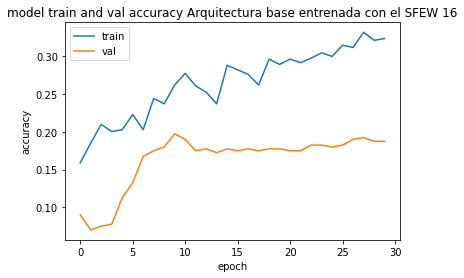

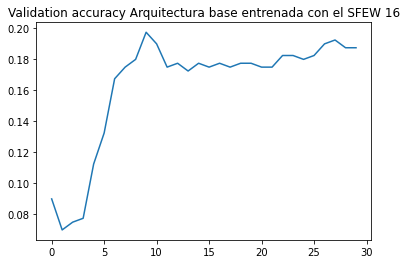

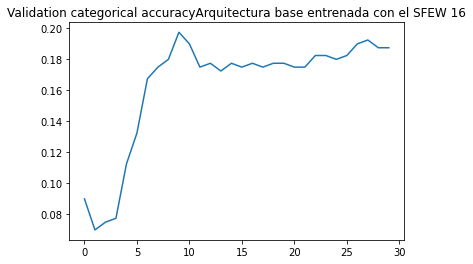

In [ ]:
#Reentrenamos el modelo con el SFEW y las 7 emociones:

HEIGHT,WIDTH=128,128  #143 x 181

train_data_dir = SFEW_train_dir
validation_data_dir = SFEW_test_dir
num_classes=7
dropout = 0.25
LR = 0.00001
epochs = 50
batch_size = 1
N_OUTPUT_LABELS=6
CHANNELS=1
dataugmentation=False
optimizer = tf.keras.optimizers.SGD(lr=LR)
classes_sfew=["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]


batch_sz_list=[1,2,8,16]
for batch_size in batch_sz_list:

  dir="/content/gdrive/MyDrive/TFM_MUSIcorrected_test/"
  SFEW_train_set,SFEW_test_set=create_sets(dataugmentation,SFEW_train_dir,SFEW_test_dir,batch_size,classes_sfew)
  model=CNNmodel()
  model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy','categorical_accuracy'])
  train_steps=int(len(SFEW_train_set.labels)/batch_size)
  test_steps=int(len(SFEW_test_set.labels)/batch_size)
  # checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  Earlystopping=keras.callbacks.EarlyStopping(patience=10, monitor="val_accuracy",min_delta=0,verbose=0,mode="auto",baseline=None,restore_best_weights=True)
  callbacks_list = [Earlystopping]

  hist=model.fit_generator(SFEW_train_set,
                          steps_per_epoch =train_steps,
                          epochs = epochs,
                          validation_data = SFEW_test_set,
                          validation_steps =test_steps,
                          callbacks=Earlystopping)

  title="Arquitectura base entrenada con el SFEW "+str(batch_size)
  plot_model(hist,title)


In [ ]:
def CNNmodel():
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), 
                     input_shape = ( img_height, img_width,1), 
                     activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))#--
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3),activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout*2))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    return model

model=CNNmodel()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
429/429 [==============================] - 38s 18ms/step - loss: 3.2140 - accuracy: 0.1680 - categorical_accuracy: 0.1680 - val_loss: 2.1360 - val_accuracy: 0.1213 - val_categorical_accuracy: 0.1213
Epoch 2/50
429/429 [==============================] - 7s 17ms/step - loss: 2.8732 - accuracy: 0.2124 - categorical_accuracy: 0.2124 - val_loss: 2.2483 - val_accuracy: 0.1782 - val_categorical_accuracy: 0.1782
Epoch 3/50
429/429 [==============================] - 8s 17ms/step - loss: 2.5811 - accuracy: 0.2415 - categorical_accuracy: 0.2415 - val_loss: 2.1926 - val_accuracy: 0.1906 - val_categorical_accuracy: 0.1906
Epoch 4/50
429/429 [==============================] - 7s 17ms/step - loss: 2.3165 - accuracy: 0.2859 - categorical_accuracy: 0.2859 - val_loss: 2.1756 - val_accuracy: 0.2104 - val_categorical_accuracy: 0.2104
Epoch 5/50
429/429 [==============================] - 7s 17ms/step - loss: 2.0920 - accuracy: 0.3209 - categorical_accuracy: 0.3209 - val_loss: 2.1726 - val_accura

NameError: ignored

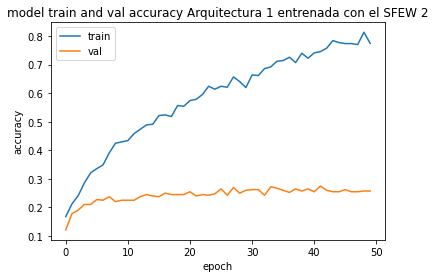

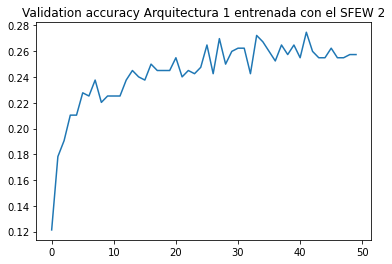

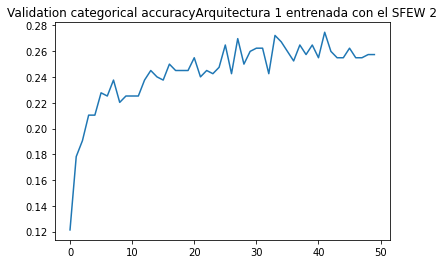

In [ ]:
HEIGHT,WIDTH=128,128  #143 x 181

train_data_dir = SFEW_train_dir
validation_data_dir = SFEW_test_dir
num_classes=7
dropout = 0.25
LR = 0.00001
epochs = 50
batch_size = 2
N_OUTPUT_LABELS=7
CHANNELS=1
dataugmentation=False
optimizer = tf.keras.optimizers.SGD(lr=LR)
classes_sfew=["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

batch_size=2

dir="/content/gdrive/MyDrive/TFM_MUSIcorrected_test/"
SFEW_train_set,SFEW_test_set=create_sets(dataugmentation,SFEW_train_dir,SFEW_test_dir,batch_size,classes_sfew)
model=CNNmodel()
model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy','categorical_accuracy'])
train_steps=int(len(SFEW_train_set.labels)/batch_size)
test_steps=int(len(SFEW_test_set.labels)/batch_size)
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
Earlystopping=keras.callbacks.EarlyStopping(patience=15, monitor="val_accuracy",min_delta=0,verbose=0,mode="auto",baseline=None,restore_best_weights=True)
callbacks_list = [Earlystopping]

hist=model.fit_generator(SFEW_train_set,
                        steps_per_epoch =train_steps,
                        epochs = epochs,
                        validation_data = SFEW_test_set,
                        validation_steps =test_steps,
                        callbacks=Earlystopping)

title="Arquitectura 1 entrenada con el SFEW "+str(batch_size)
plot_model(hist,title)
path=""
figure_path=path+"Arq1_batch_"+str(batch_size)
plot_conf_matrix(SFEW_test_set,model,figure_path,title,standard_format=True,percentages=True,save_plot=True)

405
[[31  6  0  9 13  2 15]
 [10  1  0  1  6  1  4]
 [20  3  0  3  3  2 14]
 [15  3  0 20 12  2 10]
 [15  4  1  5 28  3 26]
 [20  5  0  8 15  5 15]
 [11  1  1  4  7  5 20]]

accuracy:  0.25925925925925924
f1 score: [0.31313131 0.04347826 0.         0.35714286 0.3373494  0.11363636
 0.26143791]
f1 score weighted: 0.23491658712804733
---------------------------------------------------------
Arquitectura 1 entrenada con el SFEW 2


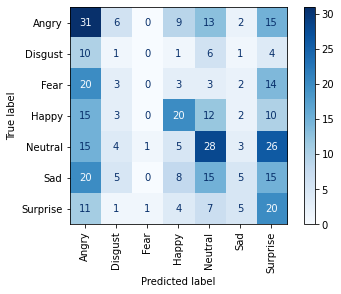

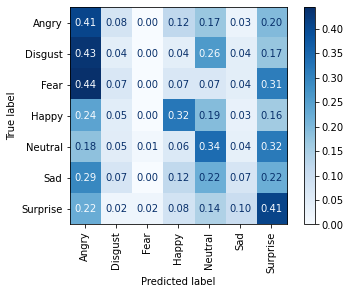

<Figure size 432x288 with 0 Axes>

In [ ]:
#Resultado al pdf
path=""
figure_path=path+"Arq1_batch_"+str(batch_size)
plot_conf_matrix(SFEW_test_set,model,figure_path,title,standard_format=True,percentages=True,save_plot=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
429/429 [==============================] - 38s 18ms/step - loss: 3.0949 - accuracy: 0.2007 - categorical_accuracy: 0.2007 - val_loss: 2.1874 - val_accuracy: 0.1460 - val_categorical_accuracy: 0.1460
Epoch 2/50
429/429 [==============================] - 8s 18ms/step - loss: 2.9306 - accuracy: 0.1925 - categorical_accuracy: 0.1925 - val_loss: 2.2793 - val_accuracy: 0.1658 - val_categorical_accuracy: 0.1658
Epoch 3/50
429/429 [==============================] - 8s 18ms/step - loss: 2.7887 - accuracy: 0.1960 - categorical_accuracy: 0.1960 - val_loss: 2.2782 - val_accuracy: 0.1634 - val_categorical_accuracy: 0.1634
Epoch 4/50
429/429 [==============================] - 8s 18ms/step - loss: 2.5213 - accuracy: 0.2544 - categorical_accuracy: 0.2544 - val_loss: 2.1989 - val_accuracy: 0.1832 - val_categorical_accuracy: 0.1832
Epoch 5/50
429/429 [==============================] - 8s 18ms/step - loss: 2.4502 - accuracy: 0.2462 - categorical_accuracy: 0.2462 - val_loss: 2.2252 - val_accura

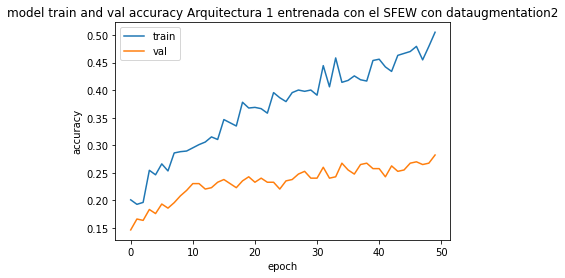

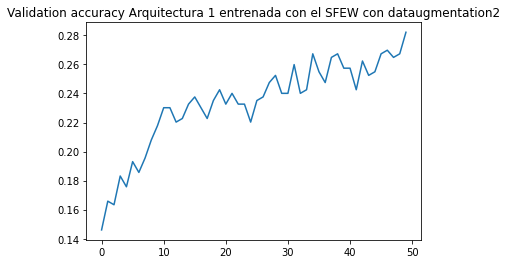

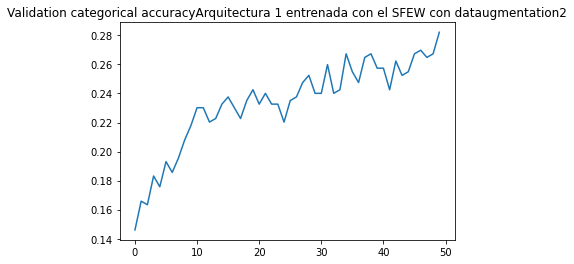

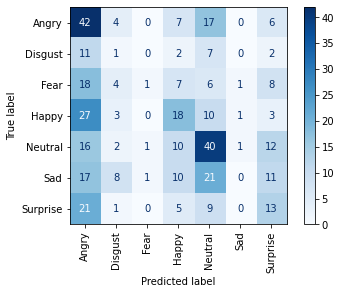

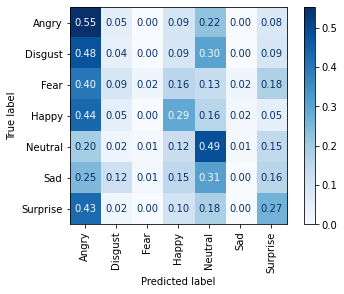

<Figure size 432x288 with 0 Axes>

In [ ]:
#misma prueba con dataugmentation

HEIGHT,WIDTH=128,128  #143 x 181

train_data_dir = SFEW_train_dir
validation_data_dir = SFEW_test_dir
num_classes=7
dropout = 0.25
LR = 0.00001
epochs = 50
batch_size = 2
N_OUTPUT_LABELS=7
CHANNELS=1
dataugmentation=True
optimizer = tf.keras.optimizers.SGD(lr=LR)
classes_sfew=["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
path=""
batch_size=2

dir="/content/gdrive/MyDrive/TFM_MUSIcorrected_test/"
SFEW_train_set,SFEW_test_set=create_sets(dataugmentation,SFEW_train_dir,SFEW_test_dir,batch_size,classes_sfew)
model=CNNmodel()
model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy','categorical_accuracy'])
train_steps=int(len(SFEW_train_set.labels)/batch_size)
test_steps=int(len(SFEW_test_set.labels)/batch_size)
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
Earlystopping=keras.callbacks.EarlyStopping(patience=15, monitor="val_accuracy",min_delta=0,verbose=0,mode="auto",baseline=None,restore_best_weights=True)
callbacks_list = [Earlystopping]

hist=model.fit_generator(SFEW_train_set,
                        steps_per_epoch =train_steps,
                        epochs = epochs,
                        validation_data = SFEW_test_set,
                        validation_steps =test_steps,
                        callbacks=Earlystopping)

title="Arquitectura 1 entrenada con el SFEW con dataugmentation"+str(batch_size)
plot_model(hist,title)

figure_path=path+"Arq1_batch_"+str(batch_size)
plot_conf_matrix(SFEW_test_set,model,figure_path,title,standard_format=True,percentages=True,save_plot=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
429/429 [==============================] - 9s 19ms/step - loss: 3.3423 - accuracy: 0.1459 - categorical_accuracy: 0.1459 - val_loss: 2.2453 - val_accuracy: 0.1262 - val_categorical_accuracy: 0.1262
Epoch 2/50
429/429 [==============================] - 8s 18ms/step - loss: 2.9376 - accuracy: 0.1832 - categorical_accuracy: 0.1832 - val_loss: 2.2925 - val_accuracy: 0.1386 - val_categorical_accuracy: 0.1386
Epoch 3/50
429/429 [==============================] - 8s 18ms/step - loss: 2.7019 - accuracy: 0.1890 - categorical_accuracy: 0.1890 - val_loss: 2.2810 - val_accuracy: 0.1460 - val_categorical_accuracy: 0.1460
Epoch 4/50
429/429 [==============================] - 8s 18ms/step - loss: 2.5889 - accuracy: 0.2112 - categorical_accuracy: 0.2112 - val_loss: 2.2678 - val_accuracy: 0.1683 - val_categorical_accuracy: 0.1683
Epoch 5/50
429/429 [==============================] - 8s 18ms/step - loss: 2.5591 - accuracy: 0.1867 - categorical_accuracy: 0.1867 - val_loss: 2.2663 - val_accurac

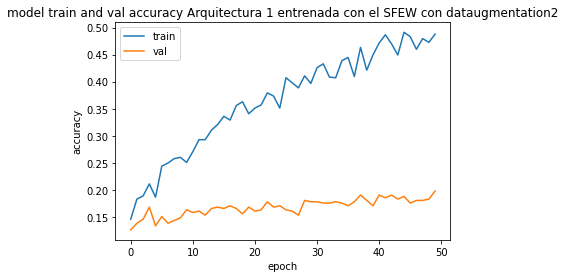

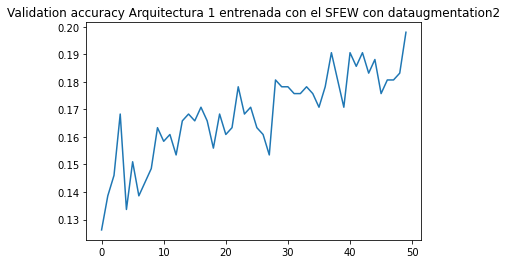

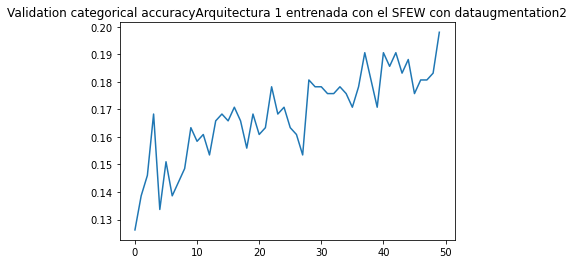

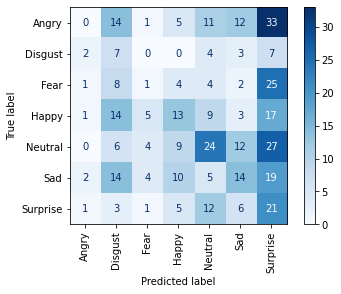

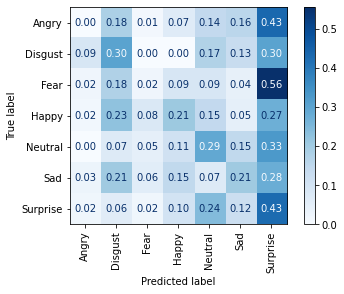

<Figure size 432x288 with 0 Axes>

In [ ]:
#test weight balancing 
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(SFEW_train_set.classes), 
            SFEW_train_set.classes)
class_weights
indices=[0,1,2,3,4,5,6]
class_weight_dict=dict(zip(indices,class_weights))
class_weight_dict

HEIGHT,WIDTH=128,128  #143 x 181

train_data_dir = SFEW_train_dir
validation_data_dir = SFEW_test_dir
num_classes=7
dropout = 0.25
LR = 0.00001
epochs = 50
batch_size = 2
N_OUTPUT_LABELS=7
CHANNELS=1
dataugmentation=True
optimizer = tf.keras.optimizers.SGD(lr=LR)
classes_sfew=["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
path=""
batch_size=2

dir="/content/gdrive/MyDrive/TFM_MUSIcorrected_test/"
SFEW_train_set,SFEW_test_set=create_sets(dataugmentation,SFEW_train_dir,SFEW_test_dir,batch_size,classes_sfew)
model=CNNmodel()
model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy','categorical_accuracy'])
train_steps=int(len(SFEW_train_set.labels)/batch_size)
test_steps=int(len(SFEW_test_set.labels)/batch_size)
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
Earlystopping=keras.callbacks.EarlyStopping(patience=15, monitor="val_accuracy",min_delta=0,verbose=0,mode="auto",baseline=None,restore_best_weights=True)
callbacks_list = [Earlystopping]

hist=model.fit_generator(SFEW_train_set,
                        steps_per_epoch =train_steps,
                        epochs = epochs,
                        validation_data = SFEW_test_set,
                        validation_steps =test_steps,
                        class_weight=class_weight_dict,
                        callbacks=Earlystopping)

title="Arquitectura 1 entrenada con el SFEW con dataugmentation"+str(batch_size)
plot_model(hist,title)

figure_path=path+"Arq1_batch_"+str(batch_size)
plot_conf_matrix(SFEW_test_set,model,figure_path,title,standard_format=True,percentages=True,save_plot=True)

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(SFEW_train_set.classes), 
            SFEW_train_set.classes)
class_weights
indices=[0,1,2,3,4,5,6]
class_weight_dict=dict(zip(indices,class_weights))
class_weight_dict

{0: 0.7134551495016611,
 1: 2.5043731778425657,
 2: 1.6146616541353382,
 3: 0.6972402597402597,
 4: 0.864185110663984,
 5: 0.8126773888363292,
 6: 1.3195084485407067}

-------------------------------------
lr:  1e-05
batch_size:  1
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
859/859 [==============================] - 42s 14ms/step - loss: 3.2497 - accuracy: 0.1874 - categorical_accuracy: 0.1874 - val_loss: 2.3400 - val_accuracy: 0.1778 - val_categorical_accuracy: 0.1778
Epoch 2/50
859/859 [==============================] - 12s 13ms/step - loss: 2.7779 - accuracy: 0.2084 - categorical_accuracy: 0.2084 - val_loss: 2.3702 - val_accuracy: 0.1728 - val_categorical_accuracy: 0.1728
Epoch 3/50
859/859 [==============================] - 11s 13ms/step - loss: 2.4958 - accuracy: 0.2480 - categorical_accuracy: 0.2480 - val_loss: 2.3264 - val_accuracy: 0.1852 - val_categorical_accuracy: 0.1852
Epoch 4/50
859/859 [==============================] - 12s 13ms/step - loss: 2.2221 - accuracy: 0.2736 - categorical_accuracy: 0.2736 - val_loss: 2.2827 - val_accuracy: 0.1951 - val_categorical_accuracy: 0.1951
Epoch 5/50
859/859 [==============================] - 11s 13ms/step - loss: 2.0295 - accuracy: 0.3329 - categorical_accuracy: 0.3329 - val_loss: 2.3559 - val_ac

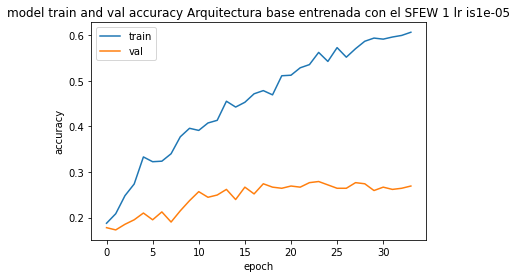

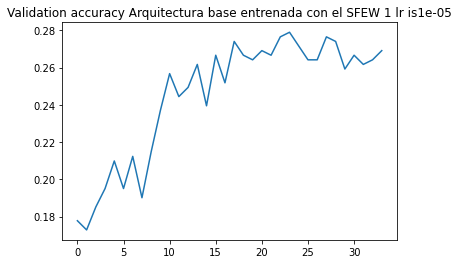

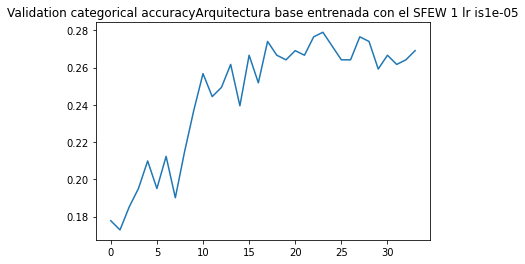

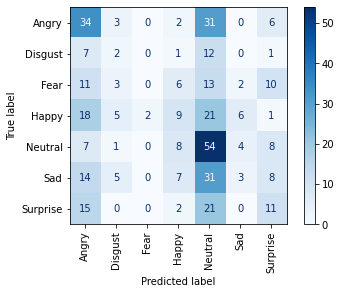

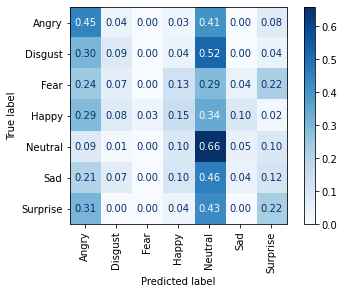

<Figure size 432x288 with 0 Axes>


-------------------------------------
lr:  0.0001
batch_size:  1
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
Epoch 1/50
859/859 [==============================] - 13s 14ms/step - loss: 3.2046 - accuracy: 0.1816 - categorical_accuracy: 0.1816 - val_loss: 2.3231 - val_accuracy: 0.1556 - val_categorical_accuracy: 0.1556
Epoch 2/50
859/859 [==============================] - 12s 14ms/step - loss: 2.6585 - accuracy: 0.2224 - categorical_accuracy: 0.2224 - val_loss: 2.3164 - val_accuracy: 0.1679 - val_categorical_accuracy: 0.1679
Epoch 3/50
859/859 [==============================] - 12s 14ms/step - loss: 2.3860 - accuracy: 0.2468 - categorical_accuracy: 0.2468 - val_loss: 2.3138 - val_accuracy: 0.1605 - val_categorical_accuracy: 0.1605
Epoch 4/50
859/859 [==============================] - 12s 14ms/step - loss: 2.1666 - accuracy: 0.2922 - categorical_accuracy: 0.2922 - val_loss: 2.3321 - val_accuracy: 0.1679 - val_categorical_accuracy: 0.1679
Epoch 5/50
8

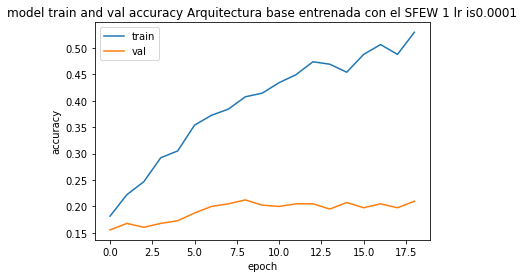

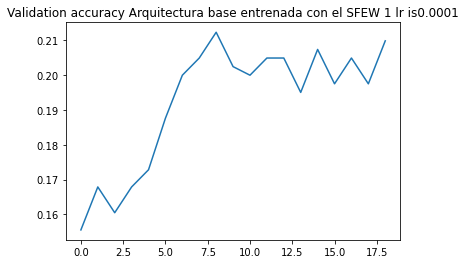

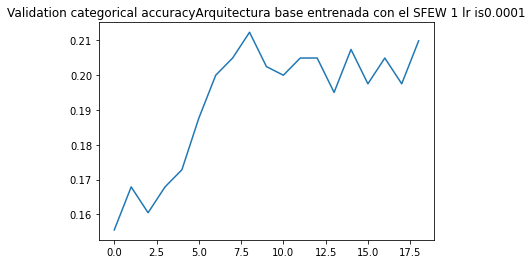

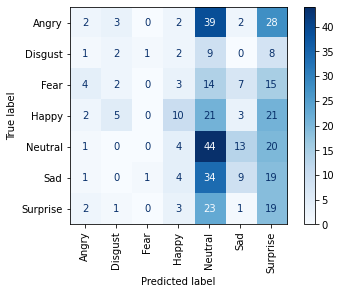

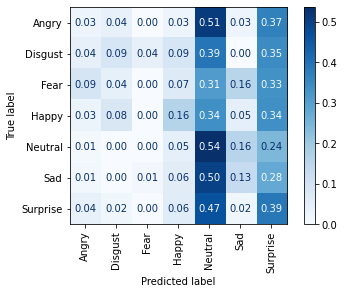

<Figure size 432x288 with 0 Axes>


-------------------------------------
lr:  0.001
batch_size:  1
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
Epoch 1/50
859/859 [==============================] - 13s 14ms/step - loss: 3.2962 - accuracy: 0.1874 - categorical_accuracy: 0.1874 - val_loss: 1.9975 - val_accuracy: 0.2321 - val_categorical_accuracy: 0.2321
Epoch 2/50
859/859 [==============================] - 12s 14ms/step - loss: 2.6888 - accuracy: 0.2526 - categorical_accuracy: 0.2526 - val_loss: 1.9782 - val_accuracy: 0.2395 - val_categorical_accuracy: 0.2395
Epoch 3/50
859/859 [==============================] - 12s 14ms/step - loss: 2.4126 - accuracy: 0.2573 - categorical_accuracy: 0.2573 - val_loss: 1.9722 - val_accuracy: 0.2617 - val_categorical_accuracy: 0.2617
Epoch 4/50
859/859 [==============================] - 12s 14ms/step - loss: 2.1765 - accuracy: 0.2934 - categorical_accuracy: 0.2934 - val_loss: 1.9761 - val_accuracy: 0.2667 - val_categorical_accuracy: 0.2667
Epoch 5/50
85

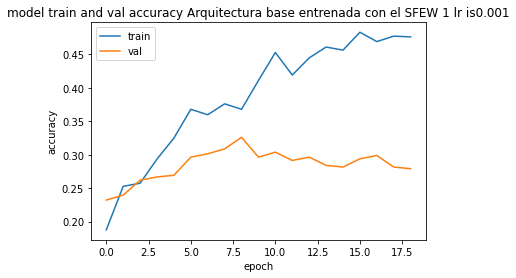

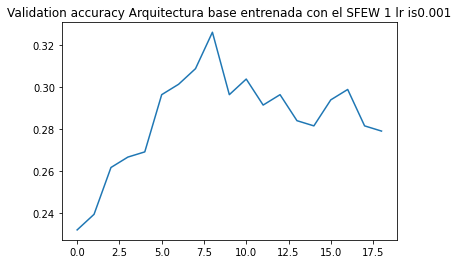

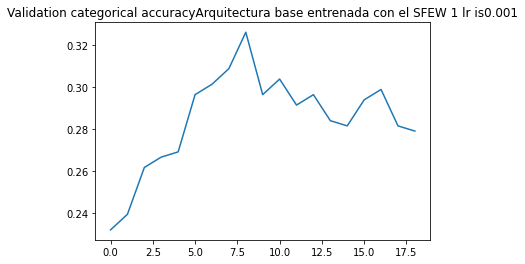

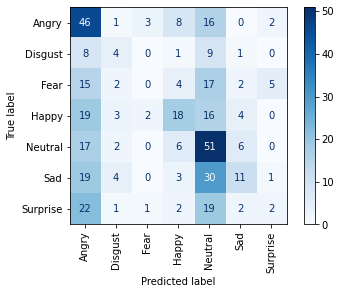

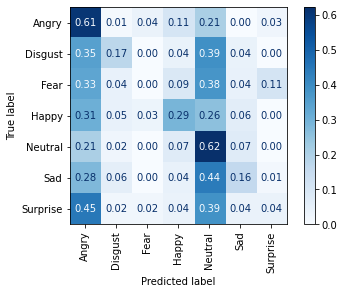

<Figure size 432x288 with 0 Axes>


-------------------------------------
lr:  0.01
batch_size:  1
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
Epoch 1/50
859/859 [==============================] - 13s 15ms/step - loss: 3.0979 - accuracy: 0.2258 - categorical_accuracy: 0.2258 - val_loss: 2.5252 - val_accuracy: 0.0914 - val_categorical_accuracy: 0.0914
Epoch 2/50
859/859 [==============================] - 12s 14ms/step - loss: 2.7209 - accuracy: 0.2491 - categorical_accuracy: 0.2491 - val_loss: 2.4472 - val_accuracy: 0.1160 - val_categorical_accuracy: 0.1160
Epoch 3/50
859/859 [==============================] - 12s 14ms/step - loss: 2.3652 - accuracy: 0.2736 - categorical_accuracy: 0.2736 - val_loss: 2.4331 - val_accuracy: 0.1284 - val_categorical_accuracy: 0.1284
Epoch 4/50
859/859 [==============================] - 12s 14ms/step - loss: 2.2418 - accuracy: 0.2829 - categorical_accuracy: 0.2829 - val_loss: 2.3997 - val_accuracy: 0.1728 - val_categorical_accuracy: 0.1728
Epoch 5/50
859

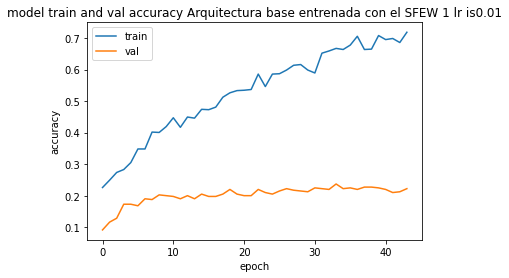

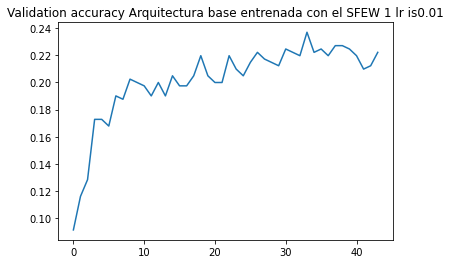

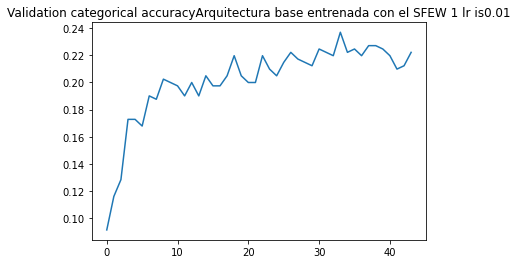

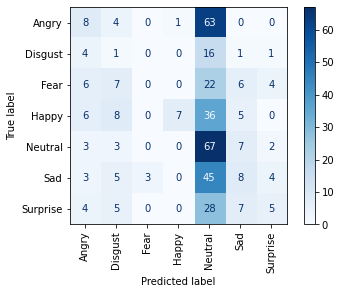

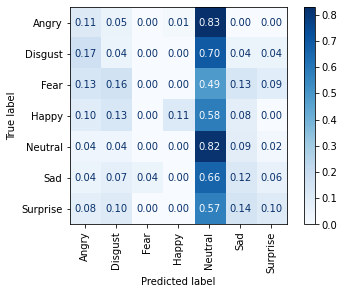

<Figure size 432x288 with 0 Axes>


-------------------------------------
lr:  1e-05
batch_size:  2
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
Epoch 1/50
429/429 [==============================] - 10s 21ms/step - loss: 3.2480 - accuracy: 0.1890 - categorical_accuracy: 0.1890 - val_loss: 2.2679 - val_accuracy: 0.1188 - val_categorical_accuracy: 0.1188
Epoch 2/50
429/429 [==============================] - 9s 20ms/step - loss: 2.8267 - accuracy: 0.2159 - categorical_accuracy: 0.2159 - val_loss: 2.2668 - val_accuracy: 0.1287 - val_categorical_accuracy: 0.1287
Epoch 3/50
429/429 [==============================] - 9s 20ms/step - loss: 2.6383 - accuracy: 0.2299 - categorical_accuracy: 0.2299 - val_loss: 2.2200 - val_accuracy: 0.1510 - val_categorical_accuracy: 0.1510
Epoch 4/50
429/429 [==============================] - 9s 20ms/step - loss: 2.4142 - accuracy: 0.2579 - categorical_accuracy: 0.2579 - val_loss: 2.2198 - val_accuracy: 0.1658 - val_categorical_accuracy: 0.1658
Epoch 5/50
429/4

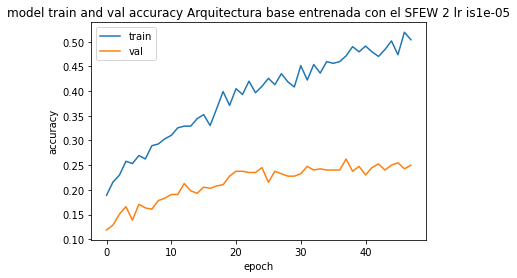

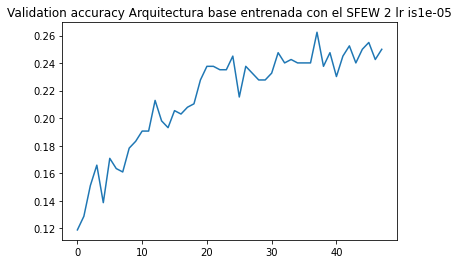

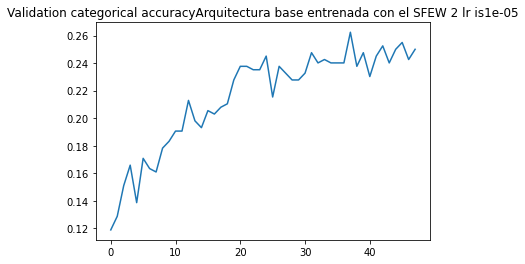

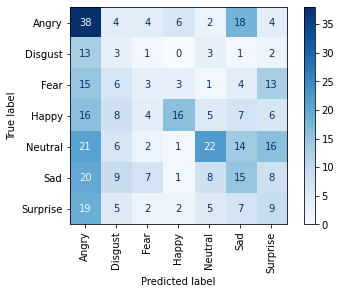

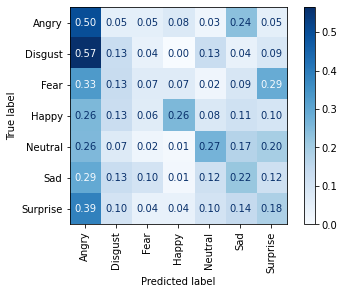

<Figure size 432x288 with 0 Axes>


-------------------------------------
lr:  0.0001
batch_size:  2
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
Epoch 1/50
429/429 [==============================] - 10s 22ms/step - loss: 3.0833 - accuracy: 0.2089 - categorical_accuracy: 0.2089 - val_loss: 2.1562 - val_accuracy: 0.1163 - val_categorical_accuracy: 0.1163
Epoch 2/50
429/429 [==============================] - 9s 21ms/step - loss: 2.8101 - accuracy: 0.1972 - categorical_accuracy: 0.1972 - val_loss: 2.2140 - val_accuracy: 0.1188 - val_categorical_accuracy: 0.1188
Epoch 3/50
429/429 [==============================] - 9s 21ms/step - loss: 2.5703 - accuracy: 0.2249 - categorical_accuracy: 0.2249 - val_loss: 2.1783 - val_accuracy: 0.1485 - val_categorical_accuracy: 0.1485
Epoch 4/50
429/429 [==============================] - 9s 21ms/step - loss: 2.6168 - accuracy: 0.1972 - categorical_accuracy: 0.1972 - val_loss: 2.1695 - val_accuracy: 0.1584 - val_categorical_accuracy: 0.1584
Epoch 5/50
429/

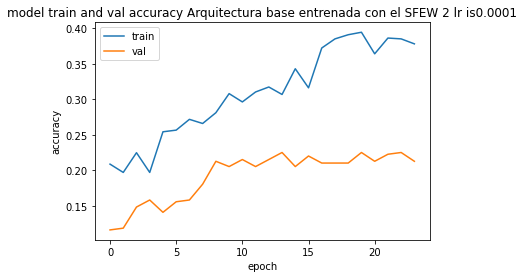

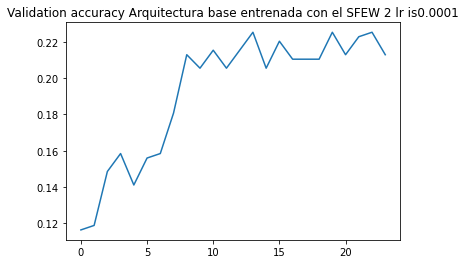

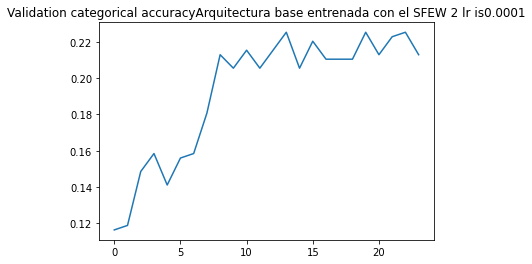

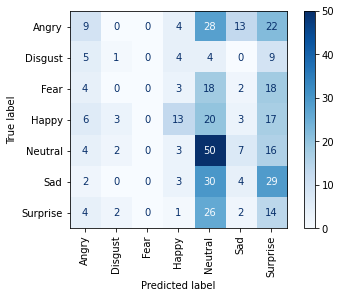

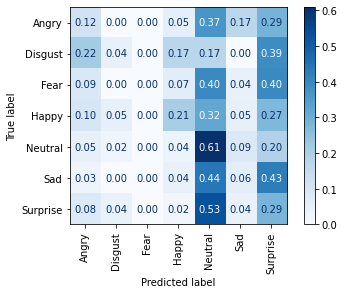

<Figure size 432x288 with 0 Axes>


-------------------------------------
lr:  0.001
batch_size:  2
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
Epoch 1/50
429/429 [==============================] - 10s 22ms/step - loss: 3.2010 - accuracy: 0.1820 - categorical_accuracy: 0.1820 - val_loss: 2.2770 - val_accuracy: 0.0594 - val_categorical_accuracy: 0.0594
Epoch 2/50
429/429 [==============================] - 9s 21ms/step - loss: 2.9651 - accuracy: 0.1820 - categorical_accuracy: 0.1820 - val_loss: 2.1654 - val_accuracy: 0.1337 - val_categorical_accuracy: 0.1337
Epoch 3/50
429/429 [==============================] - 9s 21ms/step - loss: 2.7049 - accuracy: 0.2159 - categorical_accuracy: 0.2159 - val_loss: 2.1643 - val_accuracy: 0.1634 - val_categorical_accuracy: 0.1634
Epoch 4/50
429/429 [==============================] - 9s 21ms/step - loss: 2.5793 - accuracy: 0.2369 - categorical_accuracy: 0.2369 - val_loss: 2.1796 - val_accuracy: 0.1485 - val_categorical_accuracy: 0.1485
Epoch 5/50
429/4

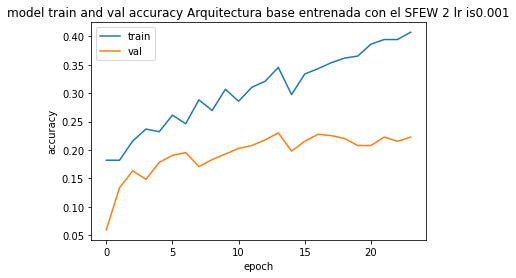

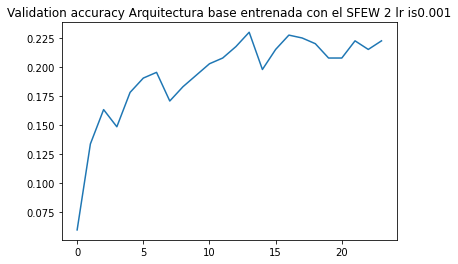

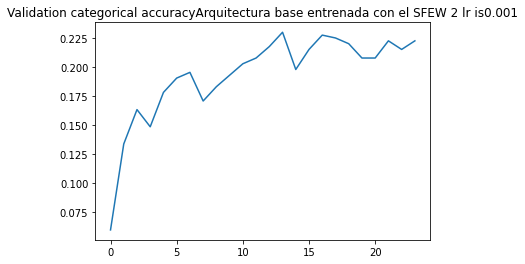

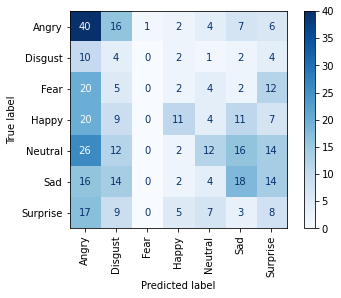

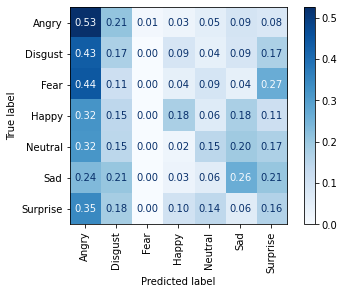

<Figure size 432x288 with 0 Axes>


-------------------------------------
lr:  0.01
batch_size:  2
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
Epoch 1/50
429/429 [==============================] - 11s 23ms/step - loss: 3.2088 - accuracy: 0.1832 - categorical_accuracy: 0.1832 - val_loss: 2.4537 - val_accuracy: 0.0718 - val_categorical_accuracy: 0.0718
Epoch 2/50
429/429 [==============================] - 9s 21ms/step - loss: 2.9126 - accuracy: 0.2147 - categorical_accuracy: 0.2147 - val_loss: 2.2378 - val_accuracy: 0.1213 - val_categorical_accuracy: 0.1213
Epoch 3/50
429/429 [==============================] - 9s 22ms/step - loss: 2.6743 - accuracy: 0.2205 - categorical_accuracy: 0.2205 - val_loss: 2.2502 - val_accuracy: 0.1411 - val_categorical_accuracy: 0.1411
Epoch 4/50
429/429 [==============================] - 9s 21ms/step - loss: 2.6309 - accuracy: 0.2054 - categorical_accuracy: 0.2054 - val_loss: 2.2689 - val_accuracy: 0.1485 - val_categorical_accuracy: 0.1485
Epoch 5/50
429/42

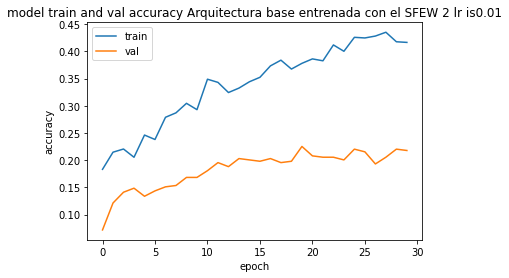

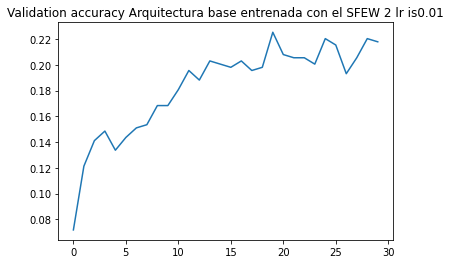

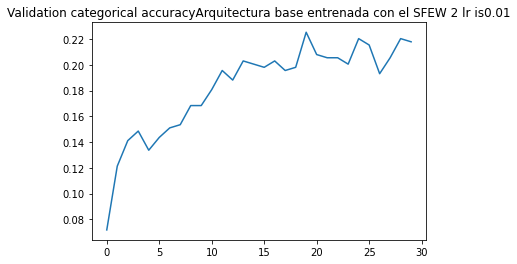

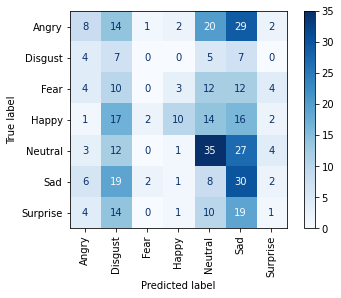

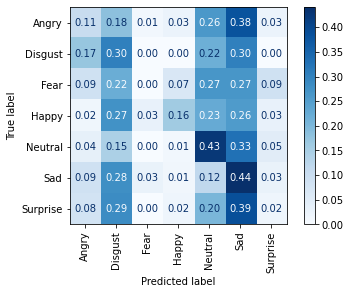

<Figure size 432x288 with 0 Axes>


-------------------------------------
lr:  1e-05
batch_size:  8
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
Epoch 1/50
107/107 [==============================] - 7s 60ms/step - loss: 3.2367 - accuracy: 0.1915 - categorical_accuracy: 0.1915 - val_loss: 1.9265 - val_accuracy: 0.2075 - val_categorical_accuracy: 0.2075
Epoch 2/50
107/107 [==============================] - 6s 52ms/step - loss: 3.1024 - accuracy: 0.1845 - categorical_accuracy: 0.1845 - val_loss: 1.9663 - val_accuracy: 0.2100 - val_categorical_accuracy: 0.2100
Epoch 3/50
107/107 [==============================] - 6s 58ms/step - loss: 2.9751 - accuracy: 0.2080 - categorical_accuracy: 0.2080 - val_loss: 2.0360 - val_accuracy: 0.2100 - val_categorical_accuracy: 0.2100
Epoch 4/50
107/107 [==============================] - 6s 53ms/step - loss: 2.9918 - accuracy: 0.1857 - categorical_accuracy: 0.1857 - val_loss: 2.0934 - val_accuracy: 0.1925 - val_categorical_accuracy: 0.1925
Epoch 5/50
107/10

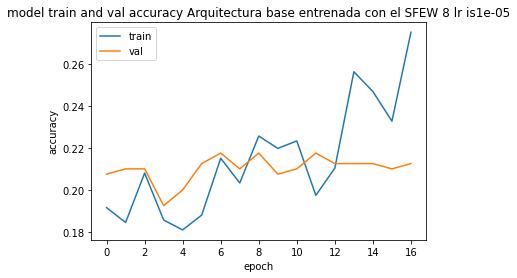

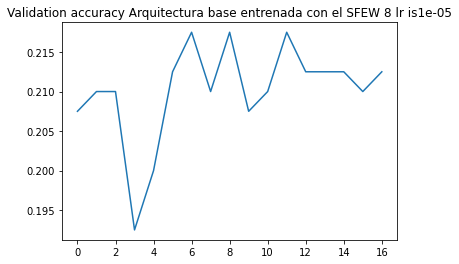

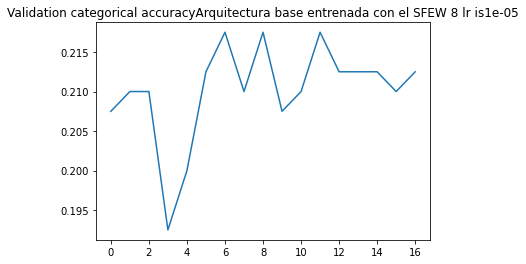

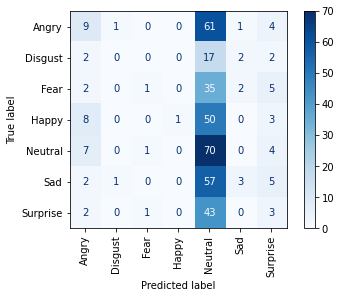

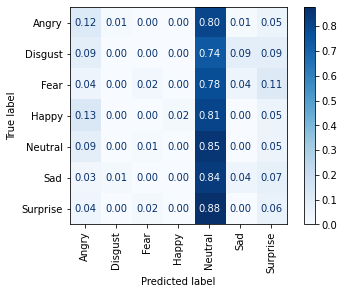

<Figure size 432x288 with 0 Axes>


-------------------------------------
lr:  0.0001
batch_size:  8
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
Epoch 1/50
107/107 [==============================] - 7s 56ms/step - loss: 3.3250 - accuracy: 0.1680 - categorical_accuracy: 0.1680 - val_loss: 1.9998 - val_accuracy: 0.0925 - val_categorical_accuracy: 0.0925
Epoch 2/50
107/107 [==============================] - 6s 56ms/step - loss: 3.2116 - accuracy: 0.1810 - categorical_accuracy: 0.1810 - val_loss: 2.0910 - val_accuracy: 0.1150 - val_categorical_accuracy: 0.1150
Epoch 3/50
107/107 [==============================] - 6s 54ms/step - loss: 3.1116 - accuracy: 0.1763 - categorical_accuracy: 0.1763 - val_loss: 2.1711 - val_accuracy: 0.1600 - val_categorical_accuracy: 0.1600
Epoch 4/50
107/107 [==============================] - 6s 55ms/step - loss: 3.0086 - accuracy: 0.1821 - categorical_accuracy: 0.1821 - val_loss: 2.2044 - val_accuracy: 0.1675 - val_categorical_accuracy: 0.1675
Epoch 5/50
107/1

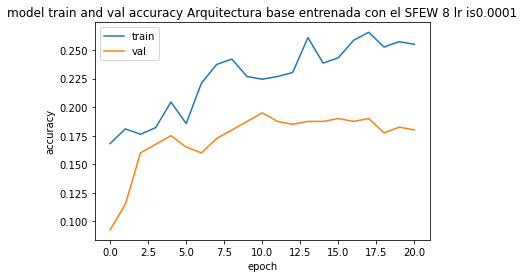

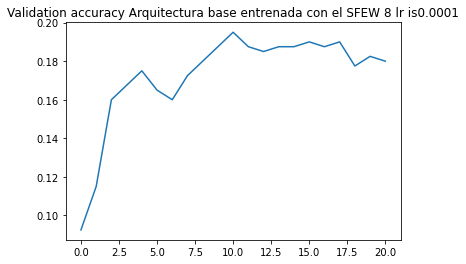

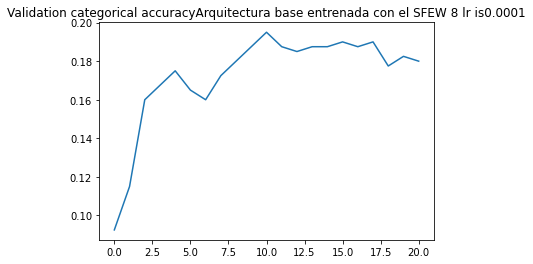

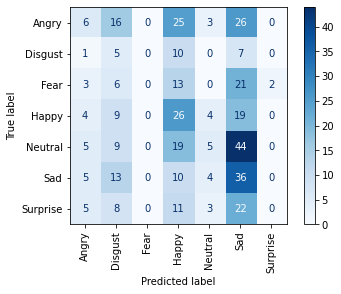

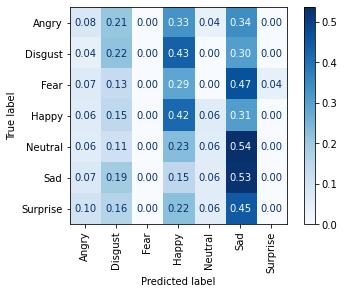

<Figure size 432x288 with 0 Axes>


-------------------------------------
lr:  0.001
batch_size:  8
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
Epoch 1/50
107/107 [==============================] - 7s 62ms/step - loss: 3.3683 - accuracy: 0.1586 - categorical_accuracy: 0.1586 - val_loss: 1.9726 - val_accuracy: 0.1700 - val_categorical_accuracy: 0.1700
Epoch 2/50
107/107 [==============================] - 6s 57ms/step - loss: 2.9702 - accuracy: 0.2080 - categorical_accuracy: 0.2080 - val_loss: 2.0555 - val_accuracy: 0.1650 - val_categorical_accuracy: 0.1650
Epoch 3/50
107/107 [==============================] - 6s 57ms/step - loss: 2.9978 - accuracy: 0.1810 - categorical_accuracy: 0.1810 - val_loss: 2.1201 - val_accuracy: 0.1650 - val_categorical_accuracy: 0.1650
Epoch 4/50
107/107 [==============================] - 6s 60ms/step - loss: 2.9999 - accuracy: 0.1845 - categorical_accuracy: 0.1845 - val_loss: 2.1307 - val_accuracy: 0.1725 - val_categorical_accuracy: 0.1725
Epoch 5/50
107/10

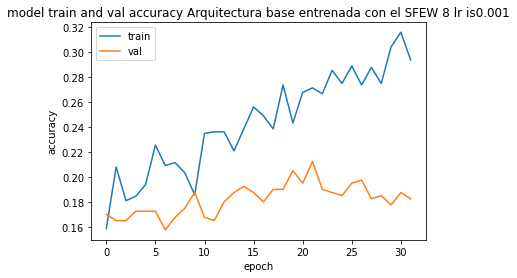

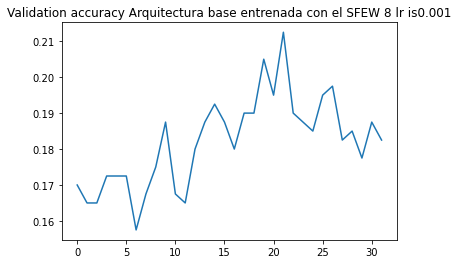

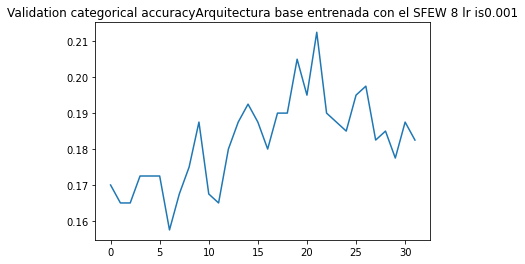

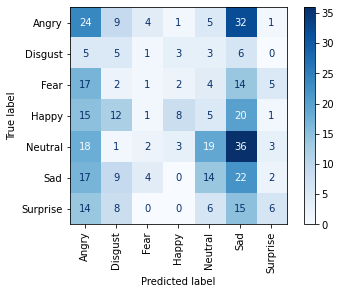

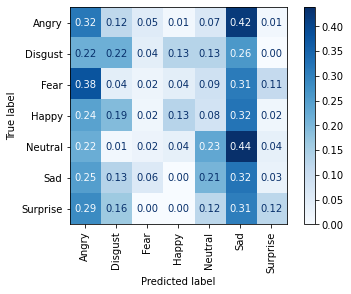

<Figure size 432x288 with 0 Axes>


-------------------------------------
lr:  0.01
batch_size:  8
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
Epoch 1/50
107/107 [==============================] - 7s 58ms/step - loss: 3.3485 - accuracy: 0.1833 - categorical_accuracy: 0.1833 - val_loss: 1.9516 - val_accuracy: 0.1900 - val_categorical_accuracy: 0.1900
Epoch 2/50
107/107 [==============================] - 6s 56ms/step - loss: 3.1475 - accuracy: 0.1845 - categorical_accuracy: 0.1845 - val_loss: 2.0181 - val_accuracy: 0.1925 - val_categorical_accuracy: 0.1925
Epoch 3/50
107/107 [==============================] - 6s 56ms/step - loss: 3.0797 - accuracy: 0.1833 - categorical_accuracy: 0.1833 - val_loss: 2.0971 - val_accuracy: 0.1975 - val_categorical_accuracy: 0.1975
Epoch 4/50
107/107 [==============================] - 6s 56ms/step - loss: 3.0126 - accuracy: 0.2103 - categorical_accuracy: 0.2103 - val_loss: 2.1760 - val_accuracy: 0.1700 - val_categorical_accuracy: 0.1700
Epoch 5/50
107/107

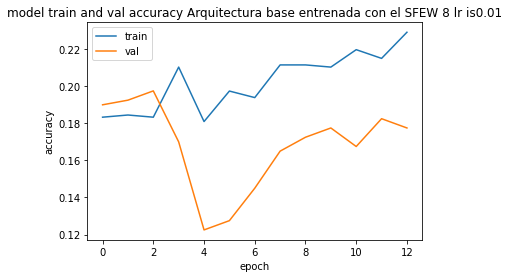

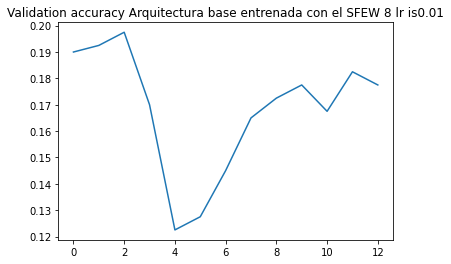

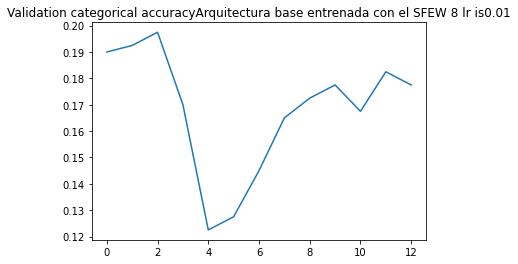

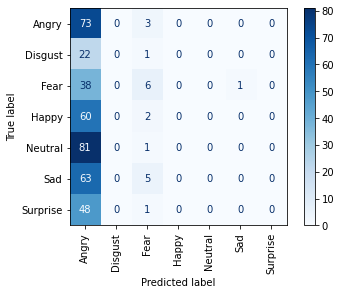

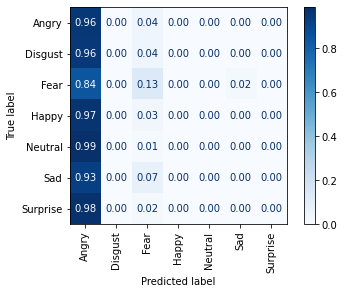

<Figure size 432x288 with 0 Axes>


-------------------------------------
lr:  1e-05
batch_size:  16
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
Epoch 1/50
53/53 [==============================] - 6s 106ms/step - loss: 3.4274 - accuracy: 0.2076 - categorical_accuracy: 0.2076 - val_loss: 1.9279 - val_accuracy: 0.1725 - val_categorical_accuracy: 0.1725
Epoch 2/50
53/53 [==============================] - 6s 104ms/step - loss: 3.1611 - accuracy: 0.1862 - categorical_accuracy: 0.1862 - val_loss: 1.9717 - val_accuracy: 0.1700 - val_categorical_accuracy: 0.1700
Epoch 3/50
53/53 [==============================] - 5s 100ms/step - loss: 3.1489 - accuracy: 0.1708 - categorical_accuracy: 0.1708 - val_loss: 2.0641 - val_accuracy: 0.1700 - val_categorical_accuracy: 0.1700
Epoch 4/50
53/53 [==============================] - 5s 100ms/step - loss: 2.9945 - accuracy: 0.1803 - categorical_accuracy: 0.1803 - val_loss: 2.1594 - val_accuracy: 0.1700 - val_categorical_accuracy: 0.1700
Epoch 5/50
53/53 [==

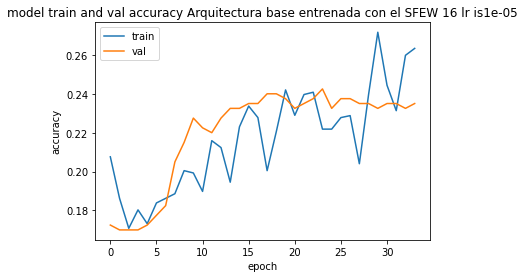

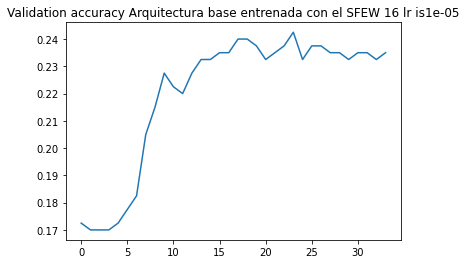

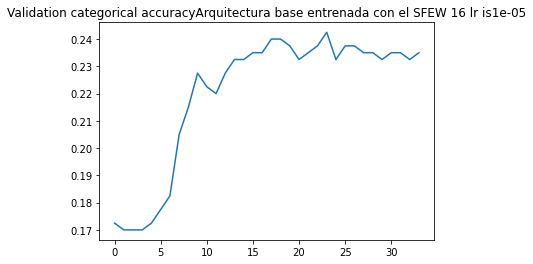

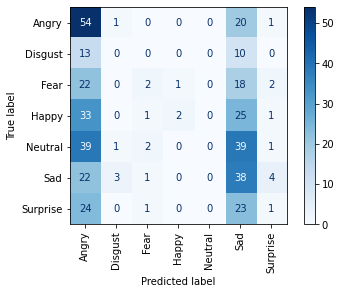

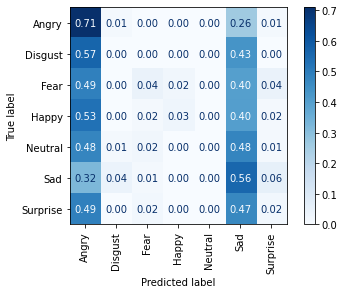

<Figure size 432x288 with 0 Axes>


-------------------------------------
lr:  0.0001
batch_size:  16
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
Epoch 1/50
53/53 [==============================] - 7s 112ms/step - loss: 3.6566 - accuracy: 0.1518 - categorical_accuracy: 0.1518 - val_loss: 1.9746 - val_accuracy: 0.0600 - val_categorical_accuracy: 0.0600
Epoch 2/50
53/53 [==============================] - 5s 104ms/step - loss: 3.2658 - accuracy: 0.1791 - categorical_accuracy: 0.1791 - val_loss: 2.0286 - val_accuracy: 0.0575 - val_categorical_accuracy: 0.0575
Epoch 3/50
53/53 [==============================] - 5s 102ms/step - loss: 3.1070 - accuracy: 0.1744 - categorical_accuracy: 0.1744 - val_loss: 2.0928 - val_accuracy: 0.0575 - val_categorical_accuracy: 0.0575
Epoch 4/50
53/53 [==============================] - 5s 101ms/step - loss: 3.0998 - accuracy: 0.1601 - categorical_accuracy: 0.1601 - val_loss: 2.1534 - val_accuracy: 0.0575 - val_categorical_accuracy: 0.0575
Epoch 5/50
53/53 [=

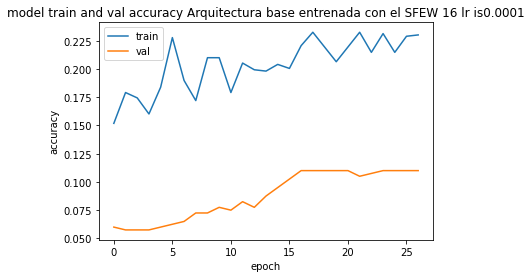

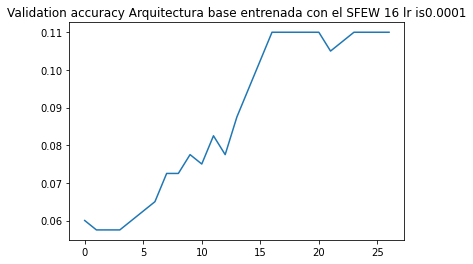

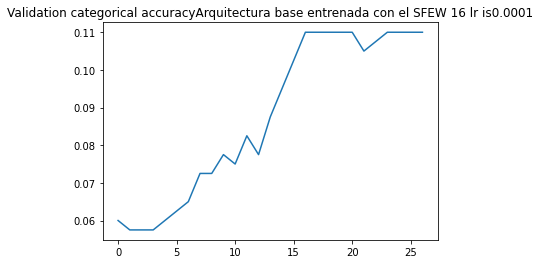

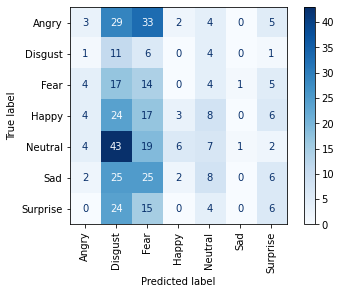

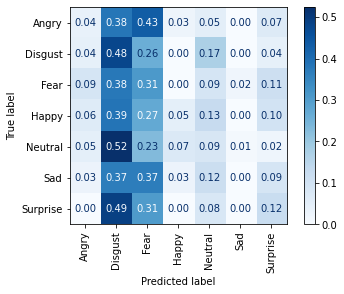

<Figure size 432x288 with 0 Axes>


-------------------------------------
lr:  0.001
batch_size:  16
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
Epoch 1/50
53/53 [==============================] - 6s 108ms/step - loss: 3.5665 - accuracy: 0.1637 - categorical_accuracy: 0.1637 - val_loss: 1.9581 - val_accuracy: 0.0650 - val_categorical_accuracy: 0.0650
Epoch 2/50
53/53 [==============================] - 5s 103ms/step - loss: 3.2712 - accuracy: 0.1637 - categorical_accuracy: 0.1637 - val_loss: 1.9830 - val_accuracy: 0.0600 - val_categorical_accuracy: 0.0600
Epoch 3/50
53/53 [==============================] - 5s 103ms/step - loss: 3.1219 - accuracy: 0.1673 - categorical_accuracy: 0.1673 - val_loss: 2.0225 - val_accuracy: 0.0600 - val_categorical_accuracy: 0.0600
Epoch 4/50
53/53 [==============================] - 5s 103ms/step - loss: 2.9843 - accuracy: 0.2112 - categorical_accuracy: 0.2112 - val_loss: 2.0792 - val_accuracy: 0.0575 - val_categorical_accuracy: 0.0575
Epoch 5/50
53/53 [==

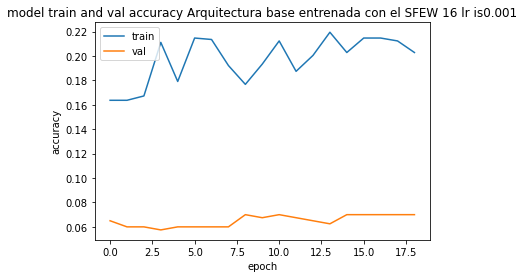

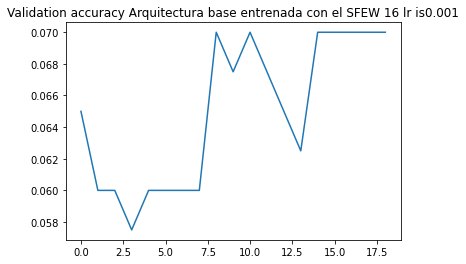

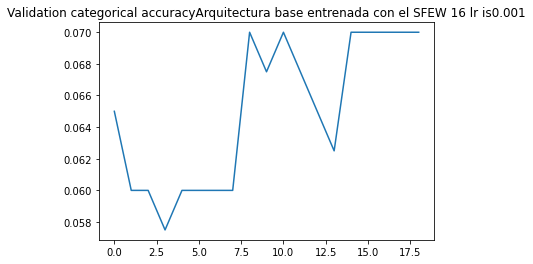

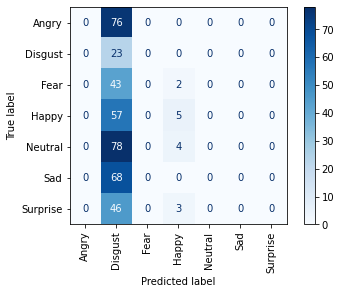

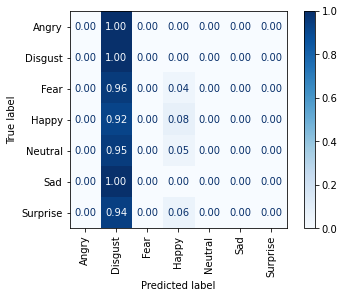

<Figure size 432x288 with 0 Axes>


-------------------------------------
lr:  0.01
batch_size:  16
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
Epoch 1/50
53/53 [==============================] - 7s 109ms/step - loss: 3.5055 - accuracy: 0.1720 - categorical_accuracy: 0.1720 - val_loss: 1.9481 - val_accuracy: 0.0875 - val_categorical_accuracy: 0.0875
Epoch 2/50
53/53 [==============================] - 6s 104ms/step - loss: 3.1360 - accuracy: 0.1945 - categorical_accuracy: 0.1945 - val_loss: 1.9736 - val_accuracy: 0.0625 - val_categorical_accuracy: 0.0625
Epoch 3/50
53/53 [==============================] - 5s 104ms/step - loss: 3.1433 - accuracy: 0.1898 - categorical_accuracy: 0.1898 - val_loss: 2.0089 - val_accuracy: 0.1075 - val_categorical_accuracy: 0.1075
Epoch 4/50
53/53 [==============================] - 5s 103ms/step - loss: 3.1705 - accuracy: 0.1827 - categorical_accuracy: 0.1827 - val_loss: 2.0426 - val_accuracy: 0.1300 - val_categorical_accuracy: 0.1300
Epoch 5/50
53/53 [===

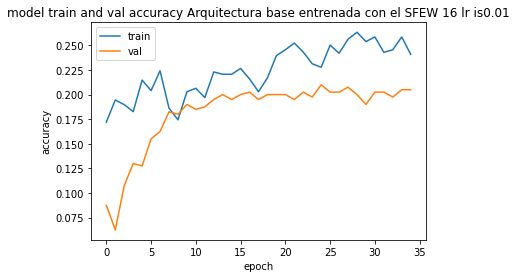

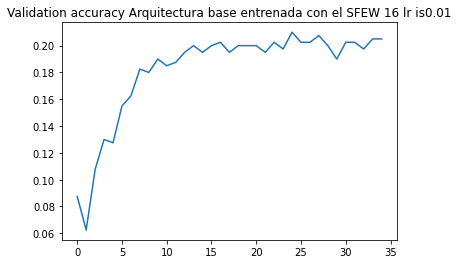

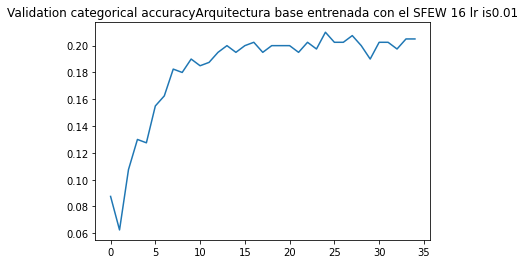

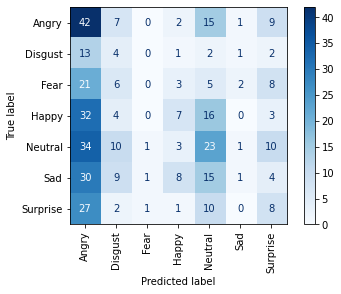

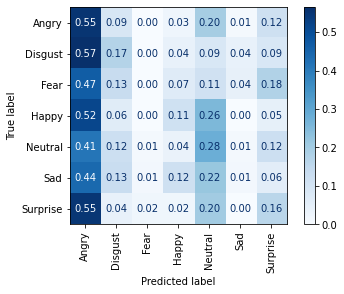

<Figure size 432x288 with 0 Axes>

In [ ]:
#Reentrenamos el modelo con el SFEW y las 7 emociones con dataugmentation:

HEIGHT,WIDTH=128,128  #143 x 181
# img_height, img_width=143 x 181

img_height, img_width=128, 128
train_data_dir = SFEW_train_dir
validation_data_dir = SFEW_test_dir
num_classes=7
dropout = 0.25
LR = 0.00001
epochs = 50
batch_size = 1
CHANNELS=1
dataugmentation=True
classes_sfew=["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
path="/content/gdrive/MyDrive/figures/Modelo0_SFEW7_dataug/"

lr_list=[0.00001,0.0001,0.001,0.01]
batch_sz_list=[1,2,8,16]
for batch_size in batch_sz_list:
  for lr in lr_list:

    print("-------------------------------------")
    print("lr: ",lr)
    print("batch_size: ",batch_size)
    dir="/content/gdrive/MyDrive/TFM_MUSIcorrected_test/"
    SFEW_train_set,SFEW_test_set=create_sets(dataugmentation,SFEW_train_dir,SFEW_test_dir,batch_size,classes_sfew)
    model=CNNmodel()
    optimizer = tf.keras.optimizers.SGD(lr=LR)
    model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy','categorical_accuracy'])
    train_steps=int(len(SFEW_train_set.labels)/batch_size)
    test_steps=int(len(SFEW_test_set.labels)/batch_size)
    # checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    Earlystopping=keras.callbacks.EarlyStopping(patience=10, monitor="val_accuracy",min_delta=0,verbose=0,mode="auto",baseline=None,restore_best_weights=True)
    callbacks_list = [Earlystopping]

    hist=model.fit_generator(SFEW_train_set,
                            steps_per_epoch =train_steps,
                            epochs = epochs,
                            validation_data = SFEW_test_set,
                            validation_steps =test_steps,
                            callbacks=Earlystopping)

    title="Arquitectura base entrenada con el SFEW "+str(batch_size)+" lr is"+str(lr)
    plot_model(hist,title)
    figure_path=path+"batch_"+str(batch_size)+"lr_"+str(lr)
    plot_conf_matrix(SFEW_test_set,model,figure_path,title,standard_format=True,percentages=False,save_plot=True)

In [ ]:
def create_model(num_frozen_layers,dropout=0.5):
  model = VGG16(include_top=False, input_shape=(img_width, img_height, 3))
  print("VGG_summary:")
  model.summary()
  # add new classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  dense1 = Dense(1024, activation='relu')(flat1)
  if dropout!=None:
    dropout=Dropout(dropout)(dense1)
    output = Dense(7, activation='softmax')(dropout)
  else:
    output = Dense(7, activation='softmax')(dense1)
  # define new model
  new_model = Model(inputs=model.inputs, outputs=output)
  print(new_model.layers)
  for layer in new_model.layers[0:-8]:
    print("freezing layer: ",layer.name)
    layer.trainable = False

  print("new_model summary!")
  new_model.summary()
  return new_model

In [ ]:
#Modelo 2: VGG transfer learning
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import img_to_array
# from keras.applications.vgg16 import preprocess_input
# from keras.applications.vgg16 import decode_predictions
# from keras.applications.vgg16 import VGG16
# from keras.models import Model

In [ ]:
model = VGG16(include_top=False, input_shape=(img_width, img_height, 3))
print("VGG_summary:")
model.summary()

VGG_summary:
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

def create_model(num_frozen_layers,dropout=None):
  # model = VGG16(include_top=False, input_shape=in_shape)
  model = VGG16(include_top=False, input_shape=(img_width, img_height, 3))
  # print("VGG_summary:")
  # model.summary()
  # add new classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  dense1 = Dense(1024, activation='relu')(flat1)
  if dropout!=None:
    dropout=Dropout(dropout)(dense1)
    output = Dense(7, activation='softmax')(dropout)
  else:
    output = Dense(7, activation='softmax')(dense1)
  # define new model
  new_model = Model(inputs=model.inputs, outputs=output)
  print(new_model.layers)
  for layer in new_model.layers[-num_frozen_layers:-16]:
    print("freezing layer: ",layer.name)
    layer.trainable = False

  print("new_model summary!")
  new_model.summary()
  return new_model



In [ ]:
def create_model(num_frozen_layers,dropout=0.5):
  model = VGG16(include_top=False, input_shape=(img_width, img_height, 3))
  print("VGG_summary:")
  model.summary()
  # add new classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  dense1 = Dense(1024, activation='relu')(flat1)
  if dropout!=None:
    dropout=Dropout(dropout)(dense1)
    output = Dense(7, activation='softmax')(dropout)
  else:
    output = Dense(7, activation='softmax')(dense1)
  # define new model
  new_model = Model(inputs=model.inputs, outputs=output)
  print(new_model.layers)
  for layer in new_model.layers[0:-8]:
    print("freezing layer: ",layer.name)
    layer.trainable = False

  print("new_model summary!")
  new_model.summary()
  return new_model

In [ ]:
model_VGG16=create_model(16,0.5)

VGG_summary:
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)

Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
58900480/58889256 [==============================] - 1s 0us/step
[<keras.engine.input_layer.InputLayer object at 0x7fe430429290>, <keras.layers.convolutional.Conv2D object at 0x7fe4302eb510>, <keras.layers.convolutional.Conv2D object at 0x7fe430262450>, <keras.layers.pooling.MaxPooling2D object at 0x7fe430242f90>, <keras.layers.convolutional.Conv2D object at 0x7fe430249750>, <keras.layers.convolutional.Conv2D object at 0x7fe43023f390>, <keras.layers.pooling.MaxPooling2D object at 0x7fe430362610>, <keras.layers.convolutional.Conv2D object at 0x7fe4303c2590>, <keras.layers.convolutional.Conv2D object at 0x7fe43024f8d0>, <keras.layers.convolutional.Conv2D object at 0x7fe430362650>, <keras.layers.pooling.MaxPooling2D object at 0x7fe4302533d0>, <keras.layers.convolutional.Conv2D object at 0x7fe43028cbd0>, <keras.layers.convolutional.Conv2D object at 0x7fe4301d8c50>, <keras.layers.convolutional.Conv2D object at

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/55
429/429 [==============================] - 68s 83ms/step - loss: 1.9678 - accuracy: 0.2345 - categorical_accuracy: 0.2345 - val_loss: 1.8858 - val_accuracy: 0.2550 - val_categorical_accuracy: 0.2550
Epoch 2/55
429/429 [==============================] - 34s 80ms/step - loss: 1.7873 - accuracy: 0.3232 - categorical_accuracy: 0.3232 - val_loss: 1.7896 - val_accuracy: 0.3391 - val_categorical_accuracy: 0.3391
Epoch 3/55
429/429 [==============================] - 35s 80ms/step - loss: 1.6017 - accuracy: 0.3921 - categorical_accuracy: 0.3921 - val_loss: 1.7599 - val_accuracy: 0.3639 - val_categorical_accuracy: 0.3639
Epoch 4/55
429/429 [==============================] - 34s 80ms/step - loss: 1.4299 - accuracy: 0.4667 - categorical_accuracy: 0.4667 - val_loss: 1.7679 - val_accuracy: 0.3614 - val_categorical_accuracy: 0.3614
Epoch 5/55
429/429 [==============================] - 34s 80ms/step - loss: 1.2703 - accuracy: 0.5309 - categorical_accuracy: 0.5309 - val_loss: 1.7800 - val_ac

FileNotFoundError: ignored

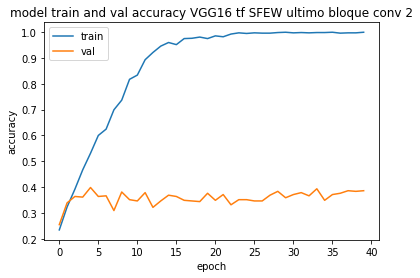

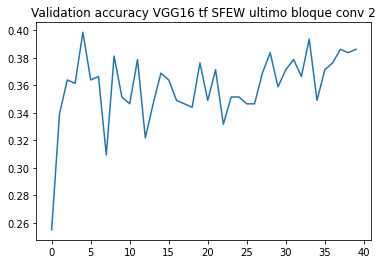

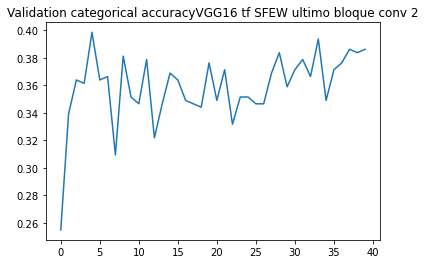

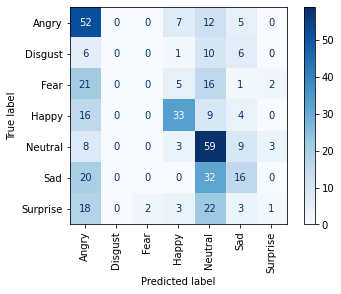

In [ ]:
dropout = 0.25
LR = 0.0001
epochs = 55
batch_sz=[2,16,32,64,128]
batch_sz=[8,16,32,64]
# batch_size=16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
classes_sfew=["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

path=""

for batch_size in batch_sz:

  print("-------------------------------------")
  print("batch_size: ",batch_size)

  SFEW_train_set,SFEW_test_set=create_sets(dataugmentation,SFEW_train_dir,SFEW_test_dir,batch_size,classes_sfew,color_mode="rgb")
  train_steps=int(len(SFEW_train_set.labels)/batch_size)
  test_steps=int(len(SFEW_test_set.labels)/batch_size)
  model=create_model(16,0.5)

  model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),metrics=['accuracy','categorical_accuracy'])
  E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",min_delta=0,patience=15,verbose=1,mode="auto",restore_best_weights=True)

  callbacks_list = [E_stopping]

  history=model.fit_generator(
          SFEW_train_set,
          steps_per_epoch=train_steps,
          epochs=epochs,
          validation_data=SFEW_test_set,
          validation_steps=test_steps,
          # class_weight=class_weight_dict,
          callbacks=callbacks_list)

  title="VGG16 tf SFEW ultimo bloque conv "+str(batch_size)
  plot_model(history,title)
  figure_path=path+"batch_"+str(batch_size)
  plot_conf_matrix(SFEW_test_set,model,figure_path,title,standard_format=True,percentages=True,save_plot=True)

-------------------------------------
batch_size:  8
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
[<keras.engine.input_layer.InputLayer object at 0x7fe430434a90>, <keras.layers.convolutional.Conv2D object at 0x7fe351248d50>, <keras.layers.convolutional.Conv2D object at 0x7fe3c6018310>, <keras.layers.pooling.MaxPooling2D object at 0x7fe34d3c8a10>, <keras.layers.convolutional.Conv2D object at 0x7fe35128bc90>, <keras.layers.convolutional.Conv2D object at 0x7fe34c331350>, <keras.layers.pooling.MaxPooling2D object at 0x7fe34c32e350>, <keras.layers.convolutional.Conv2D object at 0x7fe34c3365d0>, <keras.layers.convolutional.Conv2D object at 0x7fe3c65f0ed0>, <keras.layers.convolutional.Conv2D object at 0x7fe34c33ed90>, <keras.layers.pooling.MaxPooling2D object at 0x7fe34c336b10>, <keras.layers.convolutional.Conv2D object at 0x7fe34c341d50>, <keras.layers.convolutional.Conv2D object at 0x7fe34c3463d0>, <keras.layers.convolutional.Conv2D object at 0x7fe34c341

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


107/107 [==============================] - 20s 157ms/step - loss: 2.0625 - accuracy: 0.2068 - categorical_accuracy: 0.2068 - val_loss: 1.9188 - val_accuracy: 0.2450 - val_categorical_accuracy: 0.2450
Epoch 2/55
107/107 [==============================] - 14s 135ms/step - loss: 1.7980 - accuracy: 0.2855 - categorical_accuracy: 0.2855 - val_loss: 1.8902 - val_accuracy: 0.2375 - val_categorical_accuracy: 0.2375
Epoch 3/55
107/107 [==============================] - 14s 135ms/step - loss: 1.6978 - accuracy: 0.3431 - categorical_accuracy: 0.3431 - val_loss: 1.8586 - val_accuracy: 0.2925 - val_categorical_accuracy: 0.2925
Epoch 4/55
107/107 [==============================] - 14s 135ms/step - loss: 1.5404 - accuracy: 0.4172 - categorical_accuracy: 0.4172 - val_loss: 1.7804 - val_accuracy: 0.3375 - val_categorical_accuracy: 0.3375
Epoch 5/55
107/107 [==============================] - 14s 135ms/step - loss: 1.4583 - accuracy: 0.4489 - categorical_accuracy: 0.4489 - val_loss: 1.7806 - val_accuracy

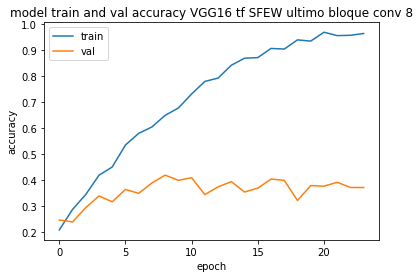

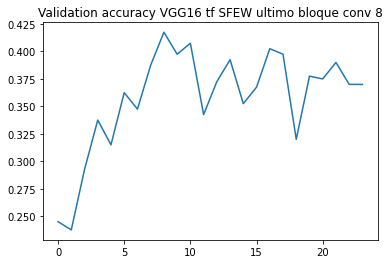

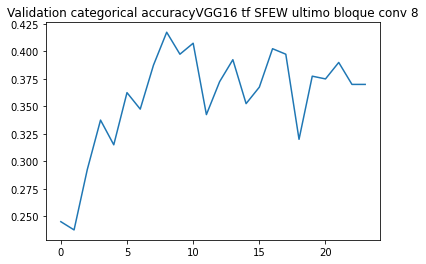

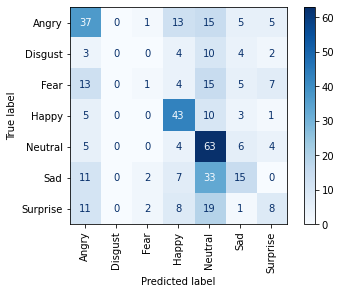

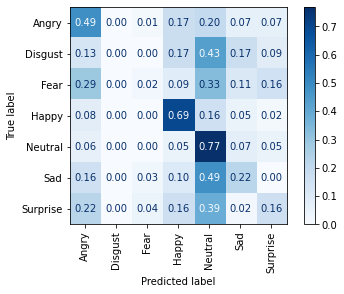

<Figure size 432x288 with 0 Axes>


-------------------------------------
batch_size:  16
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
[<keras.engine.input_layer.InputLayer object at 0x7fe34ff4b550>, <keras.layers.convolutional.Conv2D object at 0x7fe3500a2290>, <keras.layers.convolutional.Conv2D object at 0x7fe35025c790>, <keras.layers.pooling.MaxPooling2D object at 0x7fe34fee9390>, <keras.layers.convolutional.Conv2D object at 0x7fe34fec33d0>, <keras.layers.convolutional.Conv2D object at 0x7fe34c331dd0>, <keras.layers.pooling.MaxPooling2D object at 0x7fe34cb37f10>, <keras.layers.convolutional.Conv2D object at 0x7fe34c336d10>, <keras.layers.convolutional.Conv2D object at 0x7fe34ca17b10>, <keras.layers.convolutional.Conv2D object at 0x7fe34c9b57d0>, <keras.layers.pooling.MaxPooling2D object at 0x7fe34fec6dd0>, <keras.layers.convolutional.Conv2D object at 0x7fe34c972110>, <keras.layers.convolutional.Conv2D object at 0x7fe430467ad0>, <keras.layers.convolutional.Conv2D object at 0x7fe3500

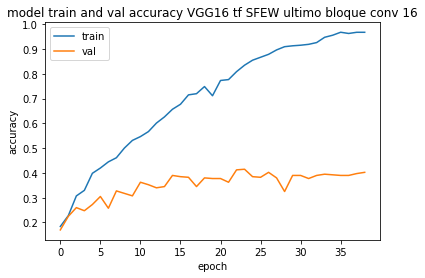

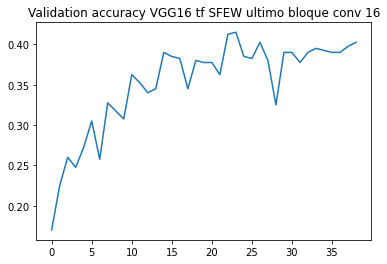

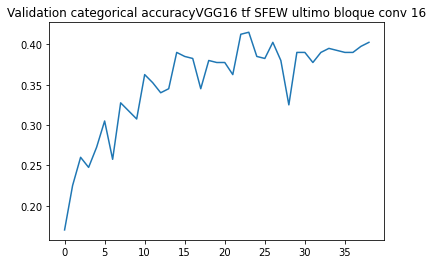

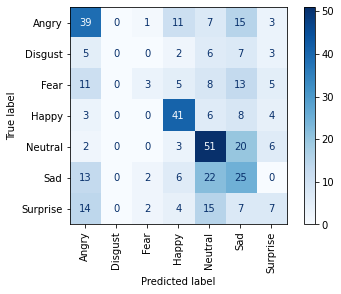

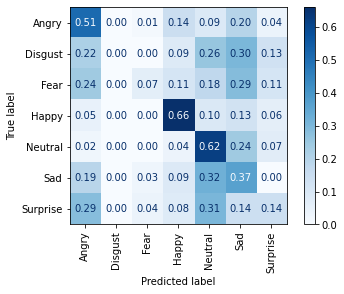

<Figure size 432x288 with 0 Axes>


-------------------------------------
batch_size:  32
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
[<keras.engine.input_layer.InputLayer object at 0x7fe34ff7c5d0>, <keras.layers.convolutional.Conv2D object at 0x7fe34fd9f790>, <keras.layers.convolutional.Conv2D object at 0x7fe34fe84310>, <keras.layers.pooling.MaxPooling2D object at 0x7fe34fd9f050>, <keras.layers.convolutional.Conv2D object at 0x7fe34fcba7d0>, <keras.layers.convolutional.Conv2D object at 0x7fe34fcbce50>, <keras.layers.pooling.MaxPooling2D object at 0x7fe34fcb9cd0>, <keras.layers.convolutional.Conv2D object at 0x7fe34fcba290>, <keras.layers.convolutional.Conv2D object at 0x7fe34fcc4310>, <keras.layers.convolutional.Conv2D object at 0x7fe34fcc2f10>, <keras.layers.pooling.MaxPooling2D object at 0x7fe34fcc9090>, <keras.layers.convolutional.Conv2D object at 0x7fe34fccd6d0>, <keras.layers.convolutional.Conv2D object at 0x7fe34fcd8350>, <keras.layers.convolutional.Conv2D object at 0x7fe34fc

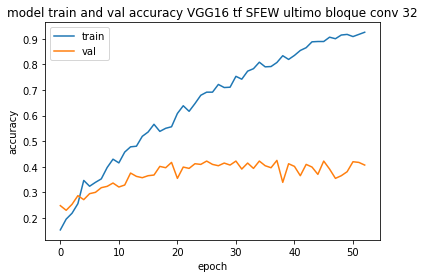

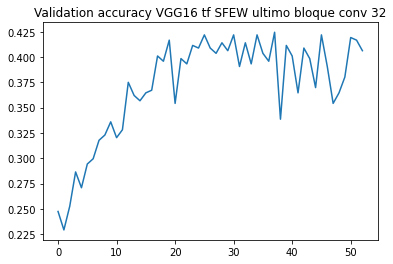

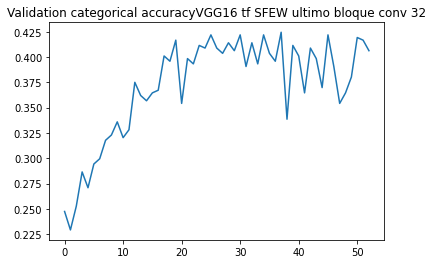

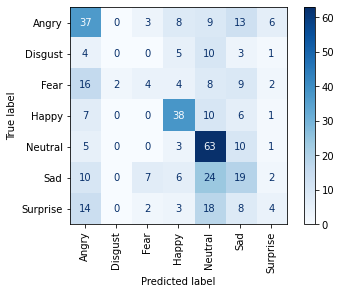

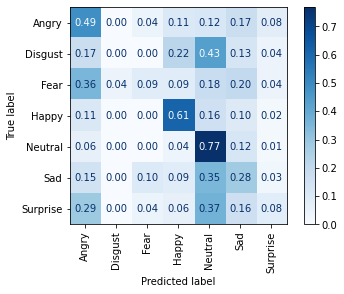

<Figure size 432x288 with 0 Axes>


-------------------------------------
batch_size:  64
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
[<keras.engine.input_layer.InputLayer object at 0x7fe34c561990>, <keras.layers.convolutional.Conv2D object at 0x7fe34c539a10>, <keras.layers.convolutional.Conv2D object at 0x7fe34fd37ed0>, <keras.layers.pooling.MaxPooling2D object at 0x7fe34c539a50>, <keras.layers.convolutional.Conv2D object at 0x7fe34c3dd390>, <keras.layers.convolutional.Conv2D object at 0x7fe34c4f7690>, <keras.layers.pooling.MaxPooling2D object at 0x7fe34c411d90>, <keras.layers.convolutional.Conv2D object at 0x7fe34c3e1d10>, <keras.layers.convolutional.Conv2D object at 0x7fe34c3e6090>, <keras.layers.convolutional.Conv2D object at 0x7fe34c3e3910>, <keras.layers.pooling.MaxPooling2D object at 0x7fe34c3e6c90>, <keras.layers.convolutional.Conv2D object at 0x7fe3c6edbbd0>, <keras.layers.convolutional.Conv2D object at 0x7fe3c6ee0910>, <keras.layers.convolutional.Conv2D object at 0x7fe3c6e

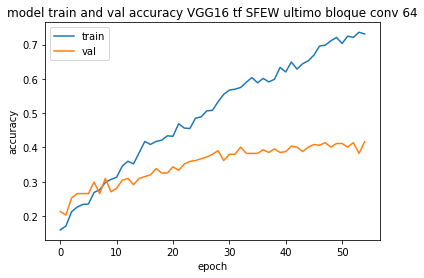

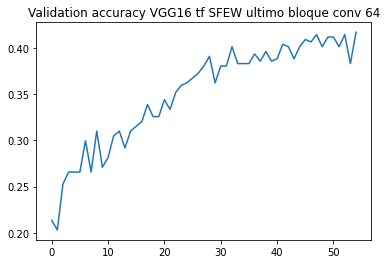

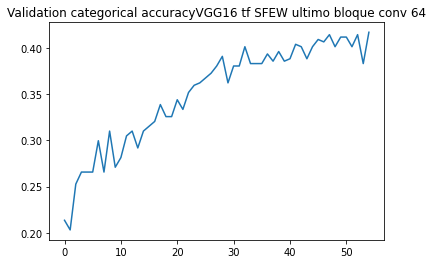

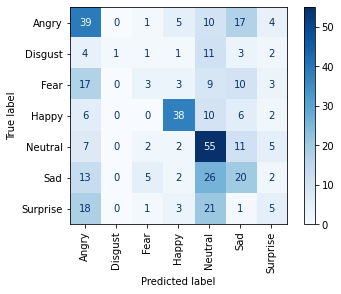

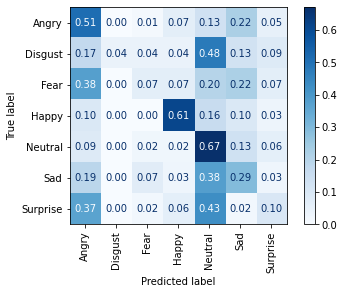

<Figure size 432x288 with 0 Axes>

In [ ]:
dropout = 0.25
LR = 0.0001
epochs = 55
batch_sz=[2,16,32,64,128]
batch_sz=[2,8,16,32,64]
# batch_size=16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
classes_sfew=["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

path=""

for batch_size in batch_sz:

  print("-------------------------------------")
  print("batch_size: ",batch_size)

  SFEW_train_set,SFEW_test_set=create_sets(dataugmentation,SFEW_train_dir,SFEW_test_dir,batch_size,classes_sfew,color_mode="rgb")
  train_steps=int(len(SFEW_train_set.labels)/batch_size)
  test_steps=int(len(SFEW_test_set.labels)/batch_size)
  model=create_model(16,0.5)

  model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),metrics=['accuracy','categorical_accuracy'])
  E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",min_delta=0,patience=15,verbose=1,mode="auto",restore_best_weights=True)

  callbacks_list = [E_stopping]

  history=model.fit_generator(
          SFEW_train_set,
          steps_per_epoch=train_steps,
          epochs=epochs,
          validation_data=SFEW_test_set,
          validation_steps=test_steps,
          # class_weight=class_weight_dict,
          callbacks=callbacks_list)

  title="VGG16 tf SFEW ultimo bloque conv "+str(batch_size)
  plot_model(history,title)
  figure_path=path+"batch_"+str(batch_size)
  plot_conf_matrix(SFEW_test_set,model,figure_path,title,standard_format=True,percentages=True,save_plot=True)

In [ ]:
dataugmentation

False

In [ ]:
model=create_model(16,0.5)


[<keras.engine.input_layer.InputLayer object at 0x7fe34c503f10>, <keras.layers.convolutional.Conv2D object at 0x7fe34c503b10>, <keras.layers.convolutional.Conv2D object at 0x7fe34ff35490>, <keras.layers.pooling.MaxPooling2D object at 0x7fe34c503e10>, <keras.layers.convolutional.Conv2D object at 0x7fe34c502e50>, <keras.layers.convolutional.Conv2D object at 0x7fe34c746250>, <keras.layers.pooling.MaxPooling2D object at 0x7fe3c6665f90>, <keras.layers.convolutional.Conv2D object at 0x7fe34c5346d0>, <keras.layers.convolutional.Conv2D object at 0x7fe34ca106d0>, <keras.layers.convolutional.Conv2D object at 0x7fe3c6665990>, <keras.layers.pooling.MaxPooling2D object at 0x7fe34c9f8050>, <keras.layers.convolutional.Conv2D object at 0x7fe34c51f7d0>, <keras.layers.convolutional.Conv2D object at 0x7fe34c525210>, <keras.layers.convolutional.Conv2D object at 0x7fe34c73df10>, <keras.layers.pooling.MaxPooling2D object at 0x7fe34c72bb50>, <keras.layers.convolutional.Conv2D object at 0x7fe3c667d490>, <kera

-------------------------------------
batch_size:  2
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
VGG_summary:
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 1

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/55
429/429 [==============================] - 26s 59ms/step - loss: 2.0418 - accuracy: 0.2182 - categorical_accuracy: 0.2182 - val_loss: 1.9457 - val_accuracy: 0.2203 - val_categorical_accuracy: 0.2203
Epoch 2/55
429/429 [==============================] - 25s 58ms/step - loss: 1.9636 - accuracy: 0.2264 - categorical_accuracy: 0.2264 - val_loss: 1.9005 - val_accuracy: 0.2079 - val_categorical_accuracy: 0.2079
Epoch 3/55
429/429 [==============================] - 25s 58ms/step - loss: 1.8582 - accuracy: 0.2625 - categorical_accuracy: 0.2625 - val_loss: 1.8747 - val_accuracy: 0.2550 - val_categorical_accuracy: 0.2550
Epoch 4/55
429/429 [==============================] - 25s 58ms/step - loss: 1.8351 - accuracy: 0.2754 - categorical_accuracy: 0.2754 - val_loss: 1.8829 - val_accuracy: 0.2079 - val_categorical_accuracy: 0.2079
Epoch 5/55
429/429 [==============================] - 25s 57ms/step - loss: 1.7669 - accuracy: 0.3092 - categorical_accuracy: 0.3092 - val_loss: 1.8423 - val_ac

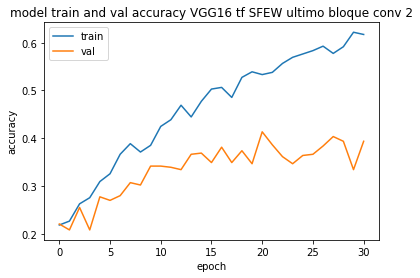

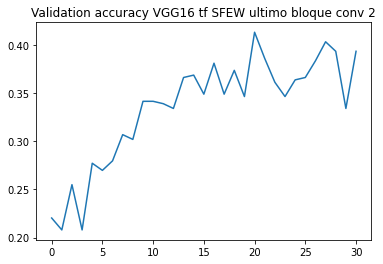

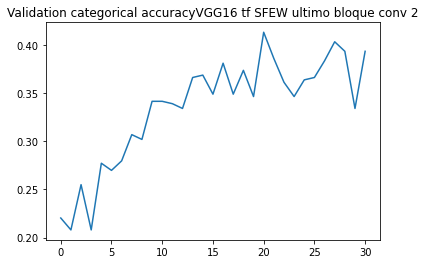

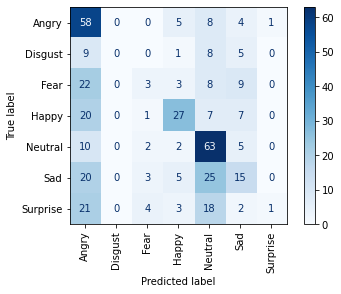

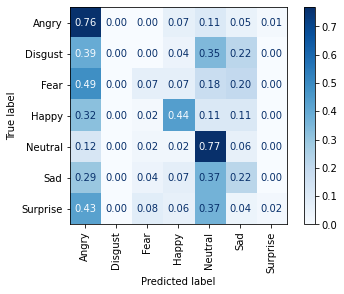

<Figure size 432x288 with 0 Axes>


-------------------------------------
batch_size:  8
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
VGG_summary:
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 

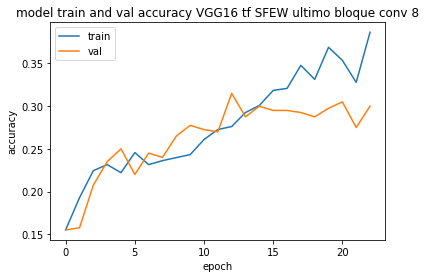

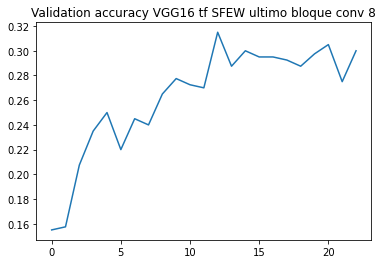

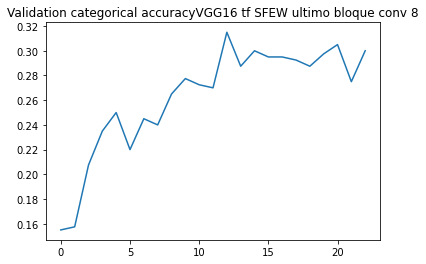

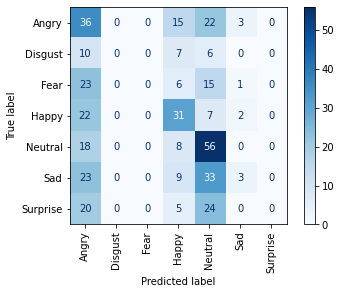

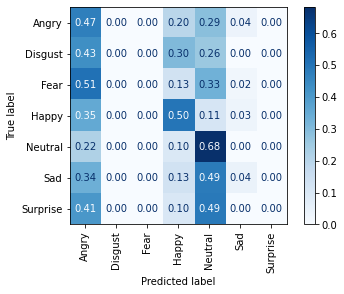

<Figure size 432x288 with 0 Axes>


-------------------------------------
batch_size:  16
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
VGG_summary:
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64,

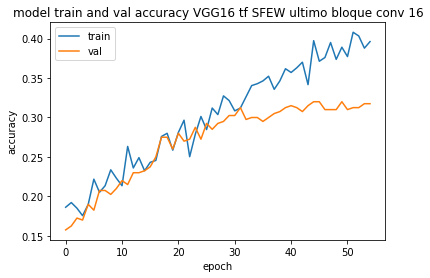

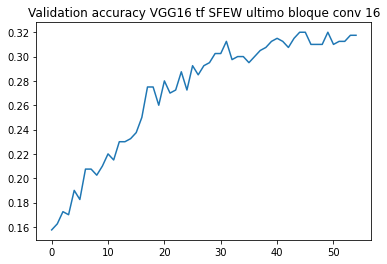

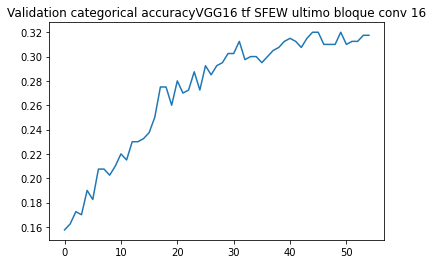

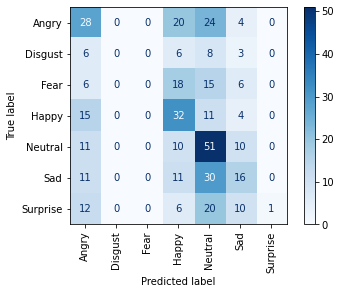

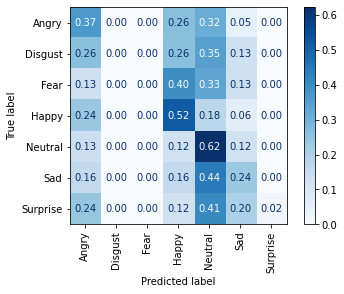

<Figure size 432x288 with 0 Axes>


-------------------------------------
batch_size:  32
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
VGG_summary:
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64,

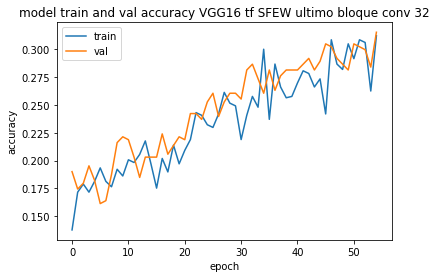

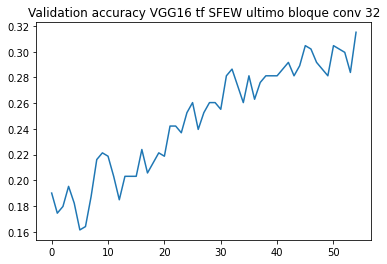

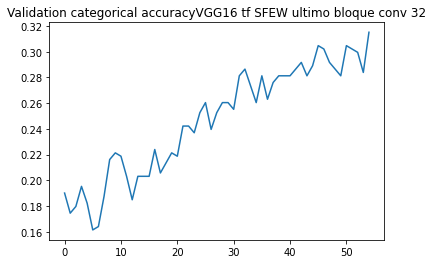

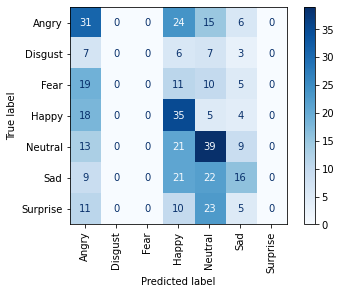

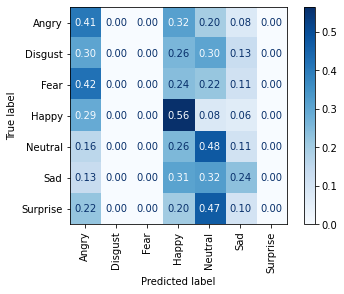

<Figure size 432x288 with 0 Axes>


-------------------------------------
batch_size:  64
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
VGG_summary:
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64,

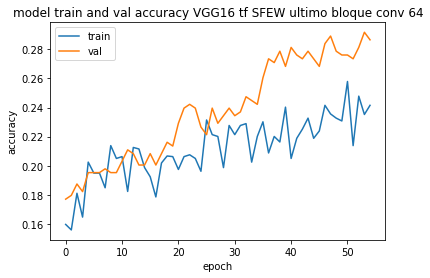

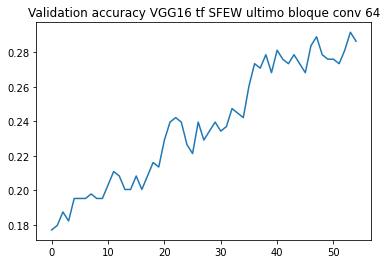

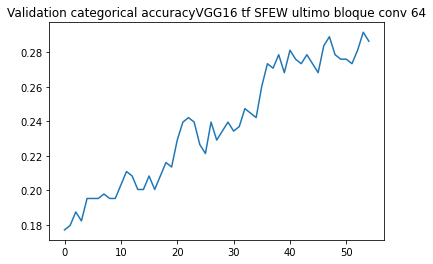

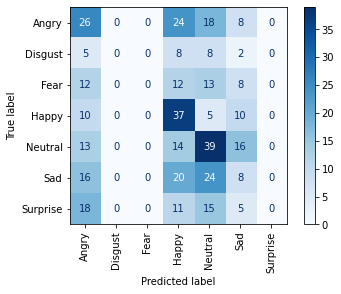

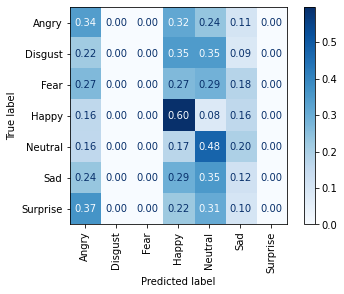

<Figure size 432x288 with 0 Axes>

In [ ]:
dropout = 0.25
LR = 0.0001
epochs = 55
batch_sz=[2,16,32,64,128]
batch_sz=[2,8,16,32,64]
# batch_size=16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
classes_sfew=["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
dataugmentation=True

path=""

for batch_size in batch_sz:

  print("-------------------------------------")
  print("batch_size: ",batch_size)

  SFEW_train_set,SFEW_test_set=create_sets(dataugmentation,SFEW_train_dir,SFEW_test_dir,batch_size,classes_sfew,color_mode="rgb")
  train_steps=int(len(SFEW_train_set.labels)/batch_size)
  test_steps=int(len(SFEW_test_set.labels)/batch_size)
  model=create_model(16,0.5)

  model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),metrics=['accuracy','categorical_accuracy'])
  E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",min_delta=0,patience=10,verbose=1,mode="auto",restore_best_weights=True)

  callbacks_list = [E_stopping]

  history=model.fit_generator(
          SFEW_train_set,
          steps_per_epoch=train_steps,
          epochs=epochs,
          validation_data=SFEW_test_set,
          validation_steps=test_steps,
          # class_weight=class_weight_dict,
          callbacks=callbacks_list)

  title="VGG16 tf SFEW ultimo bloque conv "+str(batch_size)
  plot_model(history,title)
  figure_path=path+"batch_"+str(batch_size)
  plot_conf_matrix(SFEW_test_set,model,figure_path,title,standard_format=True,percentages=True,save_plot=True)

In [ ]:
def create_model(num_frozen_layers,dropout=0.5):
  model = VGG16(include_top=False, input_shape=(img_width, img_height, 3))
  # print("VGG_summary:")
  model.summary()
  # add new classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  dense1 = Dense(1024, activation='relu')(flat1)
  if dropout!=None:
    dropout=Dropout(dropout)(dense1)
    output = Dense(7, activation='softmax')(dropout)
  else:
    output = Dense(7, activation='softmax')(dense1)
  # define new model
  new_model = Model(inputs=model.inputs, outputs=output)
  print(new_model.layers)
  for layer in new_model.layers[0:num_frozen_layers]:
    print("freezing layer: ",layer.name)
    layer.trainable = False

  print("new_model summary!")
  new_model.summary()
  return new_model

-------------------------------------
batch_size:  16
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       14

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/55
53/53 [==============================] - 10s 163ms/step - loss: 2.1281 - accuracy: 0.1827 - categorical_accuracy: 0.1827 - val_loss: 1.9116 - val_accuracy: 0.1825 - val_categorical_accuracy: 0.1825
Epoch 2/55
53/53 [==============================] - 8s 159ms/step - loss: 2.0607 - accuracy: 0.1934 - categorical_accuracy: 0.1934 - val_loss: 1.8904 - val_accuracy: 0.2050 - val_categorical_accuracy: 0.2050
Epoch 3/55
53/53 [==============================] - 8s 157ms/step - loss: 2.0148 - accuracy: 0.1945 - categorical_accuracy: 0.1945 - val_loss: 1.8911 - val_accuracy: 0.2000 - val_categorical_accuracy: 0.2000
Epoch 4/55
53/53 [==============================] - 8s 157ms/step - loss: 2.0102 - accuracy: 0.1886 - categorical_accuracy: 0.1886 - val_loss: 1.8835 - val_accuracy: 0.2200 - val_categorical_accuracy: 0.2200
Epoch 5/55
53/53 [==============================] - 8s 157ms/step - loss: 1.9885 - accuracy: 0.1957 - categorical_accuracy: 0.1957 - val_loss: 1.8795 - val_accuracy: 0

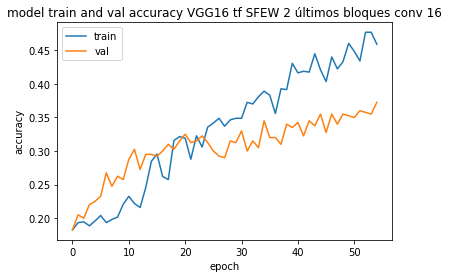

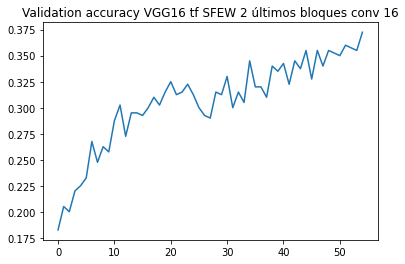

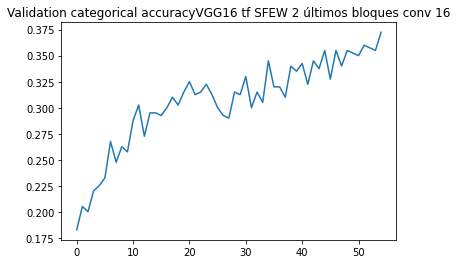

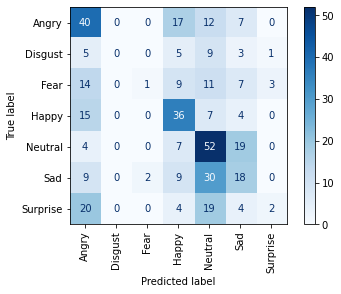

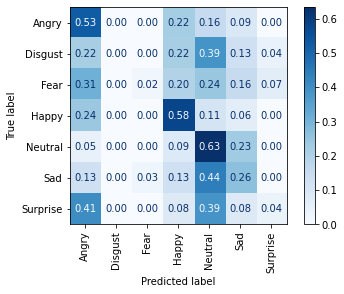

<Figure size 432x288 with 0 Axes>

In [ ]:
#TF descongelant els 2 últims blocs:

dropout = 0.25
epochs = 100
batch_size=16

from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
classes_sfew=["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
dataugmentation=True
path=""

print("-------------------------------------")
print("batch_size: ",batch_size)

SFEW_train_set,SFEW_test_set=create_sets(dataugmentation,SFEW_train_dir,SFEW_test_dir,batch_size,classes_sfew,color_mode="rgb")
train_steps=int(len(SFEW_train_set.labels)/batch_size)
test_steps=int(len(SFEW_test_set.labels)/batch_size)

model=create_model(11,dropout=0.5)

model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),metrics=['accuracy','categorical_accuracy'])
E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",min_delta=0,patience=10,verbose=1,mode="auto",restore_best_weights=True)

callbacks_list = [E_stopping]

history=model.fit_generator(
        SFEW_train_set,
        steps_per_epoch=train_steps,
        epochs=epochs,
        validation_data=SFEW_test_set,
        validation_steps=test_steps,
        # class_weight=class_weight_dict,
        callbacks=callbacks_list)

title="VGG16 tf SFEW 2 últimos bloques conv "+str(batch_size)
plot_model(history,title)
figure_path=path+"batch_"+str(batch_size)
plot_conf_matrix(SFEW_test_set,model,figure_path,title,standard_format=True,percentages=True,save_plot=True)
model.save("VGG_TF_last2convblocks.h5")

In [ ]:
dropout = 0.25
epochs = 55
batch_size=2

from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
classes_sfew=["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
dataugmentation=True
path=""

print("-------------------------------------")
print("batch_size: ",batch_size)

SFEW_train_set,SFEW_test_set=create_sets(dataugmentation,SFEW_train_dir,SFEW_test_dir,batch_size,classes_sfew,color_mode="rgb")
train_steps=int(len(SFEW_train_set.labels)/batch_size)
test_steps=int(len(SFEW_test_set.labels)/batch_size)

model=create_model(11,dropout=0.5)

model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),metrics=['accuracy','categorical_accuracy'])
E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",min_delta=0,patience=10,verbose=1,mode="auto",restore_best_weights=True)

callbacks_list = [E_stopping]

history=model.fit_generator(
        SFEW_train_set,
        steps_per_epoch=train_steps,
        epochs=epochs,
        validation_data=SFEW_test_set,
        validation_steps=test_steps,
        # class_weight=class_weight_dict,
        callbacks=callbacks_list)

title="VGG16 tf SFEW 2 últimos bloques conv "+str(batch_size)
plot_model(history,title)
figure_path=path+"batch_"+str(batch_size)
plot_conf_matrix(SFEW_test_set,model,figure_path,title,standard_format=True,percentages=True,save_plot=True)
model.save("VGG_TF_last2convblocks.h5")

-------------------------------------
batch_size:  2
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


429/429 [==============================] - 33s 72ms/step - loss: 2.0714 - accuracy: 0.2170 - categorical_accuracy: 0.2170 - val_loss: 1.8830 - val_accuracy: 0.2277 - val_categorical_accuracy: 0.2277
Epoch 2/55
429/429 [==============================] - 30s 70ms/step - loss: 1.9051 - accuracy: 0.2135 - categorical_accuracy: 0.2135 - val_loss: 1.8873 - val_accuracy: 0.2698 - val_categorical_accuracy: 0.2698
Epoch 3/55
429/429 [==============================] - 30s 70ms/step - loss: 1.8369 - accuracy: 0.2882 - categorical_accuracy: 0.2882 - val_loss: 1.8254 - val_accuracy: 0.2896 - val_categorical_accuracy: 0.2896
Epoch 4/55
429/429 [==============================] - 30s 69ms/step - loss: 1.7449 - accuracy: 0.3407 - categorical_accuracy: 0.3407 - val_loss: 1.7894 - val_accuracy: 0.2970 - val_categorical_accuracy: 0.2970
Epoch 5/55
429/429 [==============================] - 30s 70ms/step - loss: 1.6873 - accuracy: 0.3454 - categorical_accuracy: 0.3454 - val_loss: 1.7696 - val_accuracy: 0.2

In [ ]:
#TF descongelant els 2 últims blocs:

dropout = 0.25
epochs = 100
batch_size=16

from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
classes_sfew=["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
dataugmentation=True
path=""

print("-------------------------------------")
print("batch_size: ",batch_size)

SFEW_train_set,SFEW_test_set=create_sets(dataugmentation,SFEW_train_dir,SFEW_test_dir,batch_size,classes_sfew,color_mode="rgb")
train_steps=int(len(SFEW_train_set.labels)/batch_size)
test_steps=int(len(SFEW_test_set.labels)/batch_size)

model=create_model(11,dropout=0.5)

model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),metrics=['accuracy','categorical_accuracy'])
E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",min_delta=0,patience=10,verbose=1,mode="auto",restore_best_weights=True)

callbacks_list = [E_stopping]

history=model.fit_generator(
        SFEW_train_set,
        steps_per_epoch=train_steps,
        epochs=epochs,
        validation_data=SFEW_test_set,
        validation_steps=test_steps,
        # class_weight=class_weight_dict,
        callbacks=callbacks_list)

title="VGG16 tf SFEW 2 últimos bloques conv "+str(batch_size)
plot_model(history,title)
figure_path=path+"batch_"+str(batch_size)
plot_conf_matrix(SFEW_test_set,model,figure_path,title,standard_format=True,percentages=True,save_plot=True)
model.save("VGG_TF_last2convblocks.h5")

In [ ]:
#TF primero entrenar solo las capas densas añadidas, luego descongelar el último bloque conv y luego descongelar el penúltimo bloque conv:

In [ ]:
model=create_model(19,0.5)

VGG_summary:
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)

-------------------------------------
batch_size:  16
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
VGG_summary:
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/55
53/53 [==============================] - 13s 181ms/step - loss: 2.2346 - accuracy: 0.1839 - categorical_accuracy: 0.1839 - val_loss: 1.9563 - val_accuracy: 0.1775 - val_categorical_accuracy: 0.1775
Epoch 2/55
53/53 [==============================] - 8s 144ms/step - loss: 2.1017 - accuracy: 0.1874 - categorical_accuracy: 0.1874 - val_loss: 1.9202 - val_accuracy: 0.1750 - val_categorical_accuracy: 0.1750
Epoch 3/55
53/53 [==============================] - 8s 143ms/step - loss: 2.1191 - accuracy: 0.1767 - categorical_accuracy: 0.1767 - val_loss: 1.9148 - val_accuracy: 0.1875 - val_categorical_accuracy: 0.1875
Epoch 4/55
53/53 [==============================] - 8s 145ms/step - loss: 2.0521 - accuracy: 0.2052 - categorical_accuracy: 0.2052 - val_loss: 1.9072 - val_accuracy: 0.1925 - val_categorical_accuracy: 0.1925
Epoch 5/55
53/53 [==============================] - 8s 145ms/step - loss: 2.0484 - accuracy: 0.1910 - categorical_accuracy: 0.1910 - val_loss: 1.9054 - val_accuracy: 0

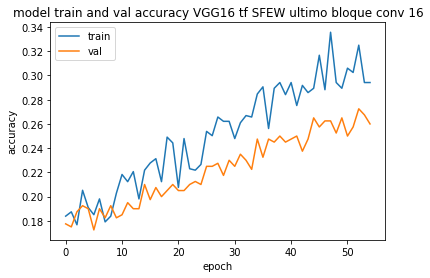

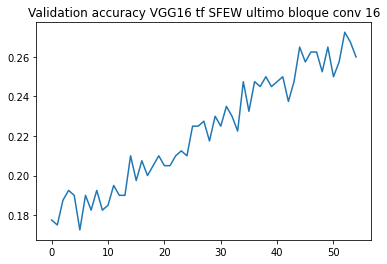

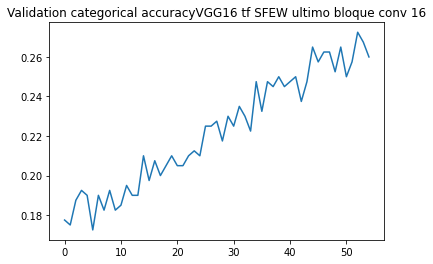

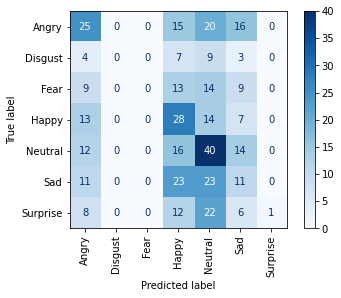

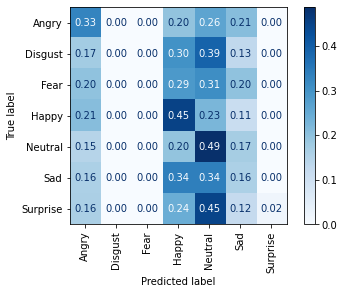

<Figure size 432x288 with 0 Axes>

In [ ]:
#Entrenar solo las capas añadidas
dropout = 0.25
LR = 0.0001
epochs = 55
batch_sz=[2,16,32,64,128]
batch_sz=[2,8,16,32,64]
# batch_size=16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
classes_sfew=["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
dataugmentation=True

path=""
batch_size=16

print("-------------------------------------")
print("batch_size: ",batch_size)

SFEW_train_set,SFEW_test_set=create_sets(dataugmentation,SFEW_train_dir,SFEW_test_dir,batch_size,classes_sfew,color_mode="rgb")
train_steps=int(len(SFEW_train_set.labels)/batch_size)
test_steps=int(len(SFEW_test_set.labels)/batch_size)
model=create_model(19,0.5)

model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),metrics=['accuracy','categorical_accuracy'])
E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",min_delta=0,patience=10,verbose=1,mode="auto",restore_best_weights=True)

callbacks_list = [E_stopping]

history=model.fit_generator(
        SFEW_train_set,
        steps_per_epoch=train_steps,
        epochs=epochs,
        validation_data=SFEW_test_set,
        validation_steps=test_steps,
        # class_weight=class_weight_dict,
        callbacks=callbacks_list)

title="VGG16 tf SFEW ultimo bloque conv "+str(batch_size)
plot_model(history,title)
figure_path=path+"batch_"+str(batch_size)
plot_conf_matrix(SFEW_test_set,model,figure_path,title,standard_format=True,percentages=True,save_plot=True)

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [ ]:
# descongelar los pesos del último bloque convolucional:

for layer in model.layers[-8:-1]:
    print("unfreezing layer: ",layer.name)
    layer.trainable = True


unfreezing layer:  block5_conv1
unfreezing layer:  block5_conv2
unfreezing layer:  block5_conv3
unfreezing layer:  block5_pool
unfreezing layer:  flatten_8
unfreezing layer:  dense_16
unfreezing layer:  dropout_11


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/55
53/53 [==============================] - 9s 156ms/step - loss: 1.7613 - accuracy: 0.2883 - categorical_accuracy: 0.2883 - val_loss: 1.8435 - val_accuracy: 0.2650 - val_categorical_accuracy: 0.2650
Epoch 2/55
53/53 [==============================] - 8s 152ms/step - loss: 1.7459 - accuracy: 0.3203 - categorical_accuracy: 0.3203 - val_loss: 1.8402 - val_accuracy: 0.2675 - val_categorical_accuracy: 0.2675
Epoch 3/55
53/53 [==============================] - 8s 151ms/step - loss: 1.7392 - accuracy: 0.3231 - categorical_accuracy: 0.3231 - val_loss: 1.8414 - val_accuracy: 0.2875 - val_categorical_accuracy: 0.2875
Epoch 4/55
53/53 [==============================] - 8s 152ms/step - loss: 1.7365 - accuracy: 0.3393 - categorical_accuracy: 0.3393 - val_loss: 1.8398 - val_accuracy: 0.2800 - val_categorical_accuracy: 0.2800
Epoch 5/55
53/53 [==============================] - 8s 153ms/step - loss: 1.7418 - accuracy: 0.3238 - categorical_accuracy: 0.3238 - val_loss: 1.8424 - val_accuracy: 0.

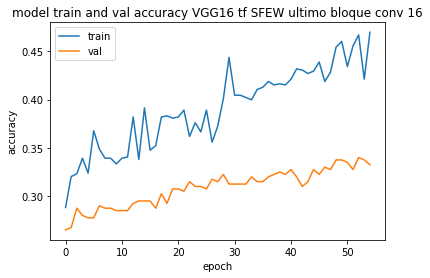

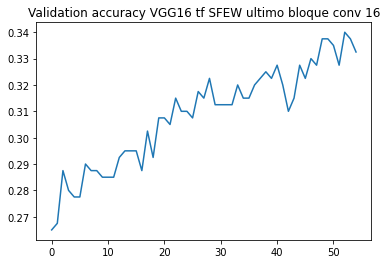

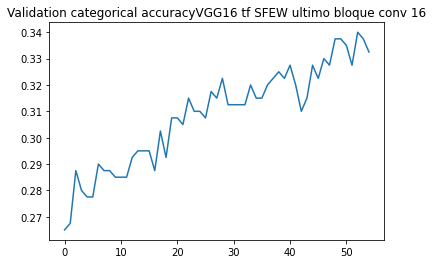

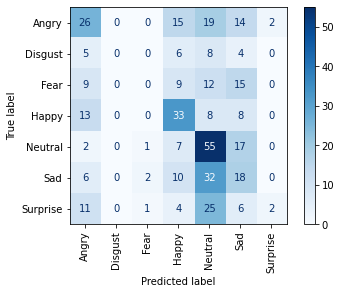

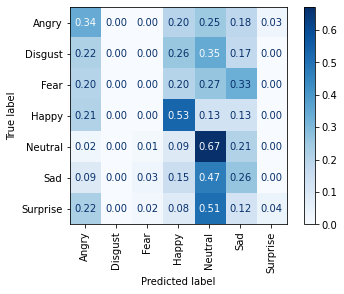

<Figure size 432x288 with 0 Axes>

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),metrics=['accuracy','categorical_accuracy'])
history=model.fit_generator(
    SFEW_train_set,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=SFEW_test_set,
    validation_steps=test_steps,
    # class_weight=class_weight_dict,
    callbacks=callbacks_list)

title="VGG16 tf SFEW ultimo bloque conv "+str(batch_size)
plot_model(history,title)
figure_path=path+"batch_"+str(batch_size)
plot_conf_matrix(SFEW_test_set,model,figure_path,title,standard_format=True,percentages=True,save_plot=True)

In [ ]:
for layer in model.layers[-12:-1]:
    print("unfreezing layer: ",layer.name)
    layer.trainable = True

unfreezing layer:  block4_conv1
unfreezing layer:  block4_conv2
unfreezing layer:  block4_conv3
unfreezing layer:  block4_pool
unfreezing layer:  block5_conv1
unfreezing layer:  block5_conv2
unfreezing layer:  block5_conv3
unfreezing layer:  block5_pool
unfreezing layer:  flatten_8
unfreezing layer:  dense_16
unfreezing layer:  dropout_11


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/55
53/53 [==============================] - 10s 167ms/step - loss: 1.4811 - accuracy: 0.4603 - categorical_accuracy: 0.4603 - val_loss: 1.7556 - val_accuracy: 0.3250 - val_categorical_accuracy: 0.3250
Epoch 2/55
53/53 [==============================] - 8s 158ms/step - loss: 1.4554 - accuracy: 0.4567 - categorical_accuracy: 0.4567 - val_loss: 1.7412 - val_accuracy: 0.3475 - val_categorical_accuracy: 0.3475
Epoch 3/55
53/53 [==============================] - 8s 157ms/step - loss: 1.4608 - accuracy: 0.4792 - categorical_accuracy: 0.4792 - val_loss: 1.7411 - val_accuracy: 0.3375 - val_categorical_accuracy: 0.3375
Epoch 4/55
53/53 [==============================] - 8s 158ms/step - loss: 1.4361 - accuracy: 0.4709 - categorical_accuracy: 0.4709 - val_loss: 1.7311 - val_accuracy: 0.3600 - val_categorical_accuracy: 0.3600
Epoch 5/55
53/53 [==============================] - 8s 158ms/step - loss: 1.4497 - accuracy: 0.4816 - categorical_accuracy: 0.4816 - val_loss: 1.7309 - val_accuracy: 0

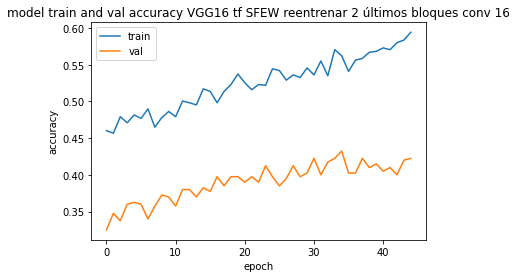

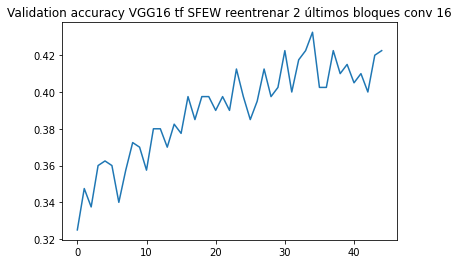

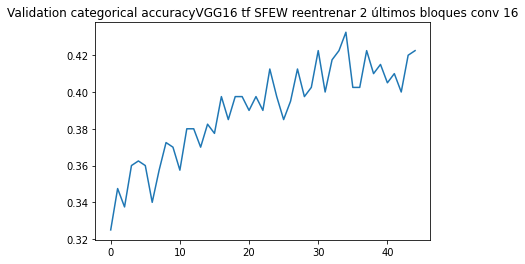

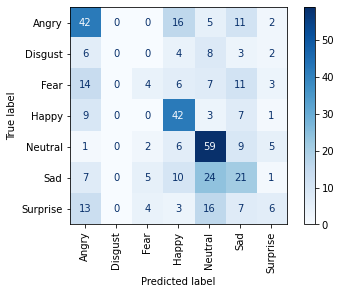

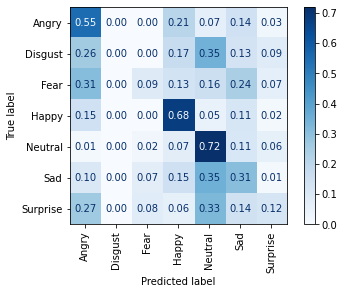

<Figure size 432x288 with 0 Axes>

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),metrics=['accuracy','categorical_accuracy'])
history=model.fit_generator(
    SFEW_train_set,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=SFEW_test_set,
    validation_steps=test_steps,
    # class_weight=class_weight_dict,
    callbacks=callbacks_list)

title="VGG16 tf SFEW reentrenar 2 últimos bloques conv "+str(batch_size)
plot_model(history,title)
figure_path=path+"batch_"+str(batch_size)
plot_conf_matrix(SFEW_test_set,model,figure_path,title,standard_format=True,percentages=True,save_plot=True)

In [ ]:
model.save("VGG16_2conv_blocs_retrained.h5")

In [ ]:
model.save("/content/gdrive/MyDrive/VGG16_2conv_blocs_retrained.h5")


In [ ]:
#Reentrenar último bloque solo 

In [ ]:
#9/10

-------------------------------------
batch_size:  16
Found 859 images belonging to 7 classes.
Found 405 images belonging to 7 classes.
VGG_summary:
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/55
53/53 [==============================] - 10s 175ms/step - loss: 2.2100 - accuracy: 0.1495 - categorical_accuracy: 0.1495 - val_loss: 1.9288 - val_accuracy: 0.1600 - val_categorical_accuracy: 0.1600
Epoch 2/55
53/53 [==============================] - 9s 166ms/step - loss: 2.0680 - accuracy: 0.1969 - categorical_accuracy: 0.1969 - val_loss: 1.9258 - val_accuracy: 0.1950 - val_categorical_accuracy: 0.1950
Epoch 3/55
53/53 [==============================] - 9s 165ms/step - loss: 2.0361 - accuracy: 0.1851 - categorical_accuracy: 0.1851 - val_loss: 1.9151 - val_accuracy: 0.2000 - val_categorical_accuracy: 0.2000
Epoch 4/55
53/53 [==============================] - 9s 165ms/step - loss: 2.0432 - accuracy: 0.1969 - categorical_accuracy: 0.1969 - val_loss: 1.9087 - val_accuracy: 0.2000 - val_categorical_accuracy: 0.2000
Epoch 5/55
53/53 [==============================] - 9s 166ms/step - loss: 1.9748 - accuracy: 0.2076 - categorical_accuracy: 0.2076 - val_loss: 1.9072 - val_accuracy: 0

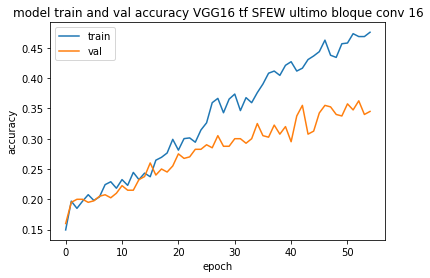

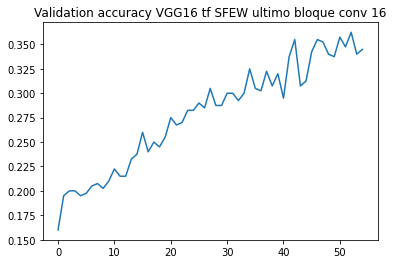

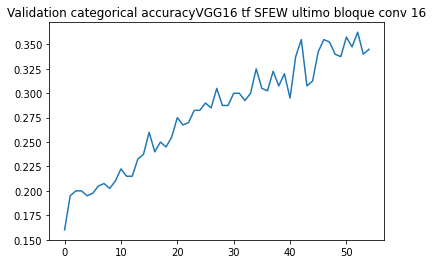

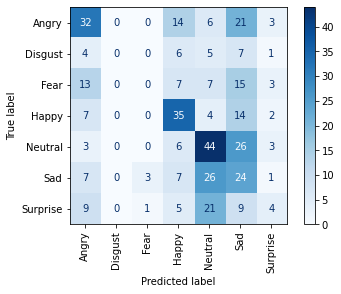

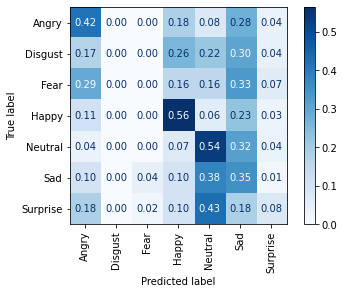

<Figure size 432x288 with 0 Axes>

In [ ]:
dropout = 0.25
LR = 0.0001
epochs = 55
batch_sz=[2,16,32,64,128]
batch_sz=[2,8,16,32,64]
# batch_size=16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
classes_sfew=["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
dataugmentation=True

path=""
batch_size=16

print("-------------------------------------")
print("batch_size: ",batch_size)

SFEW_train_set,SFEW_test_set=create_sets(dataugmentation,SFEW_train_dir,SFEW_test_dir,batch_size,classes_sfew,color_mode="rgb")
train_steps=int(len(SFEW_train_set.labels)/batch_size)
test_steps=int(len(SFEW_test_set.labels)/batch_size)
model=create_model(16,0.5)

model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),metrics=['accuracy','categorical_accuracy'])
E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",min_delta=0,patience=10,verbose=1,mode="auto",restore_best_weights=True)

callbacks_list = [E_stopping]

history=model.fit_generator(
        SFEW_train_set,
        steps_per_epoch=train_steps,
        epochs=epochs,
        validation_data=SFEW_test_set,
        validation_steps=test_steps,
        # class_weight=class_weight_dict,
        callbacks=callbacks_list)

title="VGG16 tf SFEW ultimo bloque conv "+str(batch_size)
plot_model(history,title)
figure_path=path+"batch_"+str(batch_size)
plot_conf_matrix(SFEW_test_set,model,figure_path,title,standard_format=True,percentages=True,save_plot=True)

In [ ]:
samples=[]
import os

classes_sfew=["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

for c in classes_sfew:
  os.listdir("/content/SFEW_dataset/Train/"+c)
  num_samples=len(list(os.listdir("/content/SFEW_dataset/Train/"+c+"/")))
  samples.append(samples)
  print("class:",c, " has ",num_samples," samples")

samples2=[172,49,76,176,142,151,93]

class: Angry  has  172  samples
class: Disgust  has  49  samples
class: Fear  has  76  samples
class: Happy  has  176  samples
class: Neutral  has  142  samples
class: Sad  has  151  samples
class: Surprise  has  93  samples


In [ ]:

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes_sfew,samples2)
plt.show()

In [ ]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(SFEW_train_set.classes), 
            SFEW_train_set.classes)
class_weights
indices=[0,1,2,3,4,5,6]
class_weight_dict=dict(zip(indices,class_weights))
class_weight_dict



# import tensorflow as tf
# x,y = test_set.next()

# for i in range(15):
    
#     image = x[i*5]
#     plt.imshow( tf.squeeze(image),cmap='gray')
#     print(get_emo(y[i*5]))
#     print(get_predicted_emo(prediction))
#     plt.show()

{0: 0.7134551495016611,
 1: 2.5043731778425657,
 2: 1.6146616541353382,
 3: 0.6972402597402597,
 4: 0.864185110663984,
 5: 0.8126773888363292,
 6: 1.3195084485407067}

In [ ]:
#FIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIN

In [ ]:
datagen = ImageDataGenerator(rescale=1. / 255)
test_set = datagen.flow_from_directory(
    '/content/FACES_ordenat/Test2',
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False)


evaluate = model0_FACES.evaluate(test_set)
print("Modelo_base: ",evaluate)

evaluate = model_0_ES.evaluate(test_set)
print("Modelo_base EarlyStopping: ",evaluate)


Found 1026 images belonging to 6 classes.
1026/1026 [==============================] - 226s 191ms/step - loss: 0.7524 - categorical_accuracy: 0.7212 - accuracy: 0.7212
Modelo_base:  [0.7523725032806396, 0.7212475538253784, 0.7212475538253784]
1026/1026 [==============================] - 182s 177ms/step - loss: 0.9430 - accuracy: 0.6764 - categorical_accuracy: 0.6764
Modelo_base EarlyStopping:  [0.9430367350578308, 0.6764132380485535, 0.6764132380485535]


In [ ]:
# print(test_loss," ",test_acc)
y_true=test_set.labels
labels=[key for key in test_set.class_indices.keys()]

predictions=model0_FACES.predict(test_set)
predictions_ES=model_0_ES.predict(test_set)

In [ ]:
print('Confusion Matrix')
ypred=[round(list(i).index(max(i))) for i in predictions]
print(confusion_matrix(test_set.classes, ypred)[:,:])
# print(test_set.label_indices)
print("_________________")
print('Confusion Matrix')
ypred_ES=[round(list(i).index(max(i))) for i in predictions_ES]
print(confusion_matrix(test_set.classes, ypred_ES)[:,:])

Confusion Matrix
[[132   4   0   0  26   9]
 [ 14 102   2   0  41  12]
 [  1   1 133   1  34   1]
 [  3   0   4 132  31   1]
 [  0   0   0   0 171   0]
 [ 15   3   4   1  78  70]]
_________________
Confusion Matrix
[[129   4   3   1  21  13]
 [ 33  59  18   5  22  34]
 [  2   1 137   5  20   6]
 [  0   0   6 156   7   2]
 [ 10   1   7   0 150   3]
 [ 23   3  29   4  49  63]]


[[132   4   0   0  26   9]
 [ 14 102   2   0  41  12]
 [  1   1 133   1  34   1]
 [  3   0   4 132  31   1]
 [  0   0   0   0 171   0]
 [ 15   3   4   1  78  70]]


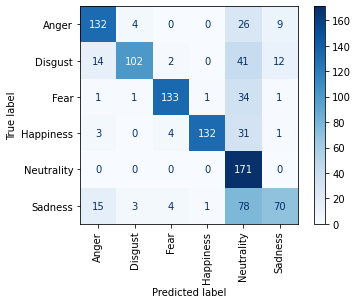

<Figure size 432x288 with 0 Axes>

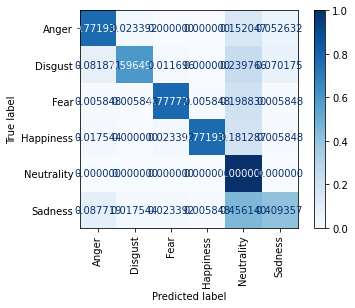

[[129   4   3   1  21  13]
 [ 33  59  18   5  22  34]
 [  2   1 137   5  20   6]
 [  0   0   6 156   7   2]
 [ 10   1   7   0 150   3]
 [ 23   3  29   4  49  63]]


<Figure size 432x288 with 0 Axes>

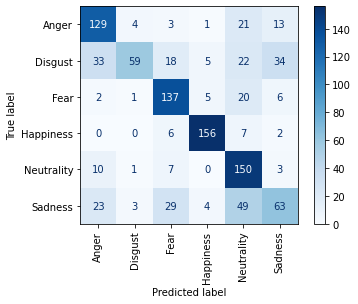

<Figure size 432x288 with 0 Axes>

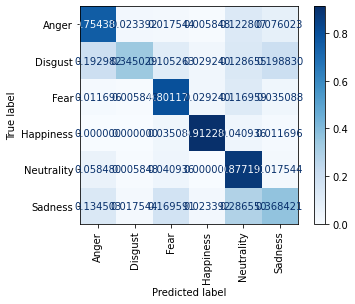

<Figure size 432x288 with 0 Axes>

In [ ]:
path='/content/gdrive/MyDrive/figures/modelo0'
title="modelo_0 50 epochs entrenado con el FACES evaluado con el test set del FACES"
plot_conf_matrix(test_set,model0_FACES,path,title,standard_format=True,percentages=True,save_plot=True)

path='/content/gdrive/MyDrive/figures/modelo0_ES'
title="modelo_0 ES entrenado con el FACES evaluado con el test set del FACES"
plot_conf_matrix(test_set,model_0_ES,path,title,standard_format=True,percentages=True,save_plot=True)

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred)

<Figure size 432x288 with 0 Axes>

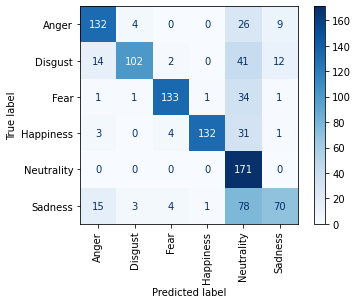

<Figure size 432x288 with 0 Axes>

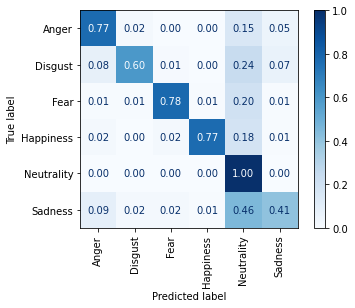

___________________


<Figure size 432x288 with 0 Axes>

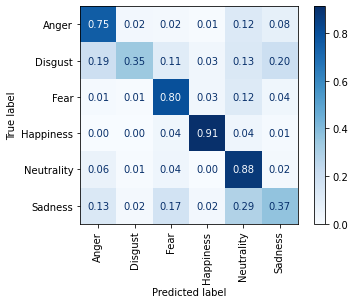

<Figure size 432x288 with 0 Axes>

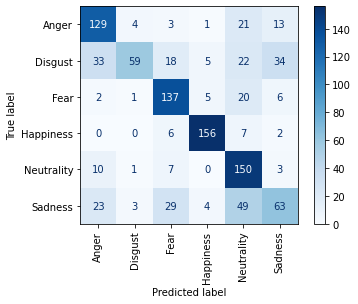

In [ ]:
#MODELO EVALUADO CON EL SET DE TEST DEL FACES:

#modelo sin ES entrenado durante 50 epochs
plt.figure()
cm = confusion_matrix(y_true, ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues,xticks_rotation='vertical',values_format='d')
plt.show()

#matriz de confusión en porcentages 
plt.figure()
cm = confusion_matrix(y_true, ypred,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues,xticks_rotation='vertical',values_format='.2f')
plt.show()
print("___________________")

#modelo con ES:
plt.figure()
cm = confusion_matrix(y_true, ypred_ES,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues,xticks_rotation='vertical',values_format='.2f')
plt.show()

#matriz de confusión en porcentages:
plt.figure()
cm = confusion_matrix(y_true, ypred_ES)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues,xticks_rotation='vertical',values_format='d')
plt.show()



In [ ]:
#Reentrenamos el modelo con el SFEW:

In [ ]:
plt.savefig('confusion_matrix_.png')

In [ ]:
! ls SFEW_dataset/Train
! ls /content/FACES_ordenat/Train2

ls: cannot access 'SFEW_dataset/Train': No such file or directory
Anger  Disgust	Fear  Happiness  Neutrality  Sadness


Todas menos Surprise son comunes


In [ ]:
def plot_conf_matrix(test_set,modelo,path,title,standard_format=True,percentages=True,save_plot=True):
  y_true=test_set.labels
  print(len(y_true))
  labels=[key for key in test_set.class_indices.keys()]
  predictions=modelo.predict(test_set)
  ypred=[round(list(i).index(max(i))) for i in predictions]
  print(confusion_matrix(test_set.classes, ypred)[:,:])
  print("                    ")
  f1=f1_score(y_true, ypred,average=None)
  f1_w=f1_score(y_true, ypred,average='weighted')
  print("f1 score:",f1)
  print("f1 score weighted:",f1_w)
  print("---------------------------------------------------------")
  print(title)
  if standard_format:

    cm = confusion_matrix(y_true, ypred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues,xticks_rotation='vertical',values_format='d')
    if save_plot:
      plt.savefig(path+".png")
    plt.show()
  print("                    ")
  if standard_format:

    cm = confusion_matrix(y_true, ypred,normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues,xticks_rotation='vertical',values_format='.2f')
    plt.show()
    if save_plot:
      plt.savefig(path+"_perctg.png")
    plt.show()
  print("                    ")
  print("                    ")
    

356
[[12  7  2 47  5  3]
 [ 2  2  1 15  1  2]
 [ 8  5  1 26  2  3]
 [ 7  9  1 32  8  5]
 [12 12  0 40  9  9]
 [ 8  7  2 43  1  7]]
                    
f1 score: [0.192      0.06153846 0.03846154 0.24150943 0.16666667 0.1443299 ]
f1 score weighted: 0.15784505170834723
---------------------------------------------------------
modelo_0 50 epochs entrenado con el FACES evaluado con el test set del FACES


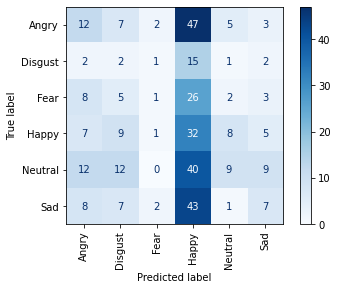

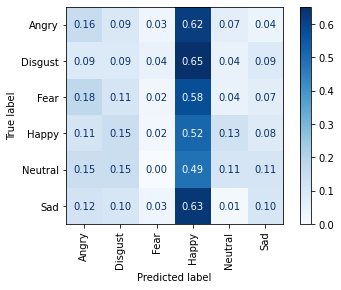

<Figure size 432x288 with 0 Axes>

                    
                    
356
[[14  0 25 32  2  3]
 [ 3  0  7 12  0  1]
 [11  0 15 12  4  3]
 [ 7  0 29 20  2  4]
 [13  0 26 36  4  3]
 [15  0 21 26  2  4]]
                    
f1 score: [0.20143885 0.         0.17857143 0.2        0.08333333 0.09302326]
f1 score weighted: 0.13737073464152266
---------------------------------------------------------
modelo_0 ES entrenado con el FACES evaluado con el test set del FACES


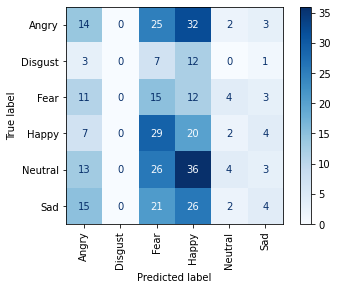

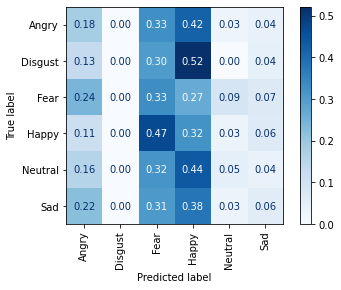

<Figure size 432x288 with 0 Axes>

In [ ]:
path='/content/gdrive/MyDrive/figures/modelo0_SFEW'
title="modelo_0 50 epochs entrenado con el FACES evaluado con el test set del FACES"
plot_conf_matrix(test_set,model0_FACES,path,title,standard_format=True,percentages=True,save_plot=True)

path='/content/gdrive/MyDrive/figures/modelo0_ES_SFEW'
title="modelo_0 ES entrenado con el FACES evaluado con el test set del FACES"
plot_conf_matrix(test_set,model_0_ES,path,title,standard_format=True,percentages=True,save_plot=True)

In [ ]:

HEIGHT,WIDTH=128,128 #143 x 181
train_data_dir = faces
validation_data_dir = 'FACES_ordenat/Test2'
num_classes=6
dropout = 0.25
LR = 0.00001
epochs = 50
batch_size = 1
N_OUTPUT_LABELS=6
CHANNELS=1
dataugmentation=False

In [ ]:
def CNNmodel(dropout):
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), 
                     input_shape = (HEIGHT, 
                                    WIDTH,CHANNELS), 
                     activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))#--
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3),activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout*2))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(N_OUTPUT_LABELS, activation='softmax'))
    return model

model1 = CNNmodel(dropout)

NameError: ignored

In [ ]:

def CNNClassifier_2():
    model = Sequential()

    model.add(Conv2D(filters=64,
                     kernel_size=(3, 3),
                     strides=1,
                     padding="same",
                     activation='relu',
                     input_shape=(HEIGHT, WIDTH, CHANNELS)))

    model.add(MaxPooling2D(pool_size=(3, 3),
                           strides=2))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=128,
                     kernel_size=(5, 5),
                     strides=1,
                     padding="same",
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3),
                           strides=2))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=512,
                     kernel_size=(3, 3),
                     strides=1,
                     padding="same",
                     activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(3, 3),strides=2))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Conv2D(filters=512,
                    kernel_size=(3, 3),
                    strides=1,
                    padding="same",
                    activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3),strides=2))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
     
    model.add(Flatten())
    model.add(Dense(units=256,
                    activation='relu'))

    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(units=512,
                    activation='relu'))

    model.add(BatchNormalization())
    model.add(Dropout(dropout*2))

    model.add(Dense(units=N_OUTPUT_LABELS,
                    activation='softmax'))

    return model

model2=CNNClassifier_2()

In [ ]:
def create_sets(dataugmentation,train_data_dir,validation_data_dir,batch_size):

  if dataugmentation==True:
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   brightness_range=[0.5,1.0],
                                   zoom_range=0.1,
                                   shear_range=0.2,
                                  #  height_shift_range=0.1,
                                   horizontal_flip=True)
                                  #  height_shift_range=0.1
  else:

    train_datagen = ImageDataGenerator(rescale=1. / 255)

  test_datagen= ImageDataGenerator(rescale=1. / 255)

  train_set = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(WIDTH, HEIGHT),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    classes=['Angry','Disgust','Fear','Happy','Neutral','Sad'],
    shuffle=True)
  
  test_set = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(WIDTH, HEIGHT),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    classes=['Angry','Disgust','Fear','Happy','Neutral','Sad'],
    shuffle=True)
  
  return train_set,test_set

In [ ]:
train_dir='/content/SFEW_dataset/Train'
test_dir='/content/SFEW_dataset/Val'
datagen = ImageDataGenerator(rescale=1. / 255)

train_set = datagen.flow_from_directory(
    train_dir,
    classes=['Angry','Disgust','Fear','Happy','Neutral','Sad'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True)

nb_train_samples = len(train_set.filenames)

test_set = datagen.flow_from_directory(
    test_dir,
    classes=['Angry','Disgust','Fear','Happy','Neutral','Sad'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True)

nb_test_samples = len(test_set.filenames)

Found 766 images belonging to 6 classes.
Found 356 images belonging to 6 classes.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


766
356


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
766/766 [==============================] - 11s 14ms/step - loss: 2.7686 - accuracy: 0.2520 - categorical_accuracy: 0.2520 - val_loss: 2.1624 - val_accuracy: 0.2275 - val_categorical_accuracy: 0.2275
Epoch 2/50
766/766 [==============================] - 10s 13ms/step - loss: 2.0050 - accuracy: 0.3368 - categorical_accuracy: 0.3368 - val_loss: 2.1066 - val_accuracy: 0.2331 - val_categorical_accuracy: 0.2331
Epoch 3/50
766/766 [==============================] - 10s 13ms/step - loss: 1.6804 - accuracy: 0.4034 - categorical_accuracy: 0.4034 - val_loss: 2.0634 - val_accuracy: 0.2444 - val_categorical_accuracy: 0.2444
Epoch 4/50
766/766 [==============================] - 10s 13ms/step - loss: 1.4979 - accuracy: 0.4504 - categorical_accuracy: 0.4504 - val_loss: 2.0442 - val_accuracy: 0.2500 - val_categorical_accuracy: 0.2500
Epoch 5/50
766/766 [==============================] - 10s 13ms/step - loss: 1.3384 - accuracy: 0.5052 - categorical_accuracy: 0.5052 - val_loss: 2.0774 - val_ac

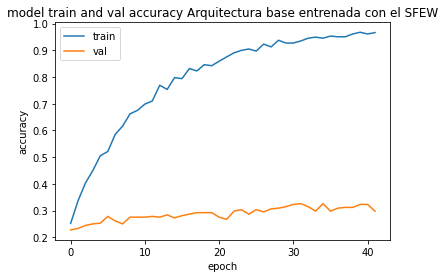

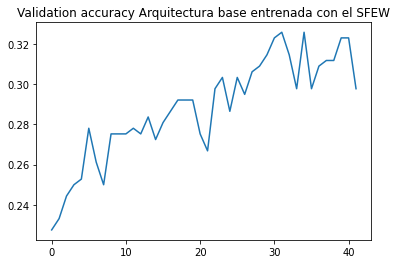

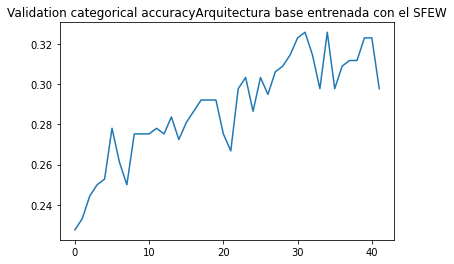

In [ ]:
#Reentrenar el modelo entrenado con el FACES con el SFEW:

# train_set,test_set=create_sets(dataugmentation,train_data_dir,validation_data_dir,batch_size)

HEIGHT,WIDTH=128,128 #143 x 181
# train_data_dir = 'FACES_ordenat/Train2'
# validation_data_dir = 'FACES_ordenat/Test2'
num_classes=6
dropout = 0.25
LR = 0.00001
epochs = 50
batch_size = 1
N_OUTPUT_LABELS=6
CHANNELS=1
dataugmentation=False

dir="/content/gdrive/MyDrive/TFM_MUSIcorrected_test/"
model_0_ES=keras.models.load_model('/content/gdrive/MyDrive/saved_models/modelo_base_FACES_ES.h5') # modelo entrenado utilizando EarlyStopping

history_0=compile_train_model(LR, epochs ,dir, batch_size,model_0_ES)


title="Arquitectura base entrenada con el SFEW"
plot_model(history_0,title)

model_0_ES.save("/content/gdrive/MyDrive/saved_models/modelo_base0_SFEW_post_FACES.h5")

356
[[ 8  1  3 22 25 17]
 [ 9  0  3  5  5  1]
 [ 8  0  3  8 20  6]
 [ 9  1  3 22 20  7]
 [10  0  8 28 27  9]
 [ 4  0  3 27 29  5]]
                    
f1 score: [0.12903226 0.         0.08823529 0.25287356 0.25961538 0.08849558]
f1 score weighted: 0.15944202646416675
---------------------------------------------------------
modelo_0 5reentrenado con el SFEW


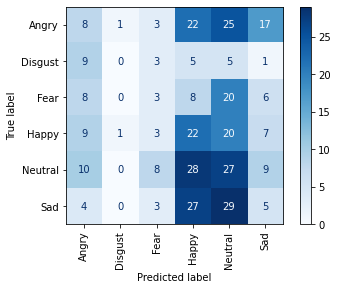

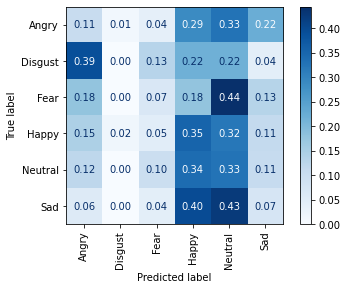

<Figure size 432x288 with 0 Axes>

In [ ]:
path='/content/gdrive/MyDrive/figures/modelo0_reentrenado_SFEW'
title="modelo_0 5reentrenado con el SFEW"
plot_conf_matrix(test_set,model_0_ES,path,title,standard_format=True,percentages=True,save_plot=True)

In [ ]:
HEIGHT,WIDTH=128,128 #143 x 181
train_dir='/content/SFEW_dataset/Train'
test_dir='/content/SFEW_dataset/Val'
num_classes=6
dropout = 0.25
LR = 0.00001
epochs = 50
batch_size = 1
N_OUTPUT_LABELS=6
CHANNELS=1
dataugmentation=True

#Lo mismo con dataugmentation:
create_sets(dataugmentation,train_dir,test_dir,batch_size)
dir="/content/gdrive/MyDrive/TFM_MUSIcorrected_test/"
model_0_ES=keras.models.load_model('/content/gdrive/MyDrive/saved_models/modelo_base_FACES_ES.h5') # modelo entrenado utilizando EarlyStopping

history_0=compile_train_model(LR, epochs ,dir, batch_size,model_0_ES)


title="Arquitectura base entrenada con el SFEW dataugmentation"
plot_model(history_0,title)

model_0_ES.save("/content/gdrive/MyDrive/saved_models/modelo_base0_SFEW_post_FACES_dataug.h5")
plot_conf_matrix(test_set,model_0_ES,path,title,standard_format=True,percentages=True,save_plot=True)


NameError: ignored

Found 766 images belonging to 6 classes.
Found 356 images belonging to 6 classes.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


47
22


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
47/47 [==============================] - 2s 25ms/step - loss: 4.0224 - accuracy: 0.1702 - categorical_accuracy: 0.1702 - val_loss: 1.9462 - val_accuracy: 0.1364 - val_categorical_accuracy: 0.1364
Epoch 2/50
47/47 [==============================] - 1s 15ms/step - loss: 3.4807 - accuracy: 0.1915 - categorical_accuracy: 0.1915 - val_loss: 2.2007 - val_accuracy: 0.2273 - val_categorical_accuracy: 0.2273
Epoch 3/50
47/47 [==============================] - 1s 14ms/step - loss: 3.4698 - accuracy: 0.1915 - categorical_accuracy: 0.1915 - val_loss: 2.1406 - val_accuracy: 0.2727 - val_categorical_accuracy: 0.2727
Epoch 4/50
47/47 [==============================] - 1s 15ms/step - loss: 2.9460 - accuracy: 0.1915 - categorical_accuracy: 0.1915 - val_loss: 2.2251 - val_accuracy: 0.1364 - val_categorical_accuracy: 0.1364
Epoch 5/50
47/47 [==============================] - 1s 15ms/step - loss: 3.1468 - accuracy: 0.2128 - categorical_accuracy: 0.2128 - val_loss: 2.3507 - val_accuracy: 0.1818 

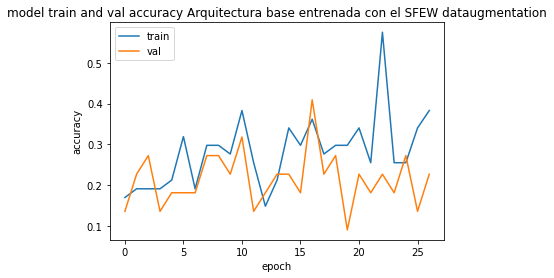

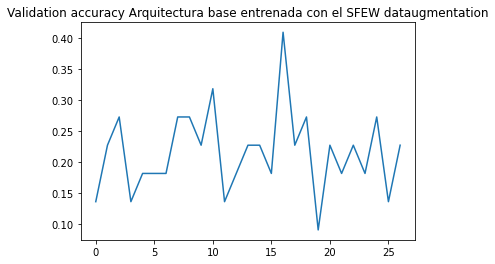

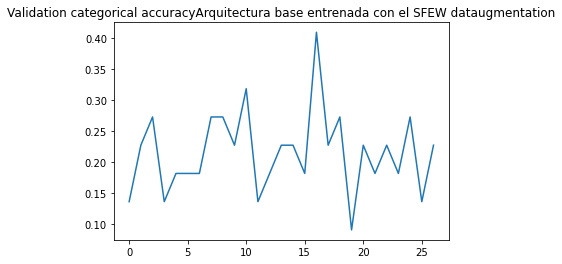

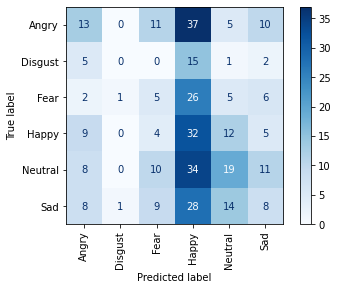

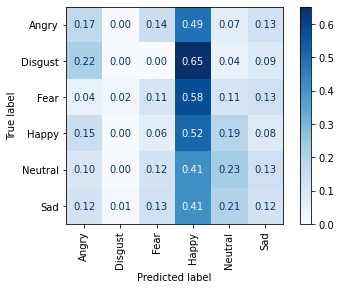

<Figure size 432x288 with 0 Axes>

In [ ]:
batch_size=16
create_sets(dataugmentation,train_dir,test_dir,batch_size)
dir="/content/gdrive/MyDrive/TFM_MUSIcorrected_test/"
model_0_ES=keras.models.load_model('/content/gdrive/MyDrive/saved_models/modelo_base_FACES_ES.h5') # modelo entrenado utilizando EarlyStopping

history_0=compile_train_model(LR, epochs ,dir, batch_size,model_0_ES)


title="Arquitectura base entrenada con el SFEW dataugmentation"
plot_model(history_0,title)

model_0_ES.save("/content/gdrive/MyDrive/saved_models/modelo_base0_SFEW_post_FACES_dataug.h5")
plot_conf_matrix(test_set,model_0_ES,path,title,standard_format=True,percentages=True,save_plot=True)


6 emociones comunes

In [ ]:
# 1) Entrenamos usando la arquitectura base con el FACES 


In [ ]:
datagen = ImageDataGenerator(rescale=1. / 255)

train_set = datagen.flow_from_directory(
    train_dir,
    #classes=['Anger','Disgust','Fear','Happiness','Sadness'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True)

nb_train_samples = len(train_set.filenames)

test_set = datagen.flow_from_directory(
    test_dir,
    # classes=['Anger','Disgust','Fear','Happiness','Sadness'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True)

nb_test_samples = len(test_set.filenames)

Found 1026 images belonging to 6 classes.
Found 1026 images belonging to 6 classes.


In [ ]:
def CNNmodel():
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), 
                     input_shape = ( img_height, img_width,1), 
                     activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))#--
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3),activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout*2))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    return model

In [ ]:
from keras.callbacks import ModelCheckpoint,CSVLogger
filepath="/content/gdrive/My Drive/FACES_SFEW/Test2/:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                              min_delta=0,
                                              patience=40,
                                              verbose=1,
                                              mode="auto",
                                              restore_best_weights=True)

csv_logger = CSVLogger('/content/gdrive/My Drive/TFM_MUSI/training.log')
callbacks_list = [checkpoint,E_stopping]

In [ ]:
Classifier=CNNmodel()
opt=keras.optimizers.SGD(lr=LR)
Classifier.compile(optimizer=opt,
                  loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])

Classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 61, 64)        0

In [ ]:
def plot_model(history,title):
  plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  # plt.plot(history.history['val_categorical_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

  plt.title("model train and val accuracy "+title)
  # plt.show()
  
  plt.figure()
  plt.plot(history.history['val_accuracy'])
  plt.title("Validation accuracy " + title)

  plt.figure()
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title("Validation categorical accuracy"+title)
  # print(history.history.keys())

In [ ]:
history=Classifier.fit_generator(train_set,
                         steps_per_epoch = nb_train_samples//batch_size,
                         epochs = 75,
                         validation_data = test_set,
                         validation_steps = nb_test_samples//batch_size,
                         callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/75
1026/1026 [==============================] - 321s 306ms/step - loss: 2.8706 - categorical_accuracy: 0.1976 - accuracy: 0.1976 - val_loss: 1.6090 - val_categorical_accuracy: 0.3606 - val_accuracy: 0.3606

Epoch 00001: val_accuracy improved from -inf to 0.36062, saving model to /content/gdrive/My Drive/FACES_SFEW/Test2/:001-val_acc:0.361.hdf5
Epoch 2/75
1026/1026 [==============================] - 297s 290ms/step - loss: 1.9601 - categorical_accuracy: 0.3377 - accuracy: 0.3377 - val_loss: 1.4900 - val_categorical_accuracy: 0.3938 - val_accuracy: 0.3938

Epoch 00002: val_accuracy improved from 0.36062 to 0.39376, saving model to /content/gdrive/My Drive/FACES_SFEW/Test2/:002-val_acc:0.394.hdf5
Epoch 3/75
1026/1026 [==============================] - 293s 285ms/step - loss: 1.8039 - categorical_accuracy: 0.3808 - accuracy: 0.3808 - val_loss: 1.3657 - val_categorical_accuracy: 0.4854 - val_accuracy: 0.4854

Epoch 00003: val_accuracy improved from 0.39376 to 0.48538, saving model t

In [ ]:
#Guardamos el modelo obtenido:

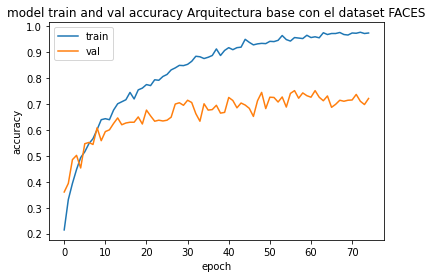

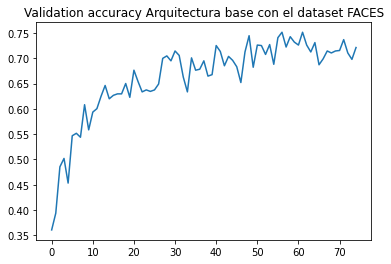

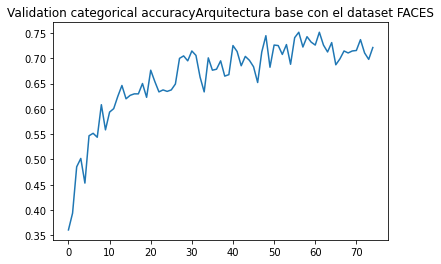

In [ ]:
import os
dir="/content/gdrive/MyDrive/TF_VGG16/FACES_SFEW/Test2/"
Classifier.save(dir+"FACES_SFEW.h5")
if os.path.exists(dir)==False:
  os.makedirs(dir)
Classifier.save(dir+"FACES_SFEW.h5")
title="Arquitectura base con el dataset FACES"
plot_model(history,title)

In [ ]:
Classifier.save('emotionsFACES.h5')

In [ ]:
#Cargamos el modelo obtenido y lo testeamos con los dos datasets:

In [ ]:
#Testeamos el modelo con el FACES i con el SFEW:
datagen = ImageDataGenerator(rescale=1. / 255)
test_set = datagen.flow_from_directory(
    'Test2',
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False)

a = Classifier.evaluate(test_set,steps=16)
print(a)
# print(test_loss," ",test_acc)

predictions=Classifier.predict(test_set)

print('Confusion Matrix')
ypred=[round(list(i).index(max(i))) for i in predictions]
print(confusion_matrix(test_set.classes, ypred)[:,:])
print(test_set.label_indices)

Found 1026 images belonging to 6 classes.


NameError: ignored

In [ ]:
emofaces6=load_model('6emotionsFACES.h5')

In [ ]:
import os
dir="/content/gdrive/MyDrive/TF_VGG16/FACES_SFEW/Test2/"
emofaces6=load_model(dir+"FACES_SFEW.h5")

In [ ]:
#Testeamos el modelo con el FACES i con el SFEW:
datagen = ImageDataGenerator(rescale=1. / 255)
test_set = datagen.flow_from_directory(
    'Test2',
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False)

a = emofaces6.evaluate(test_set,steps=16)
print(a)
# print(test_loss," ",test_acc)

predictions=emofaces6.predict(test_set)

print('Confusion Matrix')
ypred=[round(list(i).index(max(i))) for i in predictions]
print(confusion_matrix(test_set.classes, ypred)[:,:])

Found 1026 images belonging to 6 classes.
16/16 [==============================] - 10s 194ms/step - loss: 0.7039 - categorical_accuracy: 0.7500 - accuracy: 0.7500
[0.7039162516593933, 0.75, 0.75]
Confusion Matrix
[[132   4   0   0  26   9]
 [ 14 102   2   0  41  12]
 [  1   1 133   1  34   1]
 [  3   0   4 132  31   1]
 [  0   0   0   0 171   0]
 [ 15   3   4   1  78  70]]


In [ ]:
print(test_set.class_indices)
emotions_dict = {v: k for k, v in test_set.class_indices.items()}
print(emotions_dict)

{'Anger': 0, 'Disgust': 1, 'Fear': 2, 'Happiness': 3, 'Neutrality': 4, 'Sadness': 5}
{0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Neutrality', 5: 'Sadness'}


In [ ]:
datagen = ImageDataGenerator(rescale=1. / 255)

train_set = datagen.flow_from_directory(
    "SFEW_dataset/Train",
    classes=['Angry','Disgust','Fear','Happy','Neutral','Sad'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True)

nb_train_samples = len(train_set.filenames)

test_set = datagen.flow_from_directory(
    "SFEW_dataset/Val",
    classes=['Angry','Disgust','Fear','Happy','Neutral','Sad'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True)

nb_test_samples = len(test_set.filenames)

Found 766 images belonging to 6 classes.
Found 356 images belonging to 6 classes.


In [ ]:
from keras.callbacks import ModelCheckpoint,CSVLogger
filepath="/content/gdrive/My Drive/FACES_SFEW/SFEW_training/:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
if os.path.exists(filepath)==False:
  os.makedirs(filepath)

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                              min_delta=0,
                                              patience=40,
                                              verbose=1,
                                              mode="auto",
                                              restore_best_weights=True)

# csv_logger = CSVLogger('/content/gdrive/My Drive/TFM_MUSI/training.log')
callbacks_list = [checkpoint,E_stopping]

In [ ]:
history=emofaces6.fit_generator(train_set,
                         steps_per_epoch = nb_train_samples//batch_size,#nb_train_samples//batch_size,
                         epochs = 75,
                         validation_data = test_set,
                         validation_steps = nb_test_samples//batch_size,#nb_test_samples//batch_size,
                         callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/75
766/766 [==============================] - 7s 9ms/step - loss: 3.5419 - categorical_accuracy: 0.2441 - accuracy: 0.2441 - val_loss: 2.5303 - val_categorical_accuracy: 0.1910 - val_accuracy: 0.1910

Epoch 00001: val_accuracy did not improve from 0.20225
Epoch 2/75
766/766 [==============================] - 6s 8ms/step - loss: 2.1687 - categorical_accuracy: 0.3642 - accuracy: 0.3642 - val_loss: 2.4870 - val_categorical_accuracy: 0.1882 - val_accuracy: 0.1882

Epoch 00002: val_accuracy did not improve from 0.20225
Epoch 3/75
766/766 [==============================] - 6s 8ms/step - loss: 1.7594 - categorical_accuracy: 0.4204 - accuracy: 0.4204 - val_loss: 2.4116 - val_categorical_accuracy: 0.2275 - val_accuracy: 0.2275

Epoch 00003: val_accuracy improved from 0.20225 to 0.22753, saving model to /content/gdrive/My Drive/FACES_SFEW/SFEW_training/:003-val_acc:0.228.hdf5
Epoch 4/75
766/766 [==============================] - 6s 8ms/step - loss: 1.4637 - categorical_accuracy: 0.4948 -

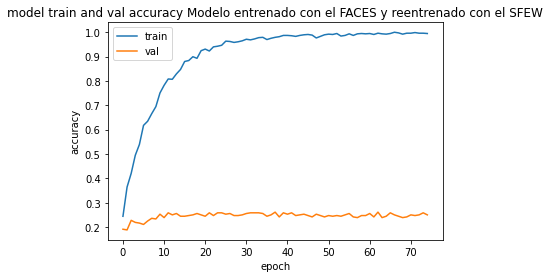

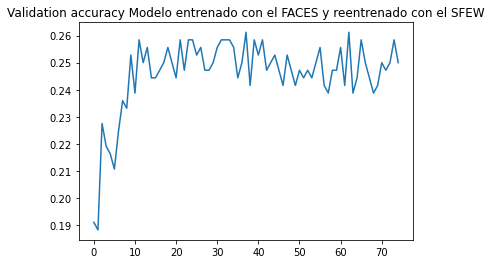

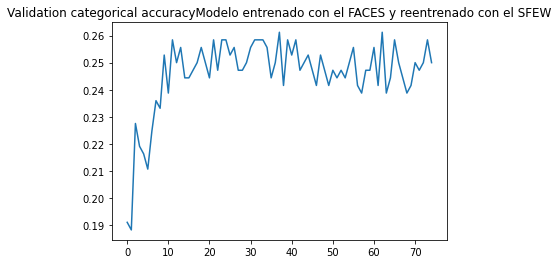

In [ ]:
emofaces6.save(dir+"SFEW_6_emo.h5")
title="Modelo entrenado con el FACES y reentrenado con el SFEW"
plot_model(history,title)


In [ ]:
#Testeamos el modelo con el FACES i con el SFEW:
datagen = ImageDataGenerator(rescale=1. / 255)
test_set = datagen.flow_from_directory(
    'SFEW_dataset/Val',
    classes=['Angry','Disgust','Fear','Happy','Neutral','Sad'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False)

a = emofaces6.evaluate(test_set,steps=16)
print(a)
# print(test_loss," ",test_acc)

predictions=emofaces6.predict(test_set)

print('Confusion Matrix')
ypred=[round(list(i).index(max(i))) for i in predictions]
print(confusion_matrix(test_set.classes, ypred)[:,:])


Found 356 images belonging to 6 classes.
16/16 [==============================] - 0s 4ms/step - loss: 2.8744 - categorical_accuracy: 0.1250 - accuracy: 0.1250
[2.8744049072265625, 0.125, 0.125]
Confusion Matrix
[[16  6  3  5 38  8]
 [ 8  2  0  2  6  5]
 [15  3  1  4  9 13]
 [13  7  1 22 11  8]
 [18  8  2  3 30 21]
 [ 7  9  4  3 27 18]]


In [ ]:
print(test_set.class_indices)
emotions_dict = {v: k for k, v in test_set.class_indices.items()}
print(emotions_dict)

{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5}
{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad'}


In [ ]:
#Dataug

import os
dir="/content/gdrive/MyDrive/TF_VGG16/FACES_SFEW/Test2/"
FACES_SFEW_model=load_model(dir+"FACES_SFEW.h5")

In [ ]:
FACES_SFEW_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 61, 64)        0

In [ ]:
# def create_sets(dataugmentation,train_data_dir,validation_data_dir,batch_size):

#   if dataugmentation==True:
#     train_datagen = ImageDataGenerator(rescale=1. / 255,
#                                    brightness_range=[0.5,1.0],
#                                    zoom_range=0.1,
#                                    shear_range=0.2,
#                                   #  height_shift_range=0.1,
#                                    horizontal_flip=True)
#                                   #  height_shift_range=0.1
#   else:

#     train_datagen = ImageDataGenerator(rescale=1. / 255)

#   test_datagen= ImageDataGenerator(rescale=1. / 255)

#   train_set = train_datagen.flow_from_directory(
#     train_data_dir,
#     classes=['Angry','Disgust','Fear','Happy','Neutral','Sad'],
#     target_size=(img_width, img_height),
#     batch_size=batch_size,
#     class_mode='categorical',
#     # color_mode='grayscale',
#     shuffle=True)
  
#   test_set = test_datagen.flow_from_directory(
#     validation_data_dir,
#     classes=['Angry','Disgust','Fear','Happy','Neutral','Sad'],
#     target_size=(img_width,img_height),
#     batch_size=batch_size,
#     class_mode='categorical',
#     # color_mode='grayscale',
#     shuffle=True)
  
#   return train_set,test_set
# train_set,test_set=create_sets(False,"SFEW_dataset/Train","SFEW_dataset/Val",1)

Found 766 images belonging to 6 classes.
Found 356 images belonging to 6 classes.


In [ ]:
datagen = ImageDataGenerator(rescale=1. / 255)

train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   brightness_range=[0.5,1.0],
                                   zoom_range=0.1,
                                   shear_range=0.2,
                                  #  height_shift_range=0.1,
                                   horizontal_flip=True)
                                  #  height_shift_range=0.1

train_set = train_datagen.flow_from_directory(
    "SFEW_dataset/Train",
    classes=['Angry','Disgust','Fear','Happy','Neutral','Sad'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True)

nb_train_samples = len(train_set.filenames)

test_set = datagen.flow_from_directory(
    "SFEW_dataset/Val",
    classes=['Angry','Disgust','Fear','Happy','Neutral','Sad'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True)

nb_test_samples = len(test_set.filenames)

Found 766 images belonging to 6 classes.
Found 356 images belonging to 6 classes.


In [ ]:
from keras.callbacks import ModelCheckpoint,CSVLogger
filepath="/content/gdrive/My Drive/FACES_SFEW/Dataug/:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                              min_delta=0,
                                              patience=25,
                                              verbose=1,
                                              mode="auto",
                                              restore_best_weights=False)

callbacks_list = [checkpoint,E_stopping]

In [ ]:
history=FACES_SFEW_model.fit_generator(train_set,
                         steps_per_epoch = nb_train_samples//batch_size,#nb_train_samples//batch_size,
                         epochs = 100,
                         validation_data = test_set,
                         validation_steps = nb_test_samples)
                        #  callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
766/766 [==============================] - 7s 9ms/step - loss: 3.6207 - categorical_accuracy: 0.2585 - accuracy: 0.2585 - val_loss: 2.4312 - val_categorical_accuracy: 0.1882 - val_accuracy: 0.1882
Epoch 2/100
766/766 [==============================] - 7s 9ms/step - loss: 2.5683 - categorical_accuracy: 0.2950 - accuracy: 0.2950 - val_loss: 2.2537 - val_categorical_accuracy: 0.2107 - val_accuracy: 0.2107
Epoch 3/100
766/766 [==============================] - 7s 9ms/step - loss: 2.1463 - categorical_accuracy: 0.3473 - accuracy: 0.3473 - val_loss: 2.2148 - val_categorical_accuracy: 0.2079 - val_accuracy: 0.2079
Epoch 4/100
766/766 [==============================] - 7s 9ms/step - loss: 1.9497 - categorical_accuracy: 0.3564 - accuracy: 0.3564 - val_loss: 2.1694 - val_categorical_accuracy: 0.2079 - val_accuracy: 0.2079
Epoch 5/100
766/766 [==============================] - 7s 8ms/step - loss: 1.7717 - categorical_accuracy: 0.3838 - accuracy: 0.3838 - val_loss: 2.1213 - val_categor

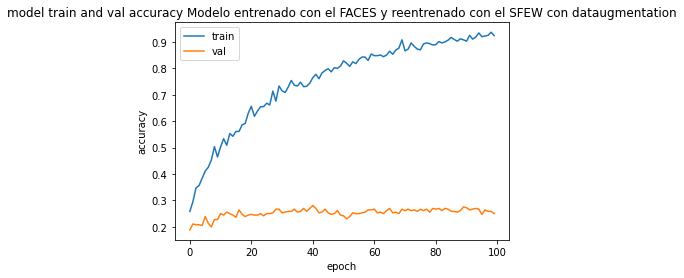

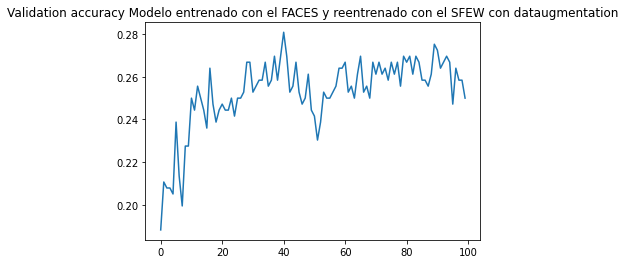

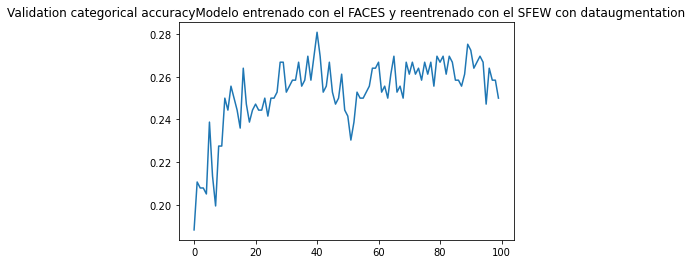

In [ ]:
dir="/content/gdrive/My Drive/FACES_SFEW/Dataug/"
FACES_SFEW_model.save(dir+"SFEW_6_emo_dataug.h5")
title="Modelo entrenado con el FACES y reentrenado con el SFEW con dataugmentation"
plot_model(history,title)

In [ ]:
#Testeamos el modelo con el FACES i con el SFEW:
test_set = datagen.flow_from_directory(
    'SFEW_dataset/Val',
    target_size=(img_width, img_height),
    batch_size=1,
    classes=['Angry','Disgust','Fear','Happy','Sad','Neutral'],
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False)

predictions=FACES_SFEW_model.predict(test_set)

print('Confusion Matrix')
ypred=[round(list(i).index(max(i))) for i in predictions]
print(confusion_matrix(test_set.classes, ypred)[:,:])

FACES_SFEW_model.evaluate_generator(test_set)
test_set.class_indices

Found 356 images belonging to 6 classes.
Confusion Matrix
[[11  2  1  4 56  2]
 [ 3  2  0  3 14  1]
 [ 2  1  0  4 24 14]
 [ 7  7  2 13 28  5]
 [ 3  4  2  6 44  9]
 [ 2  6  0  4 54 16]]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 5, 'Sad': 4}

In [ ]:
train_set = datagen.flow_from_directory(
    'SFEW_dataset/Train',
    classes=['Angry','Disgust','Fear','Happy','Sad','Neutral'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True)

test_set = datagen.flow_from_directory(
    'SFEW_dataset/Val',
    target_size=(img_width, img_height),
    batch_size=1,
    classes=['Angry','Disgust','Fear','Happy','Sad','Neutral'],
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True)

In [ ]:
emofaces6.summary()

In [ ]:
#Reentrenamos el modelo con el SFEW utilizando de base los pesos del modelo anterior 

In [ ]:
emofaces6.fit_generator(train_set,
                         steps_per_epoch = nb_train_samples//batch_size,#nb_train_samples//batch_size,
                         epochs = 35,
                         validation_data = test_set,
                         validation_steps = nb_test_samples//batch_size)#nb_test_samples//batch_size,
                         #callbacks=callbacks_list)

#Algo no està bé va molt ràpid i molt loco

In [ ]:
emofaces6.save('6emotionsFACES_2.h5')

In [ ]:
#Provamos que tal va el modelo original con el SFEWW
# LAS DOS ULTIMAS EMOCIONES NO SON IGUALES!!
test_set = datagen.flow_from_directory(
    'SFEW_dataset/Train',
    target_size=(img_width, img_height),
    classes=['Angry','Disgust','Fear','Happy','Sad','Neutral'],
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False)

predictions=emofaces6.predict(test_set)

print('Confusion Matrix')
ypred=[round(list(i).index(max(i))) for i in predictions]
print(confusion_matrix(test_set.classes, ypred)[:,:])

#Va fatal 

#Balancear el dataset????????

Pruebas prueba 1: entrenar esta red con el SFEW
Prueba 2: entrenar la red con el SFEW y data augmentation
Prueba 3: entrenar la red inicializando los pesos a los del FACES

In [ ]:
from keras.models import load_model
base_model = load_model('6emotionsFACES.h5')

In [ ]:
#Comprovamos que el modelo va bien:

datagen = ImageDataGenerator(rescale=1. / 255)

img_width, img_height=100,100
test_set = datagen.flow_from_directory(
    'Test2',
    classes=['Anger','Disgust','Fear','Happiness','Sadness'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False)

predictions=base_model.predict(test_set)

print('Confusion Matrix')
ypred=[round(list(i).index(max(i))) for i in predictions]
print(confusion_matrix(test_set.classes, ypred)[:,:])

In [ ]:
test_set = datagen.flow_from_directory(
    'SFEW/data/test',
    classes=['Anger','Disgust','Fear','Happiness','Sadness'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False)

predictions=base_model.predict(test_set)

print('Confusion Matrix')
ypred=[round(list(i).index(max(i))) for i in predictions]
print(confusion_matrix(test_set.classes, ypred)[:,:])

#Predice siempre fear :/
test_set.labels

for i in range(0,5):
 print(list(test_set.labels).count(i))

In [ ]:
# 1 Entrenamos esta red con el SFEW:

#Las imagenes del SFEW son más pequeñas

img_width, img_height =100, 100

datagen = ImageDataGenerator(rescale=1. / 255)

train_set = datagen.flow_from_directory(
    'SFEW/data/train',
    classes=['Anger','Disgust','Fear','Happiness','Sadness'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True)

nb_train_samples = len(train_set.filenames)

test_set = datagen.flow_from_directory(
    'SFEW/data/test',
    classes=['Anger','Disgust','Fear','Happiness','Sadness'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True)

nb_test_samples = len(test_set.filenames)

In [ ]:
filepath="/SFEW/:{epoch:03d}-val_accuracy:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

In [ ]:
base_model.fit_generator(train_set,
                         steps_per_epoch = nb_train_samples//batch_size,
                         epochs = 35,
                         validation_data = test_set,
                         validation_steps = nb_train_samples//batch_size)
                         #callbacks=callbacks_list)


In [ ]:
base_model.save('base_modelFACES6emo.h5') 

In [ ]:
base_model.save('base_modelFACES6emo.h5') 

In [ ]:
test_set = datagen.flow_from_directory(
    'SFEW/data/test',
    classes=['Anger','Disgust','Fear','Happiness','Sadness'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False)

predictions=base_model.predict(test_set)

print('Confusion Matrix')
ypred=[round(list(i).index(max(i))) for i in predictions]
print(confusion_matrix(test_set.classes, ypred)[:,:])

#Predice siempre fear :/
test_set.labels

for i in range(0,5):
 print(list(test_set.labels).count(i))

base_model.evaluate_generator(test_set)

# evaluate the model
#loss, accuracy, f1_score, precision, recall = model.evaluate(Xtest, ytest, verbose=0) 

In [ ]:
#35 epochs más?

base_model.fit_generator(train_set,
                         steps_per_epoch = nb_train_samples//batch_size,
                         epochs = 35,
                         validation_data = test_set,
                         validation_steps = nb_train_samples//batch_size)
                         #callbacks=callbacks_list)

In [ ]:
test_set = datagen.flow_from_directory(
    'SFEW/data/test',
    classes=['Anger','Disgust','Fear','Happiness','Sadness'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False)

predictions=base_model.predict(test_set)

print('Confusion Matrix')
ypred=[round(list(i).index(max(i))) for i in predictions]
print(confusion_matrix(test_set.classes, ypred)[:,:])

#Predice siempre fear :/
test_set.labels

for i in range(0,5):
 print(list(test_set.labels).count(i))

base_model.evaluate_generator(test_set)

# evaluate the model
#loss, accuracy, f1_score, precision, recall = model.evaluate(Xtest, ytest, verbose=0) 

In [ ]:
base_model.save("5emotionsreentrenado_37.h5")

In [ ]:
base_model.fit_generator(train_set,
                         steps_per_epoch = nb_train_samples//batch_size,
                         epochs = 15,
                         validation_data = test_set,
                         validation_steps = nb_train_samples//batch_size)
                         #callbacks=callbacks_list)

In [ ]:
base_model.save("5emotionsreentrenado_37_6.h5")

In [ ]:
test_set = datagen.flow_from_directory(
    'SFEW/data/test',
    classes=['Anger','Disgust','Fear','Happiness','Sadness'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False)

predictions=base_model.predict(test_set)

print('Confusion Matrix')
ypred=[round(list(i).index(max(i))) for i in predictions]
print(confusion_matrix(test_set.classes, ypred)[:,:])

#Predice siempre fear :/
test_set.labels

for i in range(0,5):
 print(list(test_set.labels).count(i))

base_model.evaluate_generator(test_set)